##                    Induced Earthquakes and Satlwater Disposal

# Final Project 
 __Advance Geographic Information Sytem__\
 __GEOG 7940__\
 **Md Mohimanul Islam**

# Introduction

Starting around 2009, there was a noticeable uptick in the frequency of small to moderate earthquakes across large portions of the central and eastern United States. In the rencet decades, certain areas of Oklahoma have seen significant rises in the occurrence of small to medium-sized earthquakes. It is a commonly acknowledged observation that a significant portion of this seismic activity appears to be connected to the increase in injection wells and hydraulic fracturing activities within oil and gas fields (Frohlich et al., 2012; Horton, 2012; Kim, 2013; McGarr et al., 2015). Typically, produced water resulting from oil and gas exploration activities is either reintroduced into the oil-producing formation during water-flooding enhanced oil recovery (EOR) processes, or it is disposed of in specialized saltwater disposal (SWD) wells. These wells commonly inject the water into saline aquifers, which are sedimentary formations characterized by relatively high porosity and permeability. 

When water is injected into the underground reservoir, the fluid pressure increases. This causes reduction of the effective normal stress on a fault. As the effective normal stress decreases, it serves to loosen a fault, possibly initiating the release of stored strain energy on an existing fault that is already near failure. An earthquake occurring on such a fault under critical stress due to fluid injection is known as a triggered earthquake. Over time, strain energy builds up on a fault as part of natural geological processes. The alteration in pressure caused by fluid injection merely prompts its release and results a trigggerd earthquake. 

This project aims to investigate injection-related seismicity through geospatial analysis. I have chosen the state of Oklahoma due to its significant increase in seismic activity in recent years. In this endeavor, I've developed a Jupyter notebook capable of conducting similar analyses for other states affected by induced seismicity, such as Kansas and Illinos.
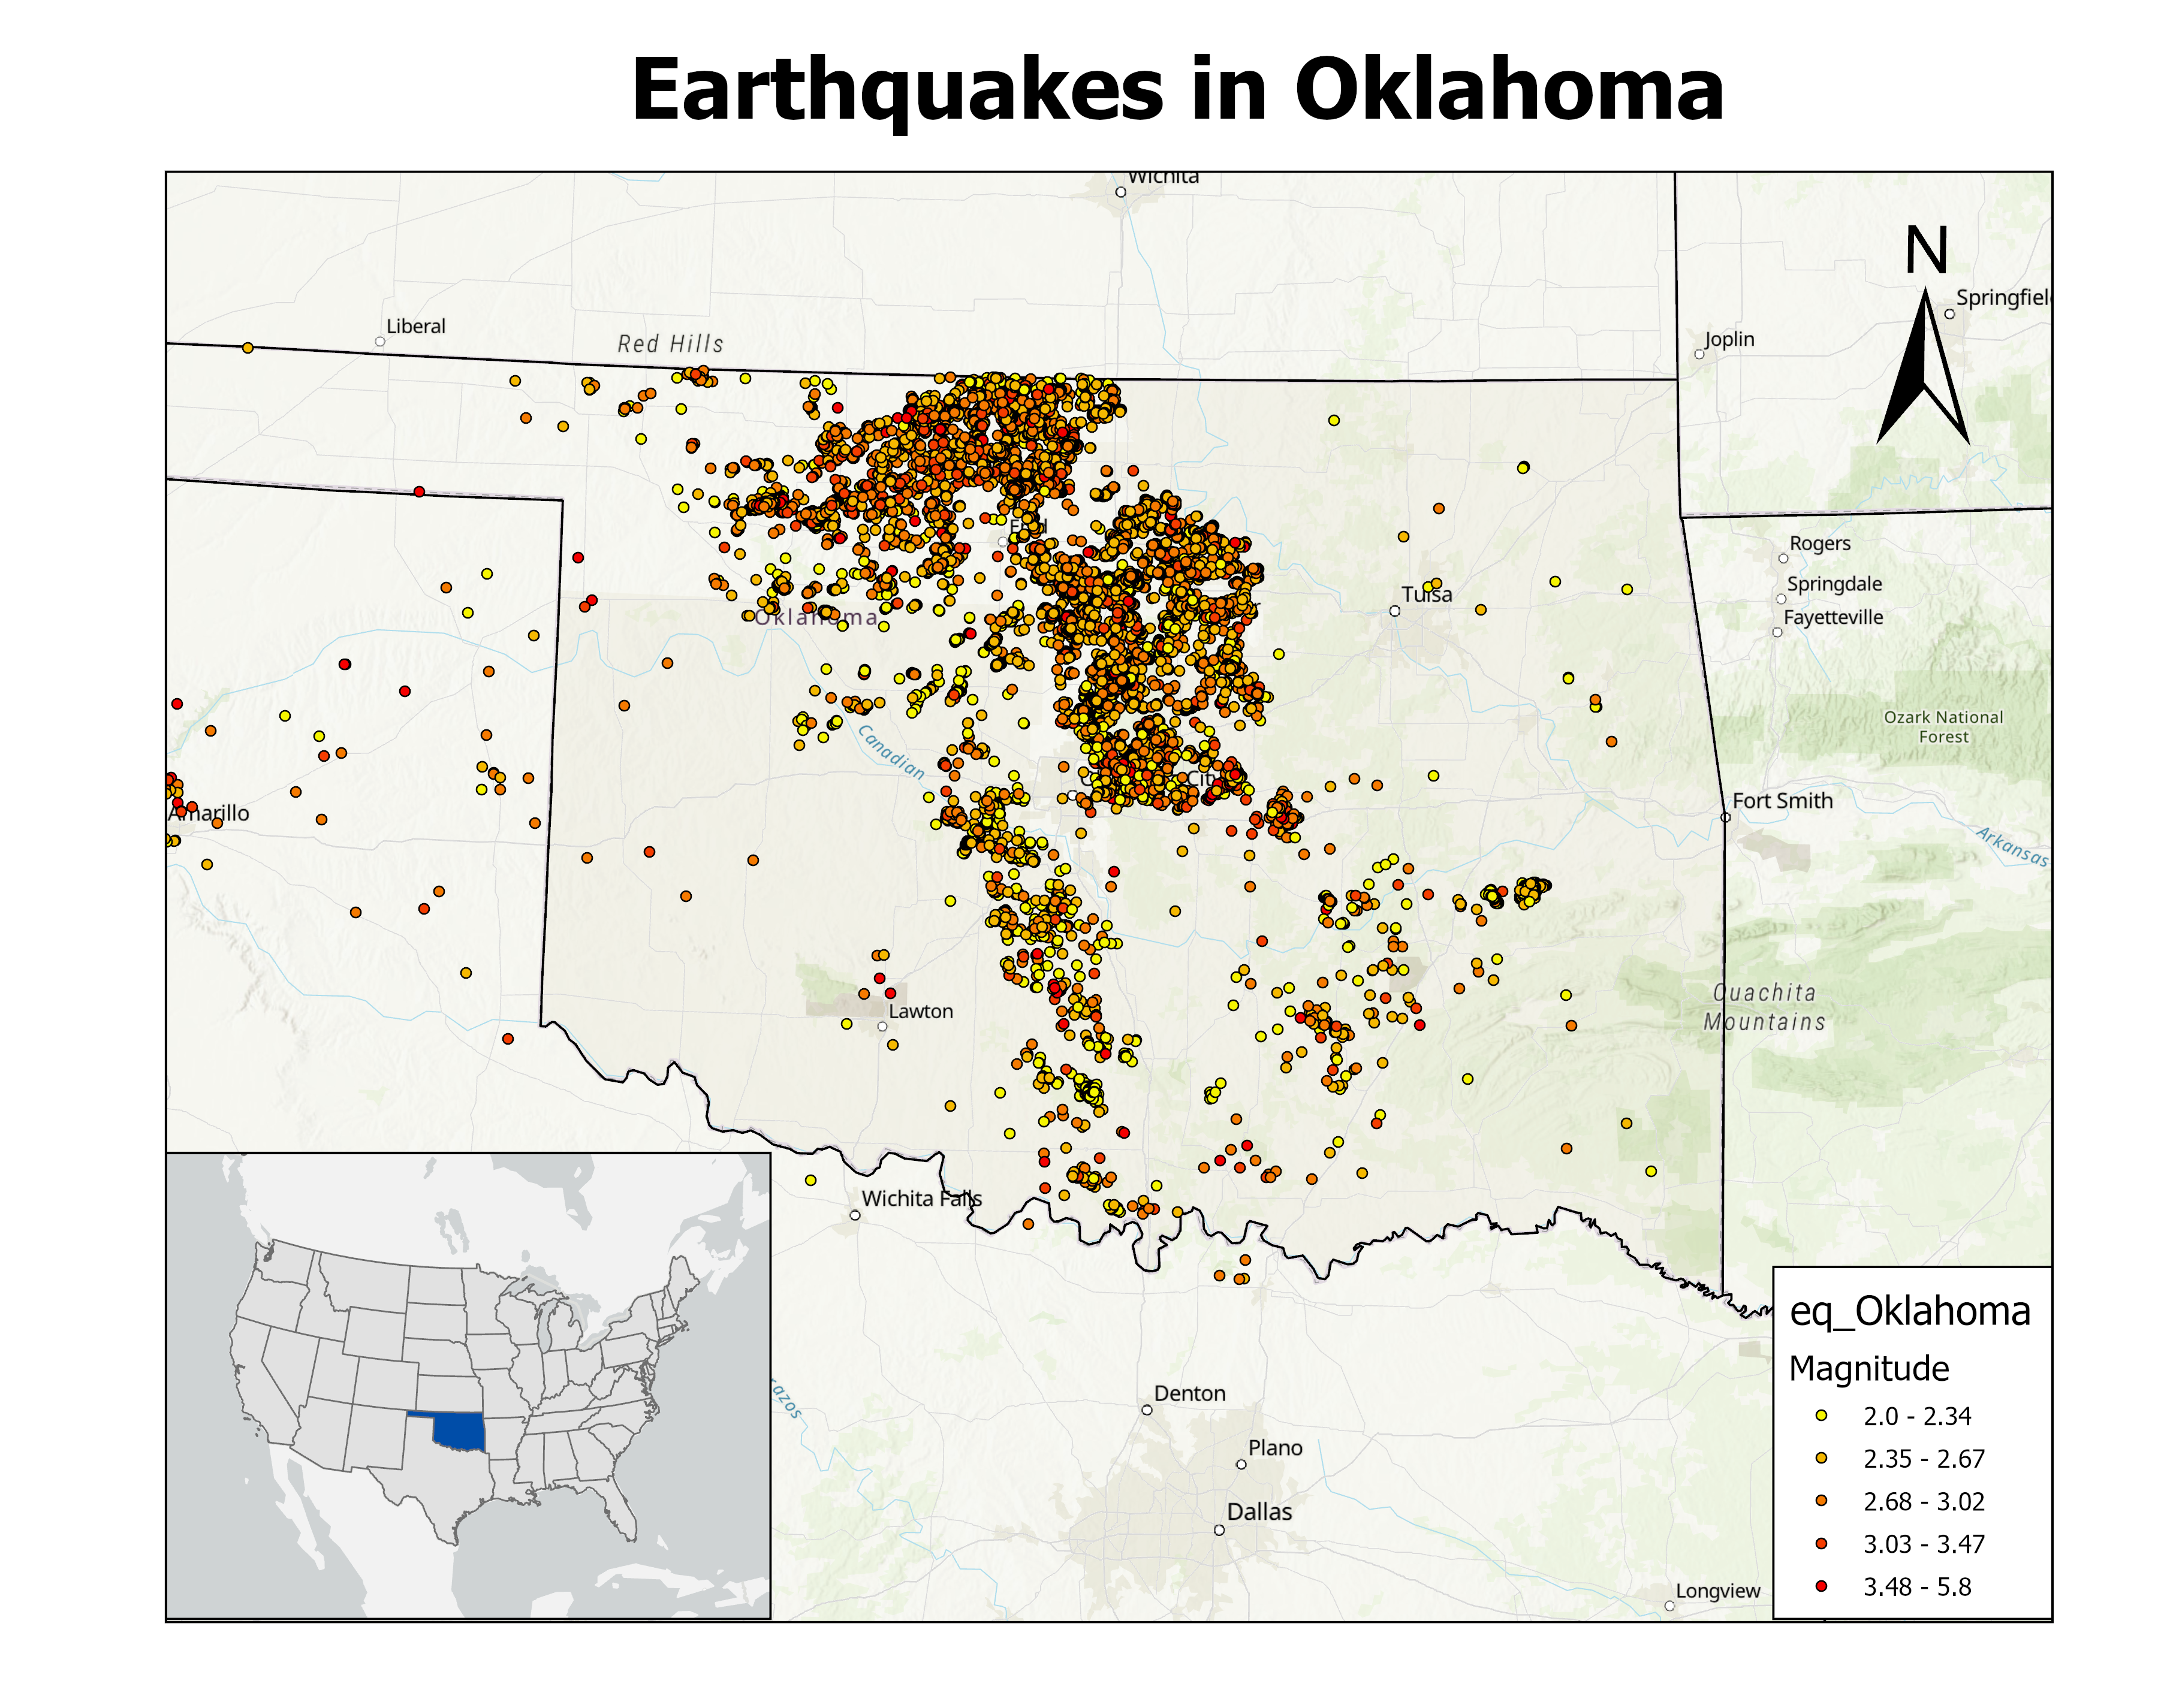

**Workflows:**

**Import necessary python modules**

**Dowload Earthquakes data form USGS**

**Analysis and Mapping**

**Interpretatoin**


In [46]:
# import os module
import sys, os

# setting up the workspace 
import os

# import arcpy module
import arcpy

# import env module
from arcpy import env

# import mp module
from arcpy import mp

# import url builder libaray 

import urllib.request   

# import csv module
import csv
# import datetime module
from datetime import datetime

**Configure the current workspace environmental variables**

In [47]:
#path to the project
BaseDirectory = os.getcwd()

## Set the overwrite variable.
arcpy.env.overwriteOutput = True

GDBName='project.gdb'

# set the project data path
project_data_path=os.path.join(BaseDirectory,'projectdata')

# Create the geodatabase
#arcpy.CreateFileGDB_management(BaseDirectory, GDBName)

## Set a variable to the path to the ADAExData.gdb.
GDBpath = os.path.join(BaseDirectory,GDBName)

## Set the current workspace
env.workspace = GDBpath

## Set the scratch workspace to be a gdb named ScratchOutput.gdb in the ADAExData directory.
arcpy.env.scratchWorkspace = os.path.join(BaseDirectory,'Projectdata','ScratchOutput.gdb')

## Project database
The project database contain sevearal datasets and feature classes necessay for this project.  

In [48]:
# Project database containt US sate polygon 
feature_classes = arcpy.ListFeatureClasses()
print(feature_classes)


['counties', 'states_wgs84', 'OK_class_II_injection_wells', 'eq_Oklahoma', 'OK_state', 'US_faults', 'states', 'Oklahoma', 'grids', 'eq_per_grids', 'eqOK', 'Oklahoma_eq_density', 'Oklahoma_faults', 'well_buffer', 'AR_ClassII_InjectionWells', 'CA_ClassII_InjectionWells', 'IL_ClassII_InjectionWells', 'IN_ClassII_InjectionWells', 'KS_ClassII_InjectionWells', 'UT_ClassII_InjectionWells']


We can see the geodatabase contains several featureclases:
 
 * states_wgs84 - this feature class contains all the state polyons of US with necessay informaiton in the attribute table
 
 * state_name_class_II_injection_wells - these are the set of feature classes contains the location of the Class II injeciton    wells. These data are dowloaded form "https://www.fractracker.org/waste/". 
 * us_faults - Quaternary Fault database from USGS that demonstrate geological evidence of coseismic surface deformation in large earthquakes during the past 1.6 million years (Ma). source link : https://www.usgs.gov/programs/earthquake-hazards/faults
 * Please only select the state that have the available injection well data.
 * All the porject maps are stored in Figure folder


**Define state name and claculate its bounding geometry**

* In this step, the stae of interest (Oklahoma) is defined and its extent is calculed form the state polyogn


In [49]:
# Define the spatial reference of WGS84
sr = arcpy.SpatialReference(4326)
stateFc = "states_wgs84"
stateFc_path=os.path.join(GDBpath,stateFc)

# the name of state (we will put focus on Oklahoma, change the sate name if you want to analize different state)
state_name='Oklahoma'   

# path to the ouput map directory
out_maps=os.path.join(BaseDirectory,"Figures")   



In [50]:
# now get the extent of th e

# Create a search cursor to iterate through the features in the shapefile
with arcpy.da.SearchCursor(stateFc, ['SHAPE@', 'STATE_NAME', 'STATE_ABBR']) as cursor:
    min_lon = float('inf')
    min_lat = float('inf')
    max_lon = float('-inf')
    max_lat = float('-inf')

    for row in cursor:
        if row[1] == state_name:
            # Get the extent (bounding box) of the feature's geometry
            extent = row[0].extent

            # Update min and max latitude and longitude values
            min_lon = min(min_lon, extent.XMin)
            min_lat = min(min_lat, extent.YMin)
            max_lon = max(max_lon, extent.XMax)
            max_lat = max(max_lat, extent.YMax)
            # get the abbriviated state code 
            state_name_abr=row[2]

# Print the min and max latitude and longitude values
print("Minimum Latitude:", min_lat)
print("Maximum Latitude:", max_lat)
print("Minimum Longitude:", min_lon)
print("Maximum Longitude:", max_lon)
print("state short name:", state_name_abr)

Minimum Latitude: 33.62114259700007
Maximum Latitude: 37.00148467400004
Minimum Longitude: -102.99771884899997
Maximum Longitude: -94.42855910599997
state short name: OK


# Retrive the earthquake datasets from USGS Eathquake (NEIC) catalogue

* In this part the earthquake datsets are downloaded form the USGS catalogue by specifying the necearray paremeters
* To aid the analysis, I have downloaded the eathquake form 1960 to 2023.
* The output data will be saved as a text file (earthquakes_statename)

In [54]:
# retrive the earthquake datasets from USGS Eathquake (NEIC) catalog 

# setting the other parameter
st_yr='1960-01-01'    # start year 
end_yr='2023-01-01'   # end year
mag_min=2.0   # minimum magnitude
mag_max=9.0   # maximumum magnitude


url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=%s&endtime=%s&minmagnitude\
=%2.1f&maxmagnitude=%2.1f&minlatitude=%4.1f&minlongitude=%5.1f&maxlatitude=%4.1f&maxlongitude=%5.1f" \
%(st_yr, end_yr, mag_min, mag_max, min_lat, min_lon, max_lat, max_lon)
outfile_name = 'earthquakes_' +str(state_name) +'.txt'
outfile_path=os.path.join(project_data_path,outfile_name)

print(url)
# download the dataset
urllib.request.urlretrieve(url, outfile_path)

https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=1960-01-01&endtime=2023-01-01&minmagnitude=2.0&maxmagnitude=9.0&minlatitude=33.6&minlongitude=-103.0&maxlatitude=37.0&maxlongitude=-94.4


**Now make a piont feature class earthquakes location,time and magnitude**

In [43]:
# create new point featureclass
eqFC = "eq_%s" % state_name
eqFC_path=os.path.join(GDBpath,eqFC)
arcpy.management.CreateFeatureclass(out_path=GDBpath,out_name=eqFC,geometry_type="POINT",spatial_reference=sr)


# define fields to add
fields = [["DateTime",  "DATE"],
              ["Latitude",    "FLOAT"],
              ["Longitude",  'FLOAT'],
              ["Depth",    "FLOAT"],
              ["Magnitude",  "DOUBLE"]]
              
#add fields
for fieldName, fieldType in fields:
    #print(fieldName)
    #print(fieldType)
    arcpy.management.AddField(eqFC, fieldName, fieldType)


In [78]:
# poplute the feature class from the txt file 
#(its a lot of entries, might take several minultes)

# Open the text file and insert data into the point feature class

with open(outfile_path, 'r') as file:
    # Skip the header line
    next(file)  
    for line in file:
             
        # Split the line using delimiter
        fields = line.strip().split("|")
        time=fields[1]
        eq_date = datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%f")
        lat=float(fields[2])
        lon=float(fields[3])
        
        depth=float(fields[4])
        mag=float(fields[10])
        XY=(float(lon), float(lat))
        row = [XY, lat, lon, depth, mag, eq_date]
        print(row)
        
        with arcpy.da.InsertCursor(eqFC, ["SHAPE@XY", "Latitude","Longitude", "Depth", "Magnitude", "DateTime"]) as cursor:
                                   cursor.insertRow(row)
                           

[(-97.18883333, 35.85383333), 35.85383333, -97.18883333, 7.51, 2.61, datetime.datetime(2022, 12, 31, 8, 52, 11, 169000)]
[(-98.20483333, 35.45033333), 35.45033333, -98.20483333, 6.86, 2.03, datetime.datetime(2022, 12, 29, 9, 38, 58, 350000)]
[(-98.958, 36.54083333), 36.54083333, -98.958, 6.79, 2.45, datetime.datetime(2022, 12, 28, 14, 53, 31, 120000)]
[(-95.54233333, 35.12583333), 35.12583333, -95.54233333, 7.28, 2.26, datetime.datetime(2022, 12, 27, 13, 9, 13, 390000)]
[(-98.9605, 36.5425), 36.5425, -98.9605, 6.22, 2.24, datetime.datetime(2022, 12, 26, 15, 44, 37, 340000)]
[(-98.95816667, 36.54266667), 36.54266667, -98.95816667, 6.64, 2.3, datetime.datetime(2022, 12, 26, 12, 52, 36, 740000)]
[(-98.95916667, 36.54233333), 36.54233333, -98.95916667, 6.67, 2.36, datetime.datetime(2022, 12, 26, 5, 59, 1, 990000)]
[(-98.0205, 35.283), 35.283, -98.0205, 7.62, 2.92, datetime.datetime(2022, 12, 23, 11, 7, 18, 370000)]
[(-97.8995, 34.99733333), 34.99733333, -97.8995, 9.17, 2.07, datetime.datet

[(-101.7604417, 35.17181396), 35.17181396, -101.7604417, 7.947794596, 2.3, datetime.datetime(2022, 10, 28, 23, 49, 46, 214000)]
[(-97.8905, 35.41066667), 35.41066667, -97.8905, 4.98, 2.37, datetime.datetime(2022, 10, 28, 14, 30, 38, 30000)]
[(-101.7660757, 35.16906738), 35.16906738, -101.7660757, 6.113688151, 2.5, datetime.datetime(2022, 10, 28, 13, 33, 21, 7000)]
[(-97.26133333, 34.52533333), 34.52533333, -97.26133333, 0.0, 2.15, datetime.datetime(2022, 10, 28, 9, 7, 41, 850000)]
[(-97.371, 34.5375), 34.5375, -97.371, 4.91, 2.36, datetime.datetime(2022, 10, 28, 7, 51, 6, 790000)]
[(-97.6485, 36.92433333), 36.92433333, -97.6485, 4.55, 2.35, datetime.datetime(2022, 10, 27, 19, 41, 58, 229000)]
[(-97.78266667, 36.85433333), 36.85433333, -97.78266667, 7.86, 2.42, datetime.datetime(2022, 10, 27, 16, 56, 11, 800000)]
[(-97.37833333, 34.54816667), 34.54816667, -97.37833333, 4.12, 2.22, datetime.datetime(2022, 10, 27, 16, 37, 18, 480000)]
[(-97.7895, 36.851), 36.851, -97.7895, 5.41, 2.13, dat

[(-97.493, 36.97966667), 36.97966667, -97.493, 4.75, 2.71, datetime.datetime(2022, 8, 16, 16, 25, 59, 450000)]
[(-97.2955, 33.949), 33.949, -97.2955, 13.77, 2.05, datetime.datetime(2022, 8, 16, 9, 29, 34, 969000)]
[(-98.33716667, 36.515), 36.515, -98.33716667, 7.0, 2.16, datetime.datetime(2022, 8, 13, 18, 40, 3, 299000)]
[(-98.45233333, 36.24466667), 36.24466667, -98.45233333, 6.68, 2.27, datetime.datetime(2022, 8, 5, 11, 19, 54, 630000)]
[(-98.45483333, 36.2455), 36.2455, -98.45483333, 6.54, 2.02, datetime.datetime(2022, 8, 5, 10, 54, 34, 259000)]
[(-97.84016667, 35.01083333), 35.01083333, -97.84016667, 7.6, 2.01, datetime.datetime(2022, 7, 30, 21, 34, 29, 550000)]
[(-97.45516667, 36.09383333), 36.09383333, -97.45516667, 7.39, 2.19, datetime.datetime(2022, 7, 30, 5, 5, 57, 579000)]
[(-98.067, 36.75933333), 36.75933333, -98.067, 7.97, 2.09, datetime.datetime(2022, 7, 22, 2, 42, 1, 240000)]
[(-98.06716667, 36.7595), 36.7595, -98.06716667, 6.89, 2.07, datetime.datetime(2022, 7, 21, 0, 44

[(-95.27816667, 35.14616667), 35.14616667, -95.27816667, 5.14, 2.02, datetime.datetime(2022, 3, 29, 20, 15, 58, 509000)]
[(-97.42216667, 35.674), 35.674, -97.42216667, 7.08, 3.29, datetime.datetime(2022, 3, 27, 15, 1, 16, 519000)]
[(-97.7985, 35.253), 35.253, -97.7985, 6.09, 2.11, datetime.datetime(2022, 3, 19, 11, 46, 11, 39000)]
[(-97.29366667, 35.4475), 35.4475, -97.29366667, 5.87, 2.01, datetime.datetime(2022, 3, 18, 4, 3, 26, 600000)]
[(-97.50216667, 36.278), 36.278, -97.50216667, 7.95, 2.79, datetime.datetime(2022, 3, 16, 15, 29, 40, 20000)]
[(-95.53583333, 35.106), 35.106, -95.53583333, 7.69, 3.12, datetime.datetime(2022, 3, 14, 11, 20, 21, 399000)]
[(-98.43933333, 36.07266667), 36.07266667, -98.43933333, 19.15, 2.24, datetime.datetime(2022, 3, 10, 15, 11, 16, 120000)]
[(-97.70283333, 34.96183333), 34.96183333, -97.70283333, 7.69, 2.0, datetime.datetime(2022, 3, 7, 16, 55, 13, 580000)]
[(-98.2945, 36.23833333), 36.23833333, -98.2945, 18.78, 2.15, datetime.datetime(2022, 3, 6, 11

[(-95.53466667, 35.11033333), 35.11033333, -95.53466667, 7.11, 2.03, datetime.datetime(2021, 11, 27, 13, 42, 51, 299000)]
[(-95.39116667, 35.09933333), 35.09933333, -95.39116667, 7.36, 2.35, datetime.datetime(2021, 11, 27, 0, 45, 55, 79000)]
[(-95.39316667, 35.09916667), 35.09916667, -95.39316667, 7.32, 2.18, datetime.datetime(2021, 11, 26, 22, 6, 16, 70000)]
[(-97.3455, 36.3655), 36.3655, -97.3455, 5.88, 2.19, datetime.datetime(2021, 11, 25, 2, 16, 4, 780000)]
[(-97.46466667, 34.36366667), 34.36366667, -97.46466667, 5.86, 2.34, datetime.datetime(2021, 11, 24, 11, 53, 11, 429000)]
[(-98.15683333, 36.364), 36.364, -98.15683333, 6.61, 2.04, datetime.datetime(2021, 11, 24, 11, 9, 33, 500000)]
[(-95.39233333, 35.10033333), 35.10033333, -95.39233333, 7.47, 2.68, datetime.datetime(2021, 11, 24, 10, 16, 37, 890000)]
[(-95.38983333, 35.09983333), 35.09983333, -95.38983333, 7.56, 3.28, datetime.datetime(2021, 11, 24, 5, 30, 15, 189000)]
[(-97.83033333, 35.03516667), 35.03516667, -97.83033333, 9

[(-95.3865, 35.114), 35.114, -95.3865, 7.4, 2.13, datetime.datetime(2021, 8, 24, 17, 18, 4, 280000)]
[(-95.3725, 35.11116667), 35.11116667, -95.3725, 6.62, 3.73, datetime.datetime(2021, 8, 24, 15, 23, 45, 829000)]
[(-95.373, 35.10816667), 35.10816667, -95.373, 6.98, 2.16, datetime.datetime(2021, 8, 24, 7, 21, 33, 579000)]
[(-95.37233333, 35.11033333), 35.11033333, -95.37233333, 6.84, 2.22, datetime.datetime(2021, 8, 24, 5, 24, 36, 390000)]
[(-95.37316667, 35.11033333), 35.11033333, -95.37316667, 7.25, 2.09, datetime.datetime(2021, 8, 24, 5, 13, 50, 299000)]
[(-95.371, 35.1115), 35.1115, -95.371, 7.05, 2.28, datetime.datetime(2021, 8, 24, 3, 32, 38, 750000)]
[(-97.42516667, 35.67316667), 35.67316667, -97.42516667, 7.15, 2.01, datetime.datetime(2021, 8, 23, 13, 45, 15, 949000)]
[(-97.34316667, 36.36533333), 36.36533333, -97.34316667, 5.89, 2.22, datetime.datetime(2021, 8, 23, 10, 11, 24, 789000)]
[(-95.3405, 35.11166667), 35.11166667, -95.3405, 7.03, 2.38, datetime.datetime(2021, 8, 23, 

[(-96.98683333, 35.79133333), 35.79133333, -96.98683333, 5.0, 2.56, datetime.datetime(2021, 6, 16, 21, 58, 12, 880000)]
[(-96.985, 35.7915), 35.7915, -96.985, 7.0, 3.74, datetime.datetime(2021, 6, 16, 21, 7, 33, 79000)]
[(-95.3835, 35.10833333), 35.10833333, -95.3835, 7.03, 2.53, datetime.datetime(2021, 6, 16, 18, 18, 26, 579000)]
[(-97.41616667, 34.38733333), 34.38733333, -97.41616667, 5.44, 2.07, datetime.datetime(2021, 6, 16, 8, 3, 35, 929000)]
[(-97.508, 36.28366667), 36.28366667, -97.508, 8.19, 2.04, datetime.datetime(2021, 6, 15, 17, 39, 29, 329000)]
[(-95.3795, 35.10233333), 35.10233333, -95.3795, 7.01, 2.12, datetime.datetime(2021, 6, 15, 3, 14, 5, 509000)]
[(-97.824, 36.403), 36.403, -97.824, 7.46, 2.08, datetime.datetime(2021, 6, 14, 9, 51, 58, 219000)]
[(-95.383, 35.10066667), 35.10066667, -95.383, 6.16, 2.41, datetime.datetime(2021, 6, 14, 0, 16, 10, 699000)]
[(-95.385, 35.104), 35.104, -95.385, 6.65, 2.35, datetime.datetime(2021, 6, 13, 21, 18, 11, 650000)]
[(-95.36116667,

[(-97.68066667, 34.76183333), 34.76183333, -97.68066667, 13.56, 2.11, datetime.datetime(2021, 5, 3, 4, 15, 49, 140000)]
[(-97.67383333, 34.76216667), 34.76216667, -97.67383333, 13.27, 2.21, datetime.datetime(2021, 5, 3, 0, 45, 13, 269000)]
[(-97.505, 36.28016667), 36.28016667, -97.505, 7.84, 2.31, datetime.datetime(2021, 5, 2, 11, 18, 1, 850000)]
[(-97.455, 34.42733333), 34.42733333, -97.455, 6.55, 2.13, datetime.datetime(2021, 4, 30, 19, 58, 59, 159000)]
[(-98.72583333, 36.93733333), 36.93733333, -98.72583333, 6.66, 2.0, datetime.datetime(2021, 4, 30, 13, 16, 32, 70000)]
[(-98.0865, 35.43866667), 35.43866667, -98.0865, 7.03, 2.38, datetime.datetime(2021, 4, 28, 18, 2, 52, 380000)]
[(-97.36333333, 36.35983333), 36.35983333, -97.36333333, 7.59, 2.32, datetime.datetime(2021, 4, 28, 12, 23, 43, 140000)]
[(-95.37883333, 35.13066667), 35.13066667, -95.37883333, 7.48, 2.06, datetime.datetime(2021, 4, 25, 17, 33, 22, 440000)]
[(-97.341, 36.366), 36.366, -97.341, 5.76, 2.3, datetime.datetime(2

[(-97.42416667, 34.38166667), 34.38166667, -97.42416667, 5.18, 2.2, datetime.datetime(2021, 3, 23, 13, 46, 24, 399000)]
[(-97.40883333, 34.383), 34.383, -97.40883333, 4.11, 2.0, datetime.datetime(2021, 3, 23, 13, 35, 7, 169000)]
[(-97.429, 34.39333333), 34.39333333, -97.429, 4.25, 2.04, datetime.datetime(2021, 3, 23, 13, 15, 22, 210000)]
[(-97.426, 34.37783333), 34.37783333, -97.426, 5.43, 2.04, datetime.datetime(2021, 3, 23, 11, 6, 16, 120000)]
[(-97.42433333, 34.38016667), 34.38016667, -97.42433333, 5.58, 2.22, datetime.datetime(2021, 3, 23, 9, 27, 38, 140000)]
[(-97.92833333, 35.3575), 35.3575, -97.92833333, 6.46, 2.6, datetime.datetime(2021, 3, 23, 4, 13, 5, 269000)]
[(-97.42483333, 34.396), 34.396, -97.42483333, 5.62, 2.47, datetime.datetime(2021, 3, 22, 17, 36, 35, 740000)]
[(-97.41516667, 34.38366667), 34.38366667, -97.41516667, 4.85, 2.0, datetime.datetime(2021, 3, 22, 14, 44, 3, 549000)]
[(-97.41933333, 34.38283333), 34.38283333, -97.41933333, 4.8, 2.07, datetime.datetime(2021

[(-98.19816667, 35.8535), 35.8535, -98.19816667, 7.41, 2.52, datetime.datetime(2021, 3, 1, 10, 24, 47, 899000)]
[(-97.42666667, 34.39233333), 34.39233333, -97.42666667, 5.55, 2.19, datetime.datetime(2021, 3, 1, 4, 59, 18, 30000)]
[(-97.4305, 34.386), 34.386, -97.4305, 5.59, 2.17, datetime.datetime(2021, 3, 1, 1, 3, 34, 229000)]
[(-98.156, 36.369), 36.369, -98.156, 7.81, 2.31, datetime.datetime(2021, 2, 28, 21, 45, 3, 29000)]
[(-98.15533333, 36.36316667), 36.36316667, -98.15533333, 7.22, 3.68, datetime.datetime(2021, 2, 28, 21, 38, 38, 590000)]
[(-97.42933333, 34.39183333), 34.39183333, -97.42933333, 5.82, 2.22, datetime.datetime(2021, 2, 28, 19, 59, 47, 179000)]
[(-97.409, 34.3755), 34.3755, -97.409, 5.51, 2.04, datetime.datetime(2021, 2, 28, 17, 31, 47, 109000)]
[(-97.42766667, 34.39983333), 34.39983333, -97.42766667, 4.89, 2.59, datetime.datetime(2021, 2, 28, 12, 0, 13, 89000)]
[(-97.4195, 34.39116667), 34.39116667, -97.4195, 5.03, 2.13, datetime.datetime(2021, 2, 28, 8, 24, 43, 6190

[(-97.5115, 36.28483333), 36.28483333, -97.5115, 6.66, 3.52, datetime.datetime(2021, 2, 5, 16, 16, 56, 929000)]
[(-97.42883333, 34.3665), 34.3665, -97.42883333, 6.29, 2.28, datetime.datetime(2021, 2, 5, 5, 18, 38, 310000)]
[(-95.37916667, 35.10966667), 35.10966667, -95.37916667, 7.09, 2.1, datetime.datetime(2021, 2, 4, 13, 44, 19, 960000)]
[(-97.42683333, 34.36566667), 34.36566667, -97.42683333, 5.89, 2.19, datetime.datetime(2021, 2, 4, 12, 53, 1, 830000)]
[(-97.417, 34.3655), 34.3655, -97.417, 5.3, 2.26, datetime.datetime(2021, 2, 4, 10, 2, 32, 130000)]
[(-95.38616667, 35.1125), 35.1125, -95.38616667, 7.34, 2.22, datetime.datetime(2021, 2, 4, 4, 41, 47, 450000)]
[(-97.59366667, 36.128), 36.128, -97.59366667, 6.63, 2.49, datetime.datetime(2021, 2, 4, 1, 15, 3, 319000)]
[(-95.384, 35.112), 35.112, -95.384, 7.01, 2.25, datetime.datetime(2021, 2, 3, 22, 40, 58, 719000)]
[(-95.3775, 35.116), 35.116, -95.3775, 6.49, 2.35, datetime.datetime(2021, 2, 3, 22, 20, 48, 840000)]
[(-95.38083333, 35

[(-98.98866667, 36.52566667), 36.52566667, -98.98866667, 7.88, 2.42, datetime.datetime(2020, 11, 25, 8, 48, 34, 149000)]
[(-98.98816667, 36.52483333), 36.52483333, -98.98816667, 8.0, 2.53, datetime.datetime(2020, 11, 25, 8, 47, 40, 740000)]
[(-98.99166667, 36.52583333), 36.52583333, -98.99166667, 7.84, 2.68, datetime.datetime(2020, 11, 25, 8, 47, 35, 390000)]
[(-98.99183333, 36.52616667), 36.52616667, -98.99183333, 7.95, 2.48, datetime.datetime(2020, 11, 25, 8, 47, 30, 640000)]
[(-98.13533333, 36.27766667), 36.27766667, -98.13533333, 6.16, 2.16, datetime.datetime(2020, 11, 25, 0, 57, 49, 159000)]
[(-98.136, 36.27983333), 36.27983333, -98.136, 7.62, 2.32, datetime.datetime(2020, 11, 24, 19, 21, 6, 259000)]
[(-98.13616667, 36.27883333), 36.27883333, -98.13616667, 6.47, 2.06, datetime.datetime(2020, 11, 24, 17, 23, 37, 530000)]
[(-98.79833333, 36.6595), 36.6595, -98.79833333, 6.6, 2.38, datetime.datetime(2020, 11, 24, 15, 49, 49)]
[(-98.76433333, 36.4605), 36.4605, -98.76433333, 8.26, 2.1

[(-98.23816667, 36.27716667), 36.27716667, -98.23816667, 7.58, 2.09, datetime.datetime(2020, 9, 15, 7, 42, 20, 750000)]
[(-98.235, 36.274), 36.274, -98.235, 7.41, 2.04, datetime.datetime(2020, 9, 15, 4, 30, 11, 500000)]
[(-98.36366667, 36.40533333), 36.40533333, -98.36366667, 6.0, 2.0, datetime.datetime(2020, 9, 13, 16, 19, 48, 39000)]
[(-98.42866667, 36.49666667), 36.49666667, -98.42866667, 7.12, 2.1, datetime.datetime(2020, 9, 10, 22, 31, 10, 640000)]
[(-97.20066667, 35.985), 35.985, -97.20066667, 6.51, 2.4, datetime.datetime(2020, 9, 9, 16, 46, 18, 469000)]
[(-97.44183333, 36.8725), 36.8725, -97.44183333, 5.0, 2.15, datetime.datetime(2020, 9, 9, 16, 3, 1, 60000)]
[(-97.573, 34.745), 34.745, -97.573, 7.0, 3.43, datetime.datetime(2020, 9, 6, 11, 8, 14, 710000)]
[(-97.36316667, 36.35766667), 36.35766667, -97.36316667, 6.62, 2.23, datetime.datetime(2020, 9, 6, 5, 38, 22, 530000)]
[(-97.35483333, 36.35366667), 36.35366667, -97.35483333, 7.31, 2.17, datetime.datetime(2020, 9, 1, 21, 47, 4

[(-96.78516667, 35.52033333), 35.52033333, -96.78516667, 7.0, 3.04, datetime.datetime(2020, 6, 18, 18, 38, 13, 869000)]
[(-97.35733333, 36.3555), 36.3555, -97.35733333, 7.5, 2.51, datetime.datetime(2020, 6, 17, 14, 1, 35, 659000)]
[(-96.74833333, 35.5435), 35.5435, -96.74833333, 9.43, 2.23, datetime.datetime(2020, 6, 17, 13, 51, 0, 690000)]
[(-97.435, 36.8745), 36.8745, -97.435, 7.72, 2.08, datetime.datetime(2020, 6, 16, 21, 17, 0, 760000)]
[(-97.35716667, 36.35633333), 36.35633333, -97.35716667, 8.81, 2.3, datetime.datetime(2020, 6, 16, 18, 12, 14, 669000)]
[(-98.782, 36.62833333), 36.62833333, -98.782, 5.09, 2.88, datetime.datetime(2020, 6, 16, 12, 33, 24, 440000)]
[(-98.78466667, 36.62833333), 36.62833333, -98.78466667, 5.52, 2.96, datetime.datetime(2020, 6, 16, 12, 28, 22, 649000)]
[(-96.65116667, 35.79833333), 35.79833333, -96.65116667, 7.14, 2.0, datetime.datetime(2020, 6, 14, 14, 18, 53, 460000)]
[(-97.45583333, 36.86483333), 36.86483333, -97.45583333, 4.1, 2.12, datetime.dateti

[(-98.09433333, 36.02566667), 36.02566667, -98.09433333, 5.72, 2.63, datetime.datetime(2020, 4, 25, 21, 22, 35, 590000)]
[(-97.43083333, 36.86783333), 36.86783333, -97.43083333, 4.81, 2.63, datetime.datetime(2020, 4, 25, 8, 8, 54, 740000)]
[(-97.431, 36.8695), 36.8695, -97.431, 7.0, 2.0, datetime.datetime(2020, 4, 25, 7, 48, 21, 530000)]
[(-97.43183333, 36.874), 36.874, -97.43183333, 7.32, 2.2, datetime.datetime(2020, 4, 25, 6, 27, 40, 70000)]
[(-97.43733333, 36.86266667), 36.86266667, -97.43733333, 5.0, 3.33, datetime.datetime(2020, 4, 25, 3, 59, 36, 250000)]
[(-97.45616667, 36.86366667), 36.86366667, -97.45616667, 4.94, 2.29, datetime.datetime(2020, 4, 23, 7, 15, 21, 670000)]
[(-98.18733333, 36.299), 36.299, -98.18733333, 7.54, 2.18, datetime.datetime(2020, 4, 21, 23, 3, 2, 299000)]
[(-96.79583333, 35.8685), 35.8685, -96.79583333, 7.59, 2.23, datetime.datetime(2020, 4, 19, 1, 9, 32, 369000)]
[(-97.6785, 36.69583333), 36.69583333, -97.6785, 7.49, 2.14, datetime.datetime(2020, 4, 18, 1

[(-98.19583333, 36.47166667), 36.47166667, -98.19583333, 6.62, 2.01, datetime.datetime(2020, 2, 11, 14, 35, 9, 740000)]
[(-97.71116667, 34.96166667), 34.96166667, -97.71116667, 7.0, 2.02, datetime.datetime(2020, 2, 11, 3, 15, 8, 669000)]
[(-96.954, 36.33766667), 36.33766667, -96.954, 5.54, 2.26, datetime.datetime(2020, 2, 10, 17, 52, 28, 79000)]
[(-98.81583333, 36.86033333), 36.86033333, -98.81583333, 3.94, 2.12, datetime.datetime(2020, 2, 10, 8, 33, 7, 339000)]
[(-97.883, 35.27233333), 35.27233333, -97.883, 7.2, 2.24, datetime.datetime(2020, 2, 9, 5, 40, 37, 429000)]
[(-97.8805, 35.27316667), 35.27316667, -97.8805, 6.99, 2.47, datetime.datetime(2020, 2, 8, 20, 57, 39, 649000)]
[(-95.3915, 35.10833333), 35.10833333, -95.3915, 6.73, 2.32, datetime.datetime(2020, 2, 8, 18, 20, 36, 320000)]
[(-95.3975, 35.10816667), 35.10816667, -95.3975, 7.33, 2.59, datetime.datetime(2020, 2, 8, 0, 42, 3, 129000)]
[(-95.39533333, 35.10616667), 35.10616667, -95.39533333, 7.13, 2.04, datetime.datetime(2020

[(-95.37983333, 35.14066667), 35.14066667, -95.37983333, 6.61, 2.42, datetime.datetime(2020, 1, 16, 10, 30, 21, 59000)]
[(-97.33816667, 34.57733333), 34.57733333, -97.33816667, 0.65, 2.36, datetime.datetime(2020, 1, 16, 8, 42, 48, 49000)]
[(-97.67583333, 36.69116667), 36.69116667, -97.67583333, 5.0, 2.04, datetime.datetime(2020, 1, 16, 8, 20, 21, 480000)]
[(-97.69533333, 34.97033333), 34.97033333, -97.69533333, 6.6, 2.57, datetime.datetime(2020, 1, 16, 1, 55, 54, 729000)]
[(-97.702, 34.96583333), 34.96583333, -97.702, 7.69, 2.03, datetime.datetime(2020, 1, 16, 1, 36, 6, 459000)]
[(-98.62466667, 36.4905), 36.4905, -98.62466667, 6.14, 2.17, datetime.datetime(2020, 1, 15, 22, 46, 46, 299000)]
[(-95.30783333, 35.145), 35.145, -95.30783333, 7.27, 2.35, datetime.datetime(2020, 1, 15, 13, 16, 15, 570000)]
[(-97.7755, 35.10133333), 35.10133333, -97.7755, 7.91, 2.6, datetime.datetime(2020, 1, 15, 2, 5, 45, 729000)]
[(-97.56816667, 35.7955), 35.7955, -97.56816667, 7.3, 2.13, datetime.datetime(20

[(-98.15033333, 36.35916667), 36.35916667, -98.15033333, 6.26, 2.95, datetime.datetime(2019, 12, 5, 14, 31, 16, 140000)]
[(-98.15216667, 36.36333333), 36.36333333, -98.15216667, 6.14, 2.85, datetime.datetime(2019, 12, 5, 14, 30, 22, 70000)]
[(-95.35883333, 35.12683333), 35.12683333, -95.35883333, 6.6, 2.26, datetime.datetime(2019, 12, 4, 22, 51, 31, 429000)]
[(-99.636, 36.73133333), 36.73133333, -99.636, 6.0, 2.19, datetime.datetime(2019, 12, 4, 13, 55, 8, 29000)]
[(-98.2075, 36.29616667), 36.29616667, -98.2075, 6.75, 2.21, datetime.datetime(2019, 12, 4, 0, 49, 55, 200000)]
[(-98.176, 36.29083333), 36.29083333, -98.176, 5.58, 2.88, datetime.datetime(2019, 12, 3, 22, 22, 3, 589000)]
[(-95.32733333, 35.14016667), 35.14016667, -95.32733333, 6.77, 3.07, datetime.datetime(2019, 12, 3, 21, 36, 15, 380000)]
[(-98.76266667, 36.46383333), 36.46383333, -98.76266667, 8.27, 2.13, datetime.datetime(2019, 12, 3, 21, 8, 57, 49000)]
[(-98.17533333, 36.29116667), 36.29116667, -98.17533333, 6.38, 2.17, 

[(-95.375, 35.142), 35.142, -95.375, 6.16, 2.11, datetime.datetime(2019, 11, 8, 14, 43, 18, 839000)]
[(-98.4395, 36.688), 36.688, -98.4395, 7.4, 2.35, datetime.datetime(2019, 11, 7, 13, 28, 52, 689000)]
[(-97.66166667, 36.7025), 36.7025, -97.66166667, 7.38, 3.06, datetime.datetime(2019, 11, 5, 11, 3, 56, 210000)]
[(-96.91883333, 36.17033333), 36.17033333, -96.91883333, 7.78, 2.06, datetime.datetime(2019, 11, 4, 8, 30, 50, 909000)]
[(-98.15166667, 36.36066667), 36.36066667, -98.15166667, 6.48, 2.12, datetime.datetime(2019, 11, 3, 20, 8, 1, 610000)]
[(-97.82666667, 36.12816667), 36.12816667, -97.82666667, 6.67, 2.18, datetime.datetime(2019, 11, 3, 16, 35, 38, 979000)]
[(-95.95083333, 34.8365), 34.8365, -95.95083333, 5.0, 2.06, datetime.datetime(2019, 11, 3, 11, 35, 46, 869000)]
[(-97.45333333, 36.09083333), 36.09083333, -97.45333333, 5.7, 2.11, datetime.datetime(2019, 11, 3, 7, 38, 59, 829000)]
[(-97.4585, 36.093), 36.093, -97.4585, 5.35, 2.02, datetime.datetime(2019, 11, 3, 7, 38, 59, 7

[(-98.15333333, 36.36233333), 36.36233333, -98.15333333, 6.38, 2.1, datetime.datetime(2019, 10, 9, 4, 5, 35, 789000)]
[(-98.08733333, 36.03116667), 36.03116667, -98.08733333, 6.2, 3.01, datetime.datetime(2019, 10, 8, 19, 47, 35, 759000)]
[(-97.3865, 35.6795), 35.6795, -97.3865, 6.62, 2.24, datetime.datetime(2019, 10, 8, 19, 30, 18, 379000)]
[(-98.08866667, 36.02933333), 36.02933333, -98.08866667, 5.84, 3.03, datetime.datetime(2019, 10, 8, 19, 10, 45, 210000)]
[(-96.65416667, 35.8), 35.8, -96.65416667, 7.04, 2.17, datetime.datetime(2019, 10, 6, 18, 45, 29, 870000)]
[(-98.37216667, 36.73216667), 36.73216667, -98.37216667, 7.0, 2.07, datetime.datetime(2019, 10, 5, 10, 29, 59, 679000)]
[(-98.382, 36.5085), 36.5085, -98.382, 7.0, 2.02, datetime.datetime(2019, 10, 5, 6, 17, 34, 840000)]
[(-97.672, 36.1555), 36.1555, -97.672, 7.51, 2.13, datetime.datetime(2019, 10, 3, 16, 37, 9, 650000)]
[(-95.345, 35.136), 35.136, -95.345, 5.0, 2.08, datetime.datetime(2019, 10, 3, 8, 21, 4, 750000)]
[(-98.38

[(-98.1525, 36.36283333), 36.36283333, -98.1525, 7.51, 2.05, datetime.datetime(2019, 9, 1, 7, 16, 34, 369000)]
[(-95.33716667, 35.14016667), 35.14016667, -95.33716667, 5.0, 2.21, datetime.datetime(2019, 8, 31, 20, 19, 37, 549000)]
[(-98.268, 35.80366667), 35.80366667, -98.268, 7.1, 2.1, datetime.datetime(2019, 8, 31, 15, 15, 8, 349000)]
[(-97.69033333, 36.69383333), 36.69383333, -97.69033333, 6.85, 2.18, datetime.datetime(2019, 8, 30, 23, 49, 23, 550000)]
[(-97.91183333, 35.44866667), 35.44866667, -97.91183333, 5.0, 2.56, datetime.datetime(2019, 8, 30, 11, 31, 9, 289000)]
[(-97.89183333, 35.443), 35.443, -97.89183333, 7.25, 2.24, datetime.datetime(2019, 8, 30, 11, 31, 7, 549000)]
[(-97.90066667, 35.44933333), 35.44933333, -97.90066667, 5.0, 2.13, datetime.datetime(2019, 8, 30, 10, 57, 12, 849000)]
[(-97.89583333, 35.444), 35.444, -97.89583333, 5.0, 2.41, datetime.datetime(2019, 8, 29, 14, 33, 55, 810000)]
[(-97.9005, 35.44416667), 35.44416667, -97.9005, 6.52, 2.12, datetime.datetime(20

[(-97.663, 35.294), 35.294, -97.663, 6.25, 2.13, datetime.datetime(2019, 8, 3, 2, 11, 28, 989000)]
[(-98.097, 35.82966667), 35.82966667, -98.097, 7.0, 2.1, datetime.datetime(2019, 8, 3, 0, 42, 31, 329000)]
[(-98.09233333, 35.8335), 35.8335, -98.09233333, 7.0, 2.09, datetime.datetime(2019, 8, 3, 0, 42, 30, 679000)]
[(-98.09266667, 35.83266667), 35.83266667, -98.09266667, 7.0, 2.24, datetime.datetime(2019, 8, 3, 0, 7, 11, 869000)]
[(-98.09266667, 35.83183333), 35.83183333, -98.09266667, 7.78, 2.19, datetime.datetime(2019, 8, 3, 0, 7, 10, 619000)]
[(-98.09083333, 35.832), 35.832, -98.09083333, 7.22, 2.2, datetime.datetime(2019, 8, 2, 15, 0, 33, 549000)]
[(-98.15933333, 36.36433333), 36.36433333, -98.15933333, 7.62, 2.3, datetime.datetime(2019, 8, 2, 12, 14, 19, 769000)]
[(-98.15283333, 36.36166667), 36.36166667, -98.15283333, 7.18, 3.37, datetime.datetime(2019, 8, 2, 10, 56, 18, 969000)]
[(-97.725, 35.04816667), 35.04816667, -97.725, 5.0, 2.01, datetime.datetime(2019, 8, 2, 5, 48, 14, 130

[(-98.6345, 36.073), 36.073, -98.6345, 5.92, 2.66, datetime.datetime(2019, 7, 22, 2, 20, 3, 529000)]
[(-95.34533333, 35.13716667), 35.13716667, -95.34533333, 5.0, 2.26, datetime.datetime(2019, 7, 22, 2, 7, 41, 340000)]
[(-95.80883333, 35.55033333), 35.55033333, -95.80883333, 5.0, 2.2, datetime.datetime(2019, 7, 21, 15, 38, 0, 930000)]
[(-97.50283333, 36.97266667), 36.97266667, -97.50283333, 4.53, 2.04, datetime.datetime(2019, 7, 20, 10, 39, 46, 280000)]
[(-98.638, 36.07083333), 36.07083333, -98.638, 5.98, 2.29, datetime.datetime(2019, 7, 19, 16, 51, 58, 420000)]
[(-98.15666667, 36.36083333), 36.36083333, -98.15666667, 6.42, 2.03, datetime.datetime(2019, 7, 19, 12, 49, 18, 839000)]
[(-98.09583333, 36.02933333), 36.02933333, -98.09583333, 6.25, 2.23, datetime.datetime(2019, 7, 19, 11, 4, 45, 259000)]
[(-98.09533333, 36.0295), 36.0295, -98.09533333, 5.91, 2.21, datetime.datetime(2019, 7, 19, 9, 47, 33, 750000)]
[(-98.11133333, 35.80483333), 35.80483333, -98.11133333, 5.0, 2.4, datetime.da

[(-97.903, 36.04033333), 36.04033333, -97.903, 5.38, 2.04, datetime.datetime(2019, 6, 21, 11, 59, 56, 450000)]
[(-98.96133333, 36.53366667), 36.53366667, -98.96133333, 6.76, 2.0, datetime.datetime(2019, 6, 21, 11, 40, 51, 909000)]
[(-97.73516667, 36.31633333), 36.31633333, -97.73516667, 7.5, 2.86, datetime.datetime(2019, 6, 21, 9, 59, 36, 560000)]
[(-98.96016667, 36.5385), 36.5385, -98.96016667, 6.74, 2.34, datetime.datetime(2019, 6, 20, 14, 52, 42, 399000)]
[(-97.51083333, 36.28916667), 36.28916667, -97.51083333, 7.26, 3.02, datetime.datetime(2019, 6, 20, 11, 23, 3, 600000)]
[(-98.97316667, 36.52266667), 36.52266667, -98.97316667, 5.65, 2.09, datetime.datetime(2019, 6, 20, 10, 33, 45, 439000)]
[(-98.9695, 36.5195), 36.5195, -98.9695, 5.33, 2.62, datetime.datetime(2019, 6, 20, 10, 25, 59, 100000)]
[(-98.09416667, 36.0295), 36.0295, -98.09416667, 6.03, 2.07, datetime.datetime(2019, 6, 19, 17, 41, 31, 449000)]
[(-96.65516667, 35.8005), 35.8005, -96.65516667, 7.07, 2.2, datetime.datetime(

[(-96.806, 35.9787), 35.9787, -96.806, 5.0, 2.3, datetime.datetime(2019, 5, 17, 2, 18, 36, 343000)]
[(-96.7921, 35.9773), 35.9773, -96.7921, 5.0, 2.5, datetime.datetime(2019, 5, 17, 0, 38, 8, 326000)]
[(-96.8102, 35.993), 35.993, -96.8102, 5.0, 2.7, datetime.datetime(2019, 5, 16, 23, 50, 13, 84000)]
[(-96.8058, 35.9866), 35.9866, -96.8058, 5.0, 2.5, datetime.datetime(2019, 5, 16, 23, 49, 57, 564000)]
[(-96.7982, 35.98), 35.98, -96.7982, 5.0, 3.1, datetime.datetime(2019, 5, 16, 22, 53, 43, 486000)]
[(-96.29, 35.0879), 35.0879, -96.29, 5.0, 3.3, datetime.datetime(2019, 5, 16, 18, 19, 46, 826000)]
[(-97.4499, 36.8598), 36.8598, -97.4499, 4.32, 2.7, datetime.datetime(2019, 5, 15, 17, 29, 44, 841000)]
[(-97.4269, 36.8833), 36.8833, -97.4269, 5.0, 2.5, datetime.datetime(2019, 5, 15, 9, 41, 23, 483000)]
[(-97.4424, 36.8791), 36.8791, -97.4424, 5.0, 2.7, datetime.datetime(2019, 5, 15, 6, 51, 15, 339000)]
[(-97.433, 36.8805), 36.8805, -97.433, 4.75, 2.5, datetime.datetime(2019, 5, 15, 4, 29, 12

[(-97.56533333, 35.7365), 35.7365, -97.56533333, 5.92, 2.97, datetime.datetime(2019, 3, 17, 4, 49, 12, 710000)]
[(-96.781, 35.5315), 35.5315, -96.781, 5.25, 2.26, datetime.datetime(2019, 3, 17, 2, 52, 21, 800000)]
[(-97.9275, 36.88), 36.88, -97.9275, 6.94, 2.05, datetime.datetime(2019, 3, 17, 2, 18, 29, 609000)]
[(-98.19333333, 36.299), 36.299, -98.19333333, 7.99, 2.15, datetime.datetime(2019, 3, 17, 0, 54, 40, 960000)]
[(-96.932, 35.807), 35.807, -96.932, 7.47, 2.11, datetime.datetime(2019, 3, 16, 13, 54, 6, 349000)]
[(-97.4205, 34.06933333), 34.06933333, -97.4205, 15.14, 2.02, datetime.datetime(2019, 3, 16, 5, 35, 12, 929000)]
[(-98.028, 35.3499), 35.3499, -98.028, 5.0, 2.4, datetime.datetime(2019, 3, 16, 0, 28, 1, 60000)]
[(-98.06916667, 36.76116667), 36.76116667, -98.06916667, 6.3, 2.02, datetime.datetime(2019, 3, 15, 16, 46, 3, 180000)]
[(-97.91433333, 36.02716667), 36.02716667, -97.91433333, 5.65, 2.09, datetime.datetime(2019, 3, 15, 16, 22, 4, 519000)]
[(-97.43516667, 36.877), 3

[(-97.8148, 34.9334), 34.9334, -97.8148, 5.0, 2.1, datetime.datetime(2019, 2, 5, 22, 19, 35, 220000)]
[(-97.799, 36.1606), 36.1606, -97.799, 3.99, 2.3, datetime.datetime(2019, 2, 4, 6, 2, 10, 340000)]
[(-96.9202, 36.4331), 36.4331, -96.9202, 5.0, 2.3, datetime.datetime(2019, 2, 4, 2, 43, 13, 640000)]
[(-96.7724, 36.1448), 36.1448, -96.7724, 8.05, 2.1, datetime.datetime(2019, 2, 2, 15, 26, 22, 770000)]
[(-98.2849, 36.1562), 36.1562, -98.2849, 5.0, 2.5, datetime.datetime(2019, 2, 2, 11, 51, 36, 720000)]
[(-97.3002, 34.928), 34.928, -97.3002, 5.0, 2.2, datetime.datetime(2019, 2, 1, 9, 3, 25, 760000)]
[(-98.2109, 36.4757), 36.4757, -98.2109, 5.0, 2.3, datetime.datetime(2019, 1, 31, 22, 25, 34, 770000)]
[(-98.1913, 36.2949), 36.2949, -98.1913, 5.0, 2.3, datetime.datetime(2019, 1, 30, 22, 49, 9, 570000)]
[(-97.9568, 35.6346), 35.6346, -97.9568, 5.0, 2.5, datetime.datetime(2019, 1, 30, 18, 59, 57, 670000)]
[(-98.15, 36.9149), 36.9149, -98.15, 5.0, 2.3, datetime.datetime(2019, 1, 29, 14, 26, 4

[(-98.7938, 36.4545), 36.4545, -98.7938, 5.46, 2.8, datetime.datetime(2018, 12, 9, 0, 55, 8, 870000)]
[(-97.491, 36.2557), 36.2557, -97.491, 3.48, 2.4, datetime.datetime(2018, 12, 8, 22, 53, 35, 780000)]
[(-98.7958, 36.459), 36.459, -98.7958, 6.0, 2.7, datetime.datetime(2018, 12, 8, 15, 53, 43, 320000)]
[(-97.8459, 36.1019), 36.1019, -97.8459, 5.0, 3.0, datetime.datetime(2018, 12, 5, 16, 55, 16, 730000)]
[(-98.5212, 36.5953), 36.5953, -98.5212, 4.21, 2.7, datetime.datetime(2018, 12, 5, 11, 23, 17, 410000)]
[(-97.8708, 36.0985), 36.0985, -97.8708, 4.38, 2.6, datetime.datetime(2018, 12, 5, 7, 43, 6, 840000)]
[(-98.8018, 36.4547), 36.4547, -98.8018, 5.79, 3.2, datetime.datetime(2018, 12, 5, 2, 2, 59, 100000)]
[(-97.7409, 36.6491), 36.6491, -97.7409, 5.12, 2.3, datetime.datetime(2018, 12, 4, 18, 7, 7, 590000)]
[(-96.722, 35.9408), 35.9408, -96.722, 7.02, 2.7, datetime.datetime(2018, 12, 4, 12, 2, 3, 870000)]
[(-97.8759, 36.0974), 36.0974, -97.8759, 5.47, 2.3, datetime.datetime(2018, 12, 2,

[(-97.7283, 35.2293), 35.2293, -97.7283, 7.51, 2.9, datetime.datetime(2018, 10, 29, 10, 26, 4, 770000)]
[(-97.7918, 36.8073), 36.8073, -97.7918, 6.89, 2.6, datetime.datetime(2018, 10, 27, 18, 1, 22, 460000)]
[(-97.7205, 35.2357), 35.2357, -97.7205, 5.4, 2.4, datetime.datetime(2018, 10, 26, 15, 39, 43, 530000)]
[(-97.2321, 35.9631), 35.9631, -97.2321, 4.964, 3.0, datetime.datetime(2018, 10, 25, 10, 26, 1, 200000)]
[(-97.7168, 35.2297), 35.2297, -97.7168, 6.345, 2.6, datetime.datetime(2018, 10, 23, 14, 0, 44, 800000)]
[(-97.4131, 34.0524), 34.0524, -97.4131, 6.535, 3.4, datetime.datetime(2018, 10, 23, 11, 29, 0, 600000)]
[(-98.9302, 36.2176), 36.2176, -98.9302, 3.965, 3.1, datetime.datetime(2018, 10, 22, 18, 33, 30, 900000)]
[(-97.7119, 35.2401), 35.2401, -97.7119, 5.783, 2.0, datetime.datetime(2018, 10, 21, 20, 6, 55, 800000)]
[(-97.7315, 35.2354), 35.2354, -97.7315, 6.39, 2.0, datetime.datetime(2018, 10, 21, 6, 8, 11, 400000)]
[(-97.7076, 35.2287), 35.2287, -97.7076, 7.781, 2.5, dateti

[(-97.198, 35.7955), 35.7955, -97.198, 4.925, 2.9, datetime.datetime(2018, 8, 31, 20, 18, 40, 700000)]
[(-98.1121, 35.3845), 35.3845, -98.1121, 5.476, 2.5, datetime.datetime(2018, 8, 30, 6, 29, 25, 200000)]
[(-97.5074, 36.2834), 36.2834, -97.5074, 7.977, 2.8, datetime.datetime(2018, 8, 29, 14, 29, 16, 900000)]
[(-98.8042, 36.4571), 36.4571, -98.8042, 4.87, 3.2, datetime.datetime(2018, 8, 29, 3, 4, 6, 600000)]
[(-97.7723, 35.4589), 35.4589, -97.7723, 6.401, 2.4, datetime.datetime(2018, 8, 29, 0, 6, 59, 300000)]
[(-98.0517, 36.7601), 36.7601, -98.0517, 7.983, 2.6, datetime.datetime(2018, 8, 28, 21, 4, 1, 900000)]
[(-98.8135, 36.4596), 36.4596, -98.8135, 6.048, 2.7, datetime.datetime(2018, 8, 27, 16, 25, 3, 300000)]
[(-98.9125, 36.1996), 36.1996, -98.9125, 5.0, 2.3, datetime.datetime(2018, 8, 26, 5, 24, 14, 400000)]
[(-97.9124, 35.4752), 35.4752, -97.9124, 6.772, 2.1, datetime.datetime(2018, 8, 26, 4, 43, 44, 200000)]
[(-98.9221, 36.1963), 36.1963, -98.9221, 4.675, 2.4, datetime.datetime(

[(-97.2732, 35.8974), 35.8974, -97.2732, 7.148, 2.6, datetime.datetime(2018, 7, 20, 20, 57, 46, 900000)]
[(-97.2745, 35.8955), 35.8955, -97.2745, 7.285, 3.0, datetime.datetime(2018, 7, 20, 19, 46, 56, 300000)]
[(-98.0429, 36.754), 36.754, -98.0429, 5.41, 2.5, datetime.datetime(2018, 7, 20, 18, 20, 12, 730000)]
[(-97.5751, 35.0943), 35.0943, -97.5751, 5.809, 2.3, datetime.datetime(2018, 7, 19, 18, 1, 37, 300000)]
[(-97.2726, 35.8968), 35.8968, -97.2726, 7.515, 2.5, datetime.datetime(2018, 7, 19, 17, 44, 37, 600000)]
[(-97.3992, 34.054), 34.054, -97.3992, 5.0, 2.7, datetime.datetime(2018, 7, 19, 16, 50, 52)]
[(-97.5422, 34.9834), 34.9834, -97.5422, 5.582, 2.6, datetime.datetime(2018, 7, 18, 13, 59, 55, 700000)]
[(-98.7618, 36.6675), 36.6675, -98.7618, 6.189, 2.7, datetime.datetime(2018, 7, 18, 13, 31, 29, 900000)]
[(-98.9563, 36.5414), 36.5414, -98.9563, 5.612, 2.7, datetime.datetime(2018, 7, 18, 6, 21, 27, 600000)]
[(-98.9525, 36.5437), 36.5437, -98.9525, 5.877, 2.9, datetime.datetime(2

[(-97.5738, 36.2166), 36.2166, -97.5738, 6.174, 2.6, datetime.datetime(2018, 5, 31, 19, 12, 43, 100000)]
[(-96.7755, 35.5259), 35.5259, -96.7755, 5.969, 2.8, datetime.datetime(2018, 5, 30, 13, 22, 47, 600000)]
[(-97.8251, 36.9457), 36.9457, -97.8251, 5.656, 2.5, datetime.datetime(2018, 5, 27, 23, 32, 20, 600000)]
[(-97.5587, 36.0734), 36.0734, -97.5587, 5.0, 2.2, datetime.datetime(2018, 5, 27, 1, 50, 1, 900000)]
[(-96.7497, 35.9936), 35.9936, -96.7497, 4.372, 3.2, datetime.datetime(2018, 5, 26, 19, 26, 41, 500000)]
[(-97.6696, 36.7045), 36.7045, -97.6696, 7.981, 2.7, datetime.datetime(2018, 5, 26, 11, 47, 25, 900000)]
[(-98.2365, 36.2878), 36.2878, -98.2365, 5.0, 2.6, datetime.datetime(2018, 5, 24, 14, 9, 5, 200000)]
[(-96.6908, 35.8596), 35.8596, -96.6908, 5.977, 2.4, datetime.datetime(2018, 5, 24, 12, 31, 57, 900000)]
[(-97.3925, 35.6805), 35.6805, -97.3925, 5.467, 3.4, datetime.datetime(2018, 5, 23, 0, 15, 49)]
[(-97.5683, 36.0684), 36.0684, -97.5683, 6.806, 2.5, datetime.datetime(2

[(-98.7849, 36.4506), 36.4506, -98.7849, 6.355, 3.6, datetime.datetime(2018, 4, 19, 6, 36, 34, 900000)]
[(-99.0217, 36.6568), 36.6568, -99.0217, 5.0, 2.8, datetime.datetime(2018, 4, 18, 23, 27, 44, 400000)]
[(-98.4298, 36.6987), 36.6987, -98.4298, 7.208, 2.8, datetime.datetime(2018, 4, 17, 17, 17, 14, 400000)]
[(-98.4336, 36.7003), 36.7003, -98.4336, 6.711, 2.8, datetime.datetime(2018, 4, 17, 17, 12, 30, 800000)]
[(-98.576, 35.7812), 35.7812, -98.576, 2.863, 3.1, datetime.datetime(2018, 4, 17, 8, 57, 59, 200000)]
[(-97.0405, 36.2062), 36.2062, -97.0405, 6.857, 2.4, datetime.datetime(2018, 4, 16, 18, 56, 42, 800000)]
[(-97.5639, 36.2191), 36.2191, -97.5639, 4.33, 2.4, datetime.datetime(2018, 4, 16, 0, 1, 30, 200000)]
[(-97.5408, 36.2992), 36.2992, -97.5408, 6.837, 2.4, datetime.datetime(2018, 4, 15, 5, 0, 35, 400000)]
[(-97.5645, 34.9848), 34.9848, -97.5645, 6.258, 2.3, datetime.datetime(2018, 4, 14, 9, 37, 1, 400000)]
[(-97.505, 36.2815), 36.2815, -97.505, 6.405, 2.3, datetime.datetime

[(-99.386, 36.7131), 36.7131, -99.386, 4.312, 3.0, datetime.datetime(2018, 3, 16, 10, 59, 41, 600000)]
[(-97.3764, 36.9598), 36.9598, -97.3764, 8.066, 2.4, datetime.datetime(2018, 3, 14, 6, 31, 49, 500000)]
[(-98.8256, 36.454), 36.454, -98.8256, 5.87, 2.6, datetime.datetime(2018, 3, 13, 15, 33, 29, 700000)]
[(-97.6634, 36.703), 36.703, -97.6634, 8.033, 2.7, datetime.datetime(2018, 3, 12, 12, 24, 46, 300000)]
[(-97.93, 35.4434), 35.4434, -97.93, 7.162, 2.3, datetime.datetime(2018, 3, 11, 5, 28, 56)]
[(-98.2396, 36.8425), 36.8425, -98.2396, 6.311, 3.0, datetime.datetime(2018, 3, 10, 20, 37, 25, 500000)]
[(-97.9161, 35.4573), 35.4573, -97.9161, 5.0, 2.8, datetime.datetime(2018, 3, 10, 20, 7, 41)]
[(-97.7531, 36.4891), 36.4891, -97.7531, 5.715, 3.1, datetime.datetime(2018, 3, 9, 20, 32, 47, 300000)]
[(-98.7673, 36.4509), 36.4509, -98.7673, 7.245, 3.6, datetime.datetime(2018, 3, 9, 6, 16, 45, 500000)]
[(-97.4871, 36.2885), 36.2885, -97.4871, 6.035, 2.7, datetime.datetime(2018, 3, 7, 14, 24,

[(-98.6917, 36.2048), 36.2048, -98.6917, 5.792, 2.9, datetime.datetime(2018, 1, 26, 17, 52, 0, 900000)]
[(-98.9676, 36.5363), 36.5363, -98.9676, 6.173, 2.5, datetime.datetime(2018, 1, 26, 16, 10, 46, 500000)]
[(-97.6446667, 36.9515), 36.9515, -97.6446667, 6.37, 2.04, datetime.datetime(2018, 1, 26, 11, 18, 51, 300000)]
[(-97.3588, 36.9613), 36.9613, -97.3588, 7.962, 2.7, datetime.datetime(2018, 1, 25, 23, 7, 8, 700000)]
[(-97.3624, 36.9562), 36.9562, -97.3624, 8.07, 2.6, datetime.datetime(2018, 1, 25, 20, 11, 55, 200000)]
[(-98.9542, 36.5429), 36.5429, -98.9542, 4.191, 2.7, datetime.datetime(2018, 1, 25, 18, 9, 44, 900000)]
[(-99.3021, 36.9516), 36.9516, -99.3021, 0.075, 2.8, datetime.datetime(2018, 1, 25, 18, 1, 51, 800000)]
[(-97.9032, 36.0329), 36.0329, -97.9032, 7.484, 2.7, datetime.datetime(2018, 1, 24, 23, 33, 44, 100000)]
[(-97.5007, 34.6754), 34.6754, -97.5007, 5.753, 2.7, datetime.datetime(2018, 1, 24, 14, 54, 53, 100000)]
[(-99.3925, 36.9695), 36.9695, -99.3925, 7.884, 2.5, da

[(-97.8208, 34.9544), 34.9544, -97.8208, 6.366, 3.0, datetime.datetime(2017, 12, 19, 14, 33, 3, 800000)]
[(-98.9637, 36.5457), 36.5457, -98.9637, 5.0, 3.8, datetime.datetime(2017, 12, 19, 11, 26, 19, 200000)]
[(-97.2816, 35.8904), 35.8904, -97.2816, 5.755, 3.0, datetime.datetime(2017, 12, 18, 13, 47, 21, 100000)]
[(-97.8237, 34.9558), 34.9558, -97.8237, 7.216, 2.5, datetime.datetime(2017, 12, 18, 7, 51, 49, 400000)]
[(-96.651, 36.3092), 36.3092, -96.651, 3.518, 2.3, datetime.datetime(2017, 12, 18, 4, 55, 9, 200000)]
[(-96.9289, 36.4235), 36.4235, -96.9289, 3.808, 2.6, datetime.datetime(2017, 12, 18, 3, 45, 0, 500000)]
[(-97.6128, 36.8183), 36.8183, -97.6128, 5.932, 2.6, datetime.datetime(2017, 12, 17, 11, 55, 50)]
[(-97.0449, 36.2221), 36.2221, -97.0449, 5.412, 2.5, datetime.datetime(2017, 12, 17, 7, 55, 26, 500000)]
[(-99.3925, 36.7065), 36.7065, -99.3925, 4.585, 2.6, datetime.datetime(2017, 12, 17, 7, 26, 51, 300000)]
[(-99.3917, 36.7085), 36.7085, -99.3917, 5.781, 2.7, datetime.date

[(-97.6821, 34.8772), 34.8772, -97.6821, 2.363, 3.0, datetime.datetime(2017, 11, 21, 14, 4, 39, 500000)]
[(-97.3284, 36.0179), 36.0179, -97.3284, 6.031, 3.2, datetime.datetime(2017, 11, 20, 5, 55, 38, 900000)]
[(-97.7834, 35.4551), 35.4551, -97.7834, 6.525, 2.1, datetime.datetime(2017, 11, 20, 0, 52, 22, 900000)]
[(-97.7911, 36.0692), 36.0692, -97.7911, 4.697, 2.6, datetime.datetime(2017, 11, 19, 23, 42, 38, 100000)]
[(-97.391, 35.6697), 35.6697, -97.391, 6.031, 3.0, datetime.datetime(2017, 11, 19, 8, 20, 31, 500000)]
[(-97.3896, 35.6685), 35.6685, -97.3896, 5.469, 2.4, datetime.datetime(2017, 11, 19, 8, 16, 48, 700000)]
[(-97.3933, 35.6704), 35.6704, -97.3933, 4.855, 3.6, datetime.datetime(2017, 11, 19, 8, 12, 50, 900000)]
[(-98.9904, 36.1251), 36.1251, -98.9904, 6.276, 2.3, datetime.datetime(2017, 11, 19, 5, 35, 46, 200000)]
[(-98.9735, 36.1326), 36.1326, -98.9735, 3.83, 3.1, datetime.datetime(2017, 11, 18, 18, 41, 55, 900000)]
[(-98.9869, 36.1307), 36.1307, -98.9869, 6.985, 2.4, dat

[(-97.5149, 36.2968), 36.2968, -97.5149, 7.996, 2.7, datetime.datetime(2017, 10, 22, 11, 20, 57, 600000)]
[(-97.7166, 36.9625), 36.9625, -97.7166, 6.673, 2.6, datetime.datetime(2017, 10, 21, 18, 15, 10, 300000)]
[(-97.7125, 36.9603), 36.9603, -97.7125, 5.22, 3.3, datetime.datetime(2017, 10, 21, 16, 3, 47, 500000)]
[(-98.3287, 36.9065), 36.9065, -98.3287, 3.405, 2.9, datetime.datetime(2017, 10, 21, 12, 54, 30, 600000)]
[(-98.0876, 35.3767), 35.3767, -98.0876, 6.954, 2.7, datetime.datetime(2017, 10, 21, 9, 21, 38, 200000)]
[(-97.5753, 36.1028), 36.1028, -97.5753, 6.572, 2.9, datetime.datetime(2017, 10, 21, 4, 51, 2, 100000)]
[(-97.7146, 35.2345), 35.2345, -97.7146, 5.0, 2.4, datetime.datetime(2017, 10, 19, 22, 45, 50, 280000)]
[(-98.3687, 36.7419), 36.7419, -98.3687, 7.245, 2.3, datetime.datetime(2017, 10, 19, 11, 14, 7)]
[(-96.742, 35.87), 35.87, -96.742, 5.583, 2.7, datetime.datetime(2017, 10, 19, 4, 10, 29, 700000)]
[(-98.0783, 35.3985), 35.3985, -98.0783, 4.55, 2.5, datetime.datetime

[(-96.979, 35.7913), 35.7913, -96.979, 7.23, 2.5, datetime.datetime(2017, 9, 18, 7, 55, 57, 800000)]
[(-96.9842, 35.7926), 35.7926, -96.9842, 6.254, 3.5, datetime.datetime(2017, 9, 17, 18, 53, 0, 700000)]
[(-96.6861, 35.8609), 35.8609, -96.6861, 6.664, 3.8, datetime.datetime(2017, 9, 16, 23, 26, 58, 400000)]
[(-96.8006, 35.9908), 35.9908, -96.8006, 5.836, 2.4, datetime.datetime(2017, 9, 16, 11, 14, 2, 800000)]
[(-98.7926, 36.442), 36.442, -98.7926, 7.816, 2.7, datetime.datetime(2017, 9, 15, 11, 13, 32, 900000)]
[(-97.5125, 36.291), 36.291, -97.5125, 7.742, 3.4, datetime.datetime(2017, 9, 14, 19, 10, 48, 700000)]
[(-98.3656, 36.7402), 36.7402, -98.3656, 7.992, 3.0, datetime.datetime(2017, 9, 14, 5, 49, 37, 800000)]
[(-97.5079, 36.2876), 36.2876, -97.5079, 7.302, 3.3, datetime.datetime(2017, 9, 14, 3, 40, 29, 600000)]
[(-98.9039, 36.2089), 36.2089, -98.9039, 4.448, 2.4, datetime.datetime(2017, 9, 13, 9, 45, 18, 600000)]
[(-98.368, 36.7404), 36.7404, -98.368, 7.519, 3.0, datetime.datetime

[(-95.9299, 34.7373), 34.7373, -95.9299, 5.86, 2.4, datetime.datetime(2017, 8, 18, 8, 5, 47, 990000)]
[(-98.7937, 36.4428), 36.4428, -98.7937, 6.197, 2.8, datetime.datetime(2017, 8, 18, 5, 25, 19, 500000)]
[(-96.6794, 35.8663), 35.8663, -96.6794, 6.289, 2.6, datetime.datetime(2017, 8, 17, 10, 13, 12, 400000)]
[(-97.8157, 36.1238), 36.1238, -97.8157, 6.958, 3.3, datetime.datetime(2017, 8, 17, 3, 52, 32)]
[(-97.8413, 34.9986), 34.9986, -97.8413, 5.0, 2.5, datetime.datetime(2017, 8, 15, 20, 38, 44, 780000)]
[(-99.3456, 36.9692), 36.9692, -99.3456, 5.0, 3.1, datetime.datetime(2017, 8, 15, 17, 13, 16, 110000)]
[(-99.3658, 36.9789), 36.9789, -99.3658, 5.0, 3.1, datetime.datetime(2017, 8, 15, 17, 5, 10, 710000)]
[(-97.5845, 36.1787), 36.1787, -97.5845, 6.622, 2.6, datetime.datetime(2017, 8, 14, 8, 5, 37, 600000)]
[(-98.7745, 36.4583), 36.4583, -98.7745, 6.239, 3.0, datetime.datetime(2017, 8, 14, 1, 6, 52, 100000)]
[(-97.5446, 36.2291), 36.2291, -97.5446, 5.0, 2.3, datetime.datetime(2017, 8, 1

[(-96.6838, 35.8642), 35.8642, -96.6838, 6.363, 3.2, datetime.datetime(2017, 7, 18, 21, 59, 51, 300000)]
[(-97.8762, 35.2362), 35.2362, -97.8762, 8.763, 2.6, datetime.datetime(2017, 7, 18, 19, 35, 39, 700000)]
[(-98.4128, 36.6203), 36.6203, -98.4128, 5.0, 2.4, datetime.datetime(2017, 7, 18, 12, 26, 30, 770000)]
[(-98.42, 36.6179), 36.6179, -98.42, 5.0, 2.4, datetime.datetime(2017, 7, 18, 12, 4, 51, 960000)]
[(-98.4181, 36.6156), 36.6156, -98.4181, 5.628, 2.6, datetime.datetime(2017, 7, 18, 9, 57, 24, 500000)]
[(-98.4197, 36.6176), 36.6176, -98.4197, 4.997, 3.6, datetime.datetime(2017, 7, 18, 2, 32, 29, 600000)]
[(-97.0626, 36.4454), 36.4454, -97.0626, 5.966, 3.3, datetime.datetime(2017, 7, 17, 21, 6, 34, 200000)]
[(-96.6819, 35.8628), 35.8628, -96.6819, 6.806, 3.2, datetime.datetime(2017, 7, 17, 3, 51, 18, 700000)]
[(-98.4382, 36.247), 36.247, -98.4382, 2.16, 3.2, datetime.datetime(2017, 7, 17, 3, 29, 22, 90000)]
[(-97.5898, 36.1261), 36.1261, -97.5898, 3.52, 2.7, datetime.datetime(201

[(-97.0123, 36.2114), 36.2114, -97.0123, 6.186, 2.6, datetime.datetime(2017, 6, 22, 22, 11, 12, 400000)]
[(-98.9419, 36.537), 36.537, -98.9419, 3.76, 2.1, datetime.datetime(2017, 6, 21, 10, 40, 50, 850000)]
[(-96.6897, 35.861), 35.861, -96.6897, 6.36, 2.3, datetime.datetime(2017, 6, 21, 10, 32, 38, 680000)]
[(-97.0186, 35.5022), 35.5022, -97.0186, 6.07, 2.5, datetime.datetime(2017, 6, 20, 23, 1, 44, 40000)]
[(-97.5177, 36.2815), 36.2815, -97.5177, 3.53, 2.9, datetime.datetime(2017, 6, 20, 6, 23, 18, 80000)]
[(-98.9502, 36.2041), 36.2041, -98.9502, 3.737, 2.5, datetime.datetime(2017, 6, 20, 4, 45, 47, 700000)]
[(-96.8946, 35.6176), 35.6176, -96.8946, 5.0, 3.0, datetime.datetime(2017, 6, 19, 18, 10, 57, 600000)]
[(-97.8239, 36.1173), 36.1173, -97.8239, 2.3, 2.5, datetime.datetime(2017, 6, 19, 15, 17, 31, 790000)]
[(-98.9497, 36.2073), 36.2073, -98.9497, 4.999, 2.6, datetime.datetime(2017, 6, 19, 12, 35, 21, 200000)]
[(-97.3816, 35.5919), 35.5919, -97.3816, 5.0, 2.2, datetime.datetime(201

[(-96.9183, 36.4243), 36.4243, -96.9183, 4.714, 2.7, datetime.datetime(2017, 5, 24, 17, 45, 37, 800000)]
[(-96.6774, 35.8666), 35.8666, -96.6774, 5.692, 2.7, datetime.datetime(2017, 5, 24, 13, 55, 8, 800000)]
[(-98.9705, 36.5319), 36.5319, -98.9705, 7.204, 3.1, datetime.datetime(2017, 5, 24, 3, 47, 34, 700000)]
[(-97.9586, 36.7178), 36.7178, -97.9586, 5.193, 2.6, datetime.datetime(2017, 5, 22, 19, 12, 26, 600000)]
[(-97.2005, 35.796), 35.796, -97.2005, 7.058, 3.3, datetime.datetime(2017, 5, 21, 14, 6, 15, 600000)]
[(-96.6411, 35.8712), 35.8712, -96.6411, 6.092, 2.9, datetime.datetime(2017, 5, 21, 3, 11, 3, 900000)]
[(-96.64, 35.874), 35.874, -96.64, 5.542, 3.1, datetime.datetime(2017, 5, 20, 19, 25, 17, 500000)]
[(-98.7974, 36.4568), 36.4568, -98.7974, 5.689, 2.5, datetime.datetime(2017, 5, 20, 16, 55, 3, 200000)]
[(-98.8526, 36.9581), 36.9581, -98.8526, 6.7, 2.5, datetime.datetime(2017, 5, 20, 4, 57, 22, 300000)]
[(-97.1855, 35.793), 35.793, -97.1855, 5.42, 2.5, datetime.datetime(2017

[(-98.7432, 36.4763), 36.4763, -98.7432, 8.292, 3.0, datetime.datetime(2017, 4, 26, 0, 46, 30, 600000)]
[(-97.3733, 35.5926), 35.5926, -97.3733, 4.606, 3.3, datetime.datetime(2017, 4, 25, 20, 16, 14, 700000)]
[(-97.3659, 35.6795), 35.6795, -97.3659, 5.879, 2.3, datetime.datetime(2017, 4, 25, 15, 45, 19, 800000)]
[(-97.3738, 35.5913), 35.5913, -97.3738, 5.024, 2.9, datetime.datetime(2017, 4, 25, 15, 13, 7, 900000)]
[(-97.776, 36.8214), 36.8214, -97.776, 1.129, 3.0, datetime.datetime(2017, 4, 25, 12, 40, 25, 200000)]
[(-97.3731, 35.5902), 35.5902, -97.3731, 5.187, 3.0, datetime.datetime(2017, 4, 25, 7, 57, 12, 100000)]
[(-97.5044, 36.285), 36.285, -97.5044, 6.515, 2.7, datetime.datetime(2017, 4, 25, 5, 50, 39, 800000)]
[(-97.3581, 35.6823), 35.6823, -97.3581, 6.416, 2.6, datetime.datetime(2017, 4, 24, 23, 47, 10, 400000)]
[(-98.2712, 36.7908), 36.7908, -98.2712, 3.377, 3.3, datetime.datetime(2017, 4, 24, 22, 13, 34, 700000)]
[(-97.7829, 36.8319), 36.8319, -97.7829, 5.716, 2.6, datetime.d

[(-97.4045, 35.6705), 35.6705, -97.4045, 6.784, 2.5, datetime.datetime(2017, 3, 30, 7, 14, 7, 200000)]
[(-97.6114, 36.815), 36.815, -97.6114, 2.767, 4.1, datetime.datetime(2017, 3, 29, 15, 37, 40, 700000)]
[(-98.4287, 36.7024), 36.7024, -98.4287, 4.915, 2.6, datetime.datetime(2017, 3, 29, 10, 42, 55, 900000)]
[(-97.906, 36.0781), 36.0781, -97.906, 6.166, 2.6, datetime.datetime(2017, 3, 29, 5, 0, 9, 900000)]
[(-98.9734, 36.5294), 36.5294, -98.9734, 4.864, 2.7, datetime.datetime(2017, 3, 28, 23, 49, 9, 900000)]
[(-98.7324, 36.1222), 36.1222, -98.7324, 6.238, 2.7, datetime.datetime(2017, 3, 28, 13, 46, 29, 800000)]
[(-97.5109, 36.2866), 36.2866, -97.5109, 6.665, 2.8, datetime.datetime(2017, 3, 28, 7, 27, 33, 300000)]
[(-97.5105, 36.2864), 36.2864, -97.5105, 7.048, 2.8, datetime.datetime(2017, 3, 28, 7, 18, 2, 300000)]
[(-98.7321, 36.1239), 36.1239, -98.7321, 5.552, 3.0, datetime.datetime(2017, 3, 28, 4, 25, 25, 700000)]
[(-97.5082, 36.2879), 36.2879, -97.5082, 6.758, 2.6, datetime.datetim

[(-97.1938, 35.7959), 35.7959, -97.1938, 5.257, 2.8, datetime.datetime(2017, 3, 5, 17, 33, 37, 400000)]
[(-98.2899, 35.8996), 35.8996, -98.2899, 5.0, 3.2, datetime.datetime(2017, 3, 5, 12, 9, 16, 200000)]
[(-96.8855, 35.5938), 35.5938, -96.8855, 5.0, 2.5, datetime.datetime(2017, 3, 5, 12, 4, 21, 470000)]
[(-98.2881, 35.901), 35.901, -98.2881, 5.0, 2.9, datetime.datetime(2017, 3, 5, 11, 33, 33, 900000)]
[(-98.774, 36.4571), 36.4571, -98.774, 5.217, 2.5, datetime.datetime(2017, 3, 5, 3, 14, 31, 600000)]
[(-97.6087, 36.8216), 36.8216, -97.6087, 8.133, 2.7, datetime.datetime(2017, 3, 4, 19, 48, 20, 400000)]
[(-98.252, 36.8378), 36.8378, -98.252, 5.525, 2.8, datetime.datetime(2017, 3, 4, 17, 52, 52, 900000)]
[(-97.3932, 35.6692), 35.6692, -97.3932, 6.825, 3.0, datetime.datetime(2017, 3, 4, 16, 8, 38, 100000)]
[(-97.4214, 35.807), 35.807, -97.4214, 7.674, 2.5, datetime.datetime(2017, 3, 4, 2, 7, 34, 200000)]
[(-96.6466, 35.7978), 35.7978, -96.6466, 6.054, 2.7, datetime.datetime(2017, 3, 4, 0

[(-97.7296, 36.7918), 36.7918, -97.7296, 7.934, 3.0, datetime.datetime(2017, 1, 30, 16, 55, 33, 900000)]
[(-96.722, 35.8626), 35.8626, -96.722, 5.605, 2.7, datetime.datetime(2017, 1, 30, 11, 8, 18, 200000)]
[(-98.0047, 36.782), 36.782, -98.0047, 7.053, 2.8, datetime.datetime(2017, 1, 30, 9, 5, 34, 500000)]
[(-98.9735, 36.5318), 36.5318, -98.9735, 5.802, 2.6, datetime.datetime(2017, 1, 30, 8, 23, 56, 800000)]
[(-98.9713, 36.5321), 36.5321, -98.9713, 6.377, 2.5, datetime.datetime(2017, 1, 30, 7, 55, 23, 300000)]
[(-97.4489, 36.8704), 36.8704, -97.4489, 3.007, 3.1, datetime.datetime(2017, 1, 30, 5, 34, 21, 200000)]
[(-97.4384, 36.8764), 36.8764, -97.4384, 4.129, 2.8, datetime.datetime(2017, 1, 30, 5, 34, 8, 800000)]
[(-98.4998, 36.2944), 36.2944, -98.4998, 6.047, 2.5, datetime.datetime(2017, 1, 30, 0, 35, 49, 900000)]
[(-98.4304, 36.6995), 36.6995, -98.4304, 6.59, 3.0, datetime.datetime(2017, 1, 29, 23, 9)]
[(-97.266, 36.1717), 36.1717, -97.266, 8.447, 2.5, datetime.datetime(2017, 1, 29, 

[(-96.2741, 34.6095), 34.6095, -96.2741, 5.0, 2.7, datetime.datetime(2016, 12, 31, 20, 5, 14, 180000)]
[(-96.8906, 36.4445), 36.4445, -96.8906, 4.108, 2.9, datetime.datetime(2016, 12, 31, 16, 5, 10, 600000)]
[(-97.3431, 36.2665), 36.2665, -97.3431, 7.844, 2.6, datetime.datetime(2016, 12, 30, 23, 20, 32, 900000)]
[(-97.3605, 36.2658), 36.2658, -97.3605, 6.47, 2.7, datetime.datetime(2016, 12, 30, 20, 13, 47, 390000)]
[(-97.3454, 36.2667), 36.2667, -97.3454, 6.352, 3.1, datetime.datetime(2016, 12, 30, 20, 12, 44, 900000)]
[(-98.7922, 36.4691), 36.4691, -98.7922, 13.11, 2.6, datetime.datetime(2016, 12, 30, 20, 11, 33, 690000)]
[(-97.4026, 35.6713), 35.6713, -97.4026, 6.954, 2.8, datetime.datetime(2016, 12, 30, 20, 6, 26, 200000)]
[(-97.2156, 35.8676), 35.8676, -97.2156, 6.596, 2.7, datetime.datetime(2016, 12, 30, 18, 19, 23, 800000)]
[(-97.4005, 35.6709), 35.6709, -97.4005, 6.875, 2.9, datetime.datetime(2016, 12, 30, 11, 22, 1, 800000)]
[(-96.8262, 35.9386), 35.9386, -96.8262, 4.576, 2.6, 

[(-98.9725, 36.5356), 36.5356, -98.9725, 6.907, 3.2, datetime.datetime(2016, 12, 10, 18, 38, 34, 900000)]
[(-96.9814, 36.2113), 36.2113, -96.9814, 3.695, 2.6, datetime.datetime(2016, 12, 10, 18, 27, 16, 800000)]
[(-97.9016, 36.3413), 36.3413, -97.9016, 6.931, 3.4, datetime.datetime(2016, 12, 10, 8, 7, 1, 400000)]
[(-97.1347, 35.462), 35.462, -97.1347, 6.543, 2.6, datetime.datetime(2016, 12, 9, 22, 29, 56, 800000)]
[(-98.389, 36.7215), 36.7215, -98.389, 5.0, 2.6, datetime.datetime(2016, 12, 7, 18, 2, 24, 900000)]
[(-97.5061, 36.2848), 36.2848, -97.5061, 7.244, 3.0, datetime.datetime(2016, 12, 7, 17, 39, 41, 500000)]
[(-96.7007, 36.2907), 36.2907, -96.7007, 2.517, 2.6, datetime.datetime(2016, 12, 6, 23, 3, 27, 800000)]
[(-96.7023, 36.1202), 36.1202, -96.7023, 5.011, 3.2, datetime.datetime(2016, 12, 6, 15, 41, 37, 900000)]
[(-98.784, 36.445), 36.445, -98.784, 7.135, 2.5, datetime.datetime(2016, 12, 5, 21, 30, 33, 600000)]
[(-96.3192, 34.6977), 34.6977, -96.3192, 2.716, 2.5, datetime.datet

[(-98.9605, 36.5302), 36.5302, -98.9605, 5.0, 2.9, datetime.datetime(2016, 11, 14, 13, 41, 6, 300000)]
[(-97.398, 35.6702), 35.6702, -97.398, 7.071, 2.6, datetime.datetime(2016, 11, 14, 13, 33, 54, 900000)]
[(-98.7935, 36.454), 36.454, -98.7935, 6.24, 3.1, datetime.datetime(2016, 11, 14, 0, 30, 0, 900000)]
[(-98.9758, 36.533), 36.533, -98.9758, 7.263, 2.9, datetime.datetime(2016, 11, 13, 15, 45, 24, 200000)]
[(-98.0363, 36.7635), 36.7635, -98.0363, 7.698, 2.6, datetime.datetime(2016, 11, 13, 13, 26, 8, 700000)]
[(-98.3449, 36.5031), 36.5031, -98.3449, 11.106, 2.5, datetime.datetime(2016, 11, 13, 10, 57, 15, 900000)]
[(-97.2024, 36.4391), 36.4391, -97.2024, 6.57, 2.6, datetime.datetime(2016, 11, 13, 5, 57, 45, 400000)]
[(-97.6339, 36.8194), 36.8194, -97.6339, 7.999, 2.5, datetime.datetime(2016, 11, 12, 20, 43, 56, 500000)]
[(-97.3953, 35.6712), 35.6712, -97.3953, 6.707, 2.5, datetime.datetime(2016, 11, 12, 17, 14, 58, 900000)]
[(-96.8065, 35.9886), 35.9886, -96.8065, 6.012, 3.3, datetim

[(-96.2317, 34.5957), 34.5957, -96.2317, 4.506, 2.8, datetime.datetime(2016, 10, 29, 10, 30, 9)]
[(-96.8863, 36.3993), 36.3993, -96.8863, 4.417, 2.5, datetime.datetime(2016, 10, 29, 6, 58, 59, 200000)]
[(-96.8849, 36.4004), 36.4004, -96.8849, 4.542, 2.7, datetime.datetime(2016, 10, 29, 6, 41, 34, 500000)]
[(-96.8854, 36.4008), 36.4008, -96.8854, 4.57, 3.3, datetime.datetime(2016, 10, 29, 6, 6, 1, 800000)]
[(-97.2059, 36.4363), 36.4363, -97.2059, 5.773, 2.4, datetime.datetime(2016, 10, 28, 23, 25, 56)]
[(-96.9232, 36.4218), 36.4218, -96.9232, 3.556, 2.4, datetime.datetime(2016, 10, 28, 20, 23, 21, 600000)]
[(-96.8916, 36.4387), 36.4387, -96.8916, 4.542, 3.1, datetime.datetime(2016, 10, 28, 18, 24, 54, 700000)]
[(-98.0587, 36.7584), 36.7584, -98.0587, 7.412, 3.0, datetime.datetime(2016, 10, 28, 15, 50, 39, 600000)]
[(-98.0588, 36.7606), 36.7606, -98.0588, 8.376, 2.9, datetime.datetime(2016, 10, 28, 13, 13, 38, 800000)]
[(-97.1537, 35.6581), 35.6581, -97.1537, 6.167, 2.7, datetime.datetim

[(-98.9837, 36.5287), 36.5287, -98.9837, 6.658, 2.5, datetime.datetime(2016, 10, 13, 22, 53, 33, 300000)]
[(-96.8871, 36.3939), 36.3939, -96.8871, 4.04, 2.2, datetime.datetime(2016, 10, 13, 8, 54, 32, 300000)]
[(-98.3328, 36.7911), 36.7911, -98.3328, 6.164, 3.3, datetime.datetime(2016, 10, 13, 2, 48, 41, 500000)]
[(-96.8935, 36.4179), 36.4179, -96.8935, 4.222, 2.1, datetime.datetime(2016, 10, 12, 15, 16, 21)]
[(-98.817, 36.4828), 36.4828, -98.817, 5.278, 2.9, datetime.datetime(2016, 10, 12, 7, 32, 34, 400000)]
[(-97.8475, 36.8195), 36.8195, -97.8475, 6.642, 2.7, datetime.datetime(2016, 10, 12, 2, 34, 57, 500000)]
[(-97.5073, 36.287), 36.287, -97.5073, 7.076, 2.8, datetime.datetime(2016, 10, 11, 17, 8, 10, 600000)]
[(-97.3998, 35.6699), 35.6699, -97.3998, 7.283, 2.4, datetime.datetime(2016, 10, 11, 10, 34, 53, 400000)]
[(-96.6852, 35.8691), 35.8691, -96.6852, 6.49, 2.5, datetime.datetime(2016, 10, 11, 1, 10, 3, 900000)]
[(-98.1409, 36.4184), 36.4184, -98.1409, 7.943, 3.0, datetime.datet

[(-97.3865, 35.6768), 35.6768, -97.3865, 5.34, 2.1, datetime.datetime(2016, 9, 27, 2, 15, 34, 550000)]
[(-98.2727, 36.8174), 36.8174, -98.2727, 6.764, 3.8, datetime.datetime(2016, 9, 26, 23, 30, 51, 600000)]
[(-97.4441, 36.0912), 36.0912, -97.4441, 6.995, 3.4, datetime.datetime(2016, 9, 26, 15, 47, 3, 300000)]
[(-96.9001, 36.4348), 36.4348, -96.9001, 3.677, 2.1, datetime.datetime(2016, 9, 26, 14, 30, 57, 300000)]
[(-96.916, 36.4325), 36.4325, -96.916, 5.598, 2.2, datetime.datetime(2016, 9, 26, 11, 13, 15, 200000)]
[(-96.8843, 36.4413), 36.4413, -96.8843, 4.095, 2.7, datetime.datetime(2016, 9, 26, 10, 49, 31, 900000)]
[(-96.8997, 36.43), 36.43, -96.8997, 3.48, 2.5, datetime.datetime(2016, 9, 26, 9, 9, 5, 500000)]
[(-96.9035, 36.4318), 36.4318, -96.9035, 3.351, 2.2, datetime.datetime(2016, 9, 26, 9, 8, 53, 500000)]
[(-97.2718, 35.8328), 35.8328, -97.2718, 5.222, 2.6, datetime.datetime(2016, 9, 26, 7, 43, 29, 700000)]
[(-96.7627, 36.0501), 36.0501, -96.7627, 6.08, 2.0, datetime.datetime(2

[(-97.8779, 35.0015), 35.0015, -97.8779, 4.564, 2.9, datetime.datetime(2016, 9, 13, 12, 16, 24, 700000)]
[(-97.4046, 35.6692), 35.6692, -97.4046, 7.373, 2.4, datetime.datetime(2016, 9, 13, 4, 55, 29, 700000)]
[(-97.4017, 35.6722), 35.6722, -97.4017, 6.603, 2.7, datetime.datetime(2016, 9, 13, 3, 13, 58, 700000)]
[(-98.4464, 36.2466), 36.2466, -98.4464, 6.105, 3.7, datetime.datetime(2016, 9, 13, 2, 15, 21, 300000)]
[(-98.4476, 36.2452), 36.2452, -98.4476, 6.022, 3.3, datetime.datetime(2016, 9, 13, 2, 5, 48, 200000)]
[(-97.4026, 35.6688), 35.6688, -97.4026, 7.286, 2.7, datetime.datetime(2016, 9, 12, 23, 47, 3, 100000)]
[(-96.966, 36.3172), 36.3172, -96.966, 6.318, 2.8, datetime.datetime(2016, 9, 12, 23, 45, 1, 800000)]
[(-97.4039, 35.6707), 35.6707, -97.4039, 7.245, 2.5, datetime.datetime(2016, 9, 12, 23, 19, 30)]
[(-97.8758, 35.0243), 35.0243, -97.8758, 4.424, 2.4, datetime.datetime(2016, 9, 12, 22, 30, 52, 800000)]
[(-96.9089, 36.4316), 36.4316, -96.9089, 4.376, 3.0, datetime.datetime(2

[(-96.8676, 36.4147), 36.4147, -96.8676, 6.232, 2.7, datetime.datetime(2016, 9, 4, 18, 8, 11, 600000)]
[(-96.8862, 36.4169), 36.4169, -96.8862, 3.134, 2.8, datetime.datetime(2016, 9, 4, 16, 37, 8, 100000)]
[(-96.9211, 36.4299), 36.4299, -96.9211, 8.137, 3.0, datetime.datetime(2016, 9, 4, 14, 29, 23, 100000)]
[(-96.8891, 36.4124), 36.4124, -96.8891, 1.47, 3.0, datetime.datetime(2016, 9, 4, 12, 56, 4, 900000)]
[(-96.8948, 36.4189), 36.4189, -96.8948, 5.784, 2.9, datetime.datetime(2016, 9, 4, 12, 16, 46, 800000)]
[(-96.9046, 36.427), 36.427, -96.9046, 5.348, 2.5, datetime.datetime(2016, 9, 4, 8, 48, 26, 500000)]
[(-97.2694, 36.4678), 36.4678, -97.2694, 7.536, 2.5, datetime.datetime(2016, 9, 4, 8, 16, 22)]
[(-96.2376, 34.5913), 34.5913, -96.2376, 10.527, 2.6, datetime.datetime(2016, 9, 4, 8, 5, 16, 200000)]
[(-96.9623, 36.3176), 36.3176, -96.9623, 3.99, 2.0, datetime.datetime(2016, 9, 4, 7, 41, 38, 170000)]
[(-96.7838, 36.0358), 36.0358, -96.7838, 5.054, 2.5, datetime.datetime(2016, 9, 4, 

[(-96.7515, 36.0709), 36.0709, -96.7515, 3.708, 3.3, datetime.datetime(2016, 8, 24, 10, 8, 56, 100000)]
[(-97.566, 36.2717), 36.2717, -97.566, 5.474, 2.5, datetime.datetime(2016, 8, 24, 2, 12, 37, 300000)]
[(-97.5621, 36.2741), 36.2741, -97.5621, 5.074, 2.5, datetime.datetime(2016, 8, 23, 23, 48, 42, 200000)]
[(-97.566, 36.2741), 36.2741, -97.566, 3.737, 2.7, datetime.datetime(2016, 8, 22, 20, 35, 51, 900000)]
[(-98.8061, 36.4463), 36.4463, -98.8061, 5.404, 2.8, datetime.datetime(2016, 8, 22, 10, 8, 23, 400000)]
[(-98.7753, 36.452), 36.452, -98.7753, 6.848, 2.5, datetime.datetime(2016, 8, 22, 2, 53, 21, 300000)]
[(-98.9647, 36.535), 36.535, -98.9647, 5.968, 2.5, datetime.datetime(2016, 8, 21, 20, 10, 29, 700000)]
[(-98.7429, 36.4753), 36.4753, -98.7429, 7.481, 2.7, datetime.datetime(2016, 8, 21, 15, 58, 45, 800000)]
[(-97.4955, 36.1771), 36.1771, -97.4955, 5.151, 2.7, datetime.datetime(2016, 8, 21, 4, 49, 47, 700000)]
[(-97.2532, 36.4341), 36.4341, -97.2532, 6.983, 2.5, datetime.dateti

[(-98.789, 36.136), 36.136, -98.789, 6.27, 2.6, datetime.datetime(2016, 8, 5, 3, 26, 26)]
[(-97.5531, 36.2987), 36.2987, -97.5531, 5.0, 2.4, datetime.datetime(2016, 8, 5, 0, 47, 51, 220000)]
[(-98.7508, 36.4682), 36.4682, -98.7508, 8.274, 3.4, datetime.datetime(2016, 8, 5, 0, 13, 7, 200000)]
[(-97.4498, 35.8164), 35.8164, -97.4498, 2.31, 2.3, datetime.datetime(2016, 8, 3, 15, 22, 51, 560000)]
[(-97.4173, 36.1862), 36.1862, -97.4173, 5.98, 2.7, datetime.datetime(2016, 8, 3, 4, 25, 0, 470000)]
[(-98.085, 36.7628), 36.7628, -98.085, 11.75, 2.9, datetime.datetime(2016, 8, 2, 17, 55, 49, 230000)]
[(-98.74, 36.4534), 36.4534, -98.74, 5.0, 2.5, datetime.datetime(2016, 8, 1, 16, 58, 42, 310000)]
[(-97.4685, 36.1553), 36.1553, -97.4685, 8.61, 2.5, datetime.datetime(2016, 8, 1, 5, 59, 0, 470000)]
[(-97.572, 35.0752), 35.0752, -97.572, 5.83, 3.1, datetime.datetime(2016, 7, 31, 17, 26, 30, 890000)]
[(-96.8145, 36.1736), 36.1736, -96.8145, 5.0, 2.5, datetime.datetime(2016, 7, 31, 6, 40, 25, 840000)

[(-98.2662, 36.6758), 36.6758, -98.2662, 7.132, 3.2, datetime.datetime(2016, 7, 13, 21, 19, 16, 900000)]
[(-98.241, 36.8423), 36.8423, -98.241, 3.513, 3.0, datetime.datetime(2016, 7, 13, 18, 4, 39, 400000)]
[(-98.6728, 36.5402), 36.5402, -98.6728, 4.494, 3.0, datetime.datetime(2016, 7, 13, 15, 0, 29, 200000)]
[(-97.1529, 35.6562), 35.6562, -97.1529, 3.16, 2.0, datetime.datetime(2016, 7, 13, 4, 51, 45, 60000)]
[(-97.2216, 35.8551), 35.8551, -97.2216, 5.593, 2.7, datetime.datetime(2016, 7, 12, 23, 27, 49, 400000)]
[(-98.4964, 36.7741), 36.7741, -98.4964, 5.0, 2.5, datetime.datetime(2016, 7, 12, 14, 55, 5, 800000)]
[(-96.9793, 35.4911), 35.4911, -96.9793, 6.577, 2.7, datetime.datetime(2016, 7, 12, 5, 45, 58, 500000)]
[(-97.6095, 35.0597), 35.0597, -97.6095, 4.105, 2.8, datetime.datetime(2016, 7, 12, 2, 8, 19, 500000)]
[(-97.2527, 35.8085), 35.8085, -97.2527, 5.0, 2.5, datetime.datetime(2016, 7, 11, 23, 48, 45, 180000)]
[(-97.2807, 36.22), 36.22, -97.2807, 3.795, 2.6, datetime.datetime(201

[(-98.6637, 36.7033), 36.7033, -98.6637, 5.738, 2.5, datetime.datetime(2016, 7, 2, 10, 12, 19, 800000)]
[(-97.6178, 36.8181), 36.8181, -97.6178, 6.022, 3.2, datetime.datetime(2016, 7, 2, 5, 4, 53, 300000)]
[(-96.7328, 36.1589), 36.1589, -96.7328, 5.069, 2.7, datetime.datetime(2016, 7, 2, 4, 45, 34, 800000)]
[(-97.2297, 35.8486), 35.8486, -97.2297, 5.905, 2.7, datetime.datetime(2016, 7, 2, 4, 36, 16, 800000)]
[(-96.7335, 36.1599), 36.1599, -96.7335, 5.588, 2.6, datetime.datetime(2016, 7, 2, 2, 33, 10)]
[(-96.7371, 36.159), 36.159, -96.7371, 4.395, 2.7, datetime.datetime(2016, 7, 1, 20, 10, 18, 500000)]
[(-97.2824, 36.2169), 36.2169, -97.2824, 7.998, 2.6, datetime.datetime(2016, 7, 1, 10, 33, 53, 700000)]
[(-97.2799, 36.2177), 36.2177, -97.2799, 10.128, 2.9, datetime.datetime(2016, 7, 1, 10, 27, 20, 300000)]
[(-97.5159, 36.2813), 36.2813, -97.5159, 7.135, 3.3, datetime.datetime(2016, 7, 1, 7, 26, 15, 100000)]
[(-98.7412, 36.4771), 36.4771, -98.7412, 7.694, 3.5, datetime.datetime(2016, 6,

[(-98.7537, 36.4737), 36.4737, -98.7537, 0.283, 2.5, datetime.datetime(2016, 6, 13, 7, 37, 39, 300000)]
[(-98.3186, 36.67), 36.67, -98.3186, 5.789, 2.5, datetime.datetime(2016, 6, 12, 20, 51, 20, 100000)]
[(-97.2309, 35.8551), 35.8551, -97.2309, 5.983, 3.0, datetime.datetime(2016, 6, 12, 19, 44, 33, 500000)]
[(-97.2246, 35.8575), 35.8575, -97.2246, 5.951, 3.1, datetime.datetime(2016, 6, 12, 10, 15, 25, 500000)]
[(-98.3176, 36.6693), 36.6693, -98.3176, 5.339, 2.7, datetime.datetime(2016, 6, 11, 23, 44, 12, 700000)]
[(-97.2841, 36.2171), 36.2171, -97.2841, 4.26, 2.0, datetime.datetime(2016, 6, 11, 21, 34, 6, 940000)]
[(-98.7261, 36.4887), 36.4887, -98.7261, 7.265, 3.5, datetime.datetime(2016, 6, 11, 1, 17, 18, 500000)]
[(-97.8173, 36.1332), 36.1332, -97.8173, 5.704, 2.5, datetime.datetime(2016, 6, 11, 0, 21, 38, 900000)]
[(-97.3827, 35.8462), 35.8462, -97.3827, 5.585, 2.6, datetime.datetime(2016, 6, 10, 17, 42, 9, 400000)]
[(-97.5135, 36.2863), 36.2863, -97.5135, 6.897, 3.6, datetime.dat

[(-97.7836, 36.4186), 36.4186, -97.7836, 5.19, 2.8, datetime.datetime(2016, 5, 25, 18, 23, 11)]
[(-98.752, 36.4571), 36.4571, -98.752, 5.377, 2.7, datetime.datetime(2016, 5, 25, 10, 50, 47, 200000)]
[(-97.5116, 36.3306), 36.3306, -97.5116, 5.259, 2.6, datetime.datetime(2016, 5, 25, 8, 42, 55, 800000)]
[(-98.7665, 36.4568), 36.4568, -98.7665, 7.18, 2.5, datetime.datetime(2016, 5, 25, 7, 22, 15, 900000)]
[(-98.4834, 36.5033), 36.5033, -98.4834, 5.816, 2.9, datetime.datetime(2016, 5, 25, 6, 35, 34, 900000)]
[(-98.7663, 36.4571), 36.4571, -98.7663, 7.265, 3.2, datetime.datetime(2016, 5, 25, 6, 9, 59, 500000)]
[(-96.1254, 35.076), 35.076, -96.1254, 1.37, 2.8, datetime.datetime(2016, 5, 25, 1, 33, 50, 600000)]
[(-98.7531, 36.4692), 36.4692, -98.7531, 7.037, 2.8, datetime.datetime(2016, 5, 24, 20, 10, 57, 600000)]
[(-98.8669, 36.6472), 36.6472, -98.8669, 6.443, 2.5, datetime.datetime(2016, 5, 24, 7, 16, 51, 300000)]
[(-98.006, 36.946), 36.946, -98.006, 3.516, 2.6, datetime.datetime(2016, 5, 2

[(-97.473, 36.1724), 36.1724, -97.473, 5.572, 2.5, datetime.datetime(2016, 5, 8, 12, 5, 12, 900000)]
[(-98.1417, 36.876), 36.876, -98.1417, 5.647, 2.7, datetime.datetime(2016, 5, 8, 10, 54, 45, 300000)]
[(-98.2964, 36.8268), 36.8268, -98.2964, 4.409, 2.5, datetime.datetime(2016, 5, 8, 10, 30, 21, 900000)]
[(-98.149, 36.8591), 36.8591, -98.149, 7.28, 2.7, datetime.datetime(2016, 5, 8, 9, 39, 22, 100000)]
[(-97.7074, 36.6514), 36.6514, -97.7074, 7.052, 2.7, datetime.datetime(2016, 5, 8, 9, 11, 7, 400000)]
[(-98.0017, 36.6916), 36.6916, -98.0017, 6.458, 2.6, datetime.datetime(2016, 5, 8, 1, 11, 2, 300000)]
[(-97.6182, 36.8167), 36.8167, -97.6182, 6.144, 3.1, datetime.datetime(2016, 5, 8, 0, 9, 31, 100000)]
[(-97.5751, 36.2678), 36.2678, -97.5751, 4.912, 2.6, datetime.datetime(2016, 5, 7, 23, 2, 19, 400000)]
[(-98.1715, 36.2965), 36.2965, -98.1715, 5.0, 2.8, datetime.datetime(2016, 5, 7, 10, 53, 56, 740000)]
[(-98.266, 36.6896), 36.6896, -98.266, 4.287, 2.7, datetime.datetime(2016, 5, 7, 7

[(-97.5643, 36.2118), 36.2118, -97.5643, 5.738, 2.5, datetime.datetime(2016, 4, 23, 22, 9, 44, 200000)]
[(-97.6764, 36.9163), 36.9163, -97.6764, 5.576, 2.8, datetime.datetime(2016, 4, 23, 20, 57, 40, 600000)]
[(-96.5376, 35.335), 35.335, -96.5376, 2.913, 3.0, datetime.datetime(2016, 4, 23, 8, 36, 23, 500000)]
[(-97.724, 36.3732), 36.3732, -97.724, 6.76, 2.8, datetime.datetime(2016, 4, 23, 7, 38, 46, 600000)]
[(-98.9837, 36.5208), 36.5208, -98.9837, 4.743, 3.0, datetime.datetime(2016, 4, 23, 5, 9, 38, 500000)]
[(-98.2949, 36.8257), 36.8257, -98.2949, 5.578, 2.7, datetime.datetime(2016, 4, 23, 0, 14, 52, 800000)]
[(-98.6833, 36.6824), 36.6824, -98.6833, 5.0, 2.8, datetime.datetime(2016, 4, 22, 21, 23, 51, 200000)]
[(-97.0712, 36.1262), 36.1262, -97.0712, 11.33, 2.1, datetime.datetime(2016, 4, 22, 17, 59, 39, 730000)]
[(-97.6526, 36.899), 36.899, -97.6526, 5.681, 2.9, datetime.datetime(2016, 4, 22, 3, 0, 40, 100000)]
[(-98.6934, 36.5281), 36.5281, -98.6934, 3.86, 2.3, datetime.datetime(20

[(-97.1713, 35.662), 35.662, -97.1713, 5.279, 2.9, datetime.datetime(2016, 4, 7, 23, 59, 53, 800000)]
[(-97.1741, 35.6619), 35.6619, -97.1741, 6.106, 4.2, datetime.datetime(2016, 4, 7, 22, 27, 30, 400000)]
[(-97.5716, 36.2124), 36.2124, -97.5716, 5.0, 3.3, datetime.datetime(2016, 4, 7, 21, 6, 25, 770000)]
[(-98.1677, 36.4203), 36.4203, -98.1677, 7.284, 3.1, datetime.datetime(2016, 4, 7, 18, 51, 26, 200000)]
[(-98.7444, 36.4749), 36.4749, -98.7444, 4.23, 2.4, datetime.datetime(2016, 4, 7, 18, 17, 53, 300000)]
[(-97.7182, 36.6038), 36.6038, -97.7182, 8.7, 2.5, datetime.datetime(2016, 4, 7, 17, 14, 43, 100000)]
[(-97.6896, 36.6213), 36.6213, -97.6896, 6.545, 2.8, datetime.datetime(2016, 4, 7, 14, 54, 50, 100000)]
[(-98.1706, 36.4225), 36.4225, -98.1706, 7.556, 3.7, datetime.datetime(2016, 4, 7, 8, 29, 32, 800000)]
[(-97.1735, 35.662), 35.662, -97.1735, 5.297, 3.6, datetime.datetime(2016, 4, 7, 7, 37, 53, 700000)]
[(-97.1681, 35.6608), 35.6608, -97.1681, 5.0, 3.1, datetime.datetime(2016, 4

[(-98.9873, 36.5184), 36.5184, -98.9873, 3.501, 2.6, datetime.datetime(2016, 3, 25, 23, 36, 38, 200000)]
[(-97.8014, 36.8821), 36.8821, -97.8014, 4.725, 2.8, datetime.datetime(2016, 3, 25, 22, 25, 47, 700000)]
[(-100.0157, 36.7662), 36.7662, -100.0157, 5.0, 2.6, datetime.datetime(2016, 3, 25, 20, 11, 30, 220000)]
[(-98.7729, 36.4484), 36.4484, -98.7729, 7.323, 2.9, datetime.datetime(2016, 3, 25, 16, 47, 55, 700000)]
[(-98.7653, 36.4552), 36.4552, -98.7653, 5.64, 2.0, datetime.datetime(2016, 3, 25, 16, 17, 36, 410000)]
[(-97.165, 35.7241), 35.7241, -97.165, 5.527, 3.0, datetime.datetime(2016, 3, 25, 14, 55, 36, 900000)]
[(-98.7393, 36.4737), 36.4737, -98.7393, 5.39, 2.3, datetime.datetime(2016, 3, 25, 0, 46, 49, 240000)]
[(-97.0748, 35.5615), 35.5615, -97.0748, 6.24, 2.5, datetime.datetime(2016, 3, 25, 0, 32, 48)]
[(-98.4287, 36.7122), 36.7122, -98.4287, 2.093, 2.8, datetime.datetime(2016, 3, 25, 0, 12, 32, 300000)]
[(-98.9787, 36.5194), 36.5194, -98.9787, 4.639, 3.0, datetime.datetime(

[(-98.2762, 36.8389), 36.8389, -98.2762, 6.485, 3.3, datetime.datetime(2016, 3, 14, 10, 17, 22, 400000)]
[(-97.7243, 36.3661), 36.3661, -97.7243, 1.97, 2.9, datetime.datetime(2016, 3, 14, 9, 42, 21, 100000)]
[(-98.7492, 36.468), 36.468, -98.7492, 4.54, 2.1, datetime.datetime(2016, 3, 14, 1, 35, 57, 750000)]
[(-98.7485, 36.4685), 36.4685, -98.7485, 7.502, 3.2, datetime.datetime(2016, 3, 14, 1, 32, 37)]
[(-96.9715, 36.18), 36.18, -96.9715, 5.736, 2.4, datetime.datetime(2016, 3, 13, 19, 46, 47, 400000)]
[(-98.7645, 36.4494), 36.4494, -98.7645, 5.15, 2.0, datetime.datetime(2016, 3, 13, 17, 25, 2, 610000)]
[(-97.7222, 36.4292), 36.4292, -97.7222, 6.842, 2.9, datetime.datetime(2016, 3, 13, 12, 0, 24, 700000)]
[(-97.5125, 36.2796), 36.2796, -97.5125, 6.666, 2.6, datetime.datetime(2016, 3, 13, 8, 34, 6)]
[(-97.8804, 36.1032), 36.1032, -97.8804, 6.305, 2.8, datetime.datetime(2016, 3, 13, 7, 40, 18, 800000)]
[(-97.5196, 36.2858), 36.2858, -97.5196, 5.0, 2.5, datetime.datetime(2016, 3, 13, 6, 13,

[(-98.7701, 36.4455), 36.4455, -98.7701, 5.09, 2.0, datetime.datetime(2016, 2, 28, 20, 57, 34, 420000)]
[(-98.7829, 36.4419), 36.4419, -98.7829, 7.076, 2.8, datetime.datetime(2016, 2, 28, 14, 51, 49, 500000)]
[(-97.7232, 36.4282), 36.4282, -97.7232, 6.441, 3.0, datetime.datetime(2016, 2, 28, 4, 27, 54)]
[(-97.4494, 36.9729), 36.9729, -97.4494, 6.762, 2.5, datetime.datetime(2016, 2, 28, 1, 16, 34, 800000)]
[(-97.7431, 36.6671), 36.6671, -97.7431, 7.151, 3.0, datetime.datetime(2016, 2, 27, 21, 34, 40, 500000)]
[(-98.7549, 36.4665), 36.4665, -98.7549, 6.571, 2.7, datetime.datetime(2016, 2, 27, 21, 29, 1, 400000)]
[(-98.7714, 36.4831), 36.4831, -98.7714, 8.422, 2.8, datetime.datetime(2016, 2, 27, 21, 8, 4)]
[(-98.7528, 36.4736), 36.4736, -98.7528, 7.213, 3.5, datetime.datetime(2016, 2, 27, 21, 2, 38, 100000)]
[(-98.748, 36.4711), 36.4711, -98.748, 7.281, 3.3, datetime.datetime(2016, 2, 27, 21, 2, 12, 200000)]
[(-98.7444, 36.4701), 36.4701, -98.7444, 3.65, 2.4, datetime.datetime(2016, 2, 27

[(-98.7113, 36.4997), 36.4997, -98.7113, 5.83, 2.0, datetime.datetime(2016, 2, 20, 4, 44, 25)]
[(-98.7521, 36.4755), 36.4755, -98.7521, 5.0, 2.2, datetime.datetime(2016, 2, 20, 4, 12, 1, 210000)]
[(-97.5097, 36.2771), 36.2771, -97.5097, 6.238, 2.6, datetime.datetime(2016, 2, 20, 3, 36, 29, 200000)]
[(-98.7515, 36.4755), 36.4755, -98.7515, 6.521, 2.9, datetime.datetime(2016, 2, 20, 3, 10, 24, 400000)]
[(-97.682, 36.2586), 36.2586, -97.682, 4.15, 2.7, datetime.datetime(2016, 2, 20, 1, 26, 36, 380000)]
[(-97.3095, 35.5412), 35.5412, -97.3095, 5.983, 2.5, datetime.datetime(2016, 2, 19, 21, 31, 31, 500000)]
[(-98.7347, 36.4772), 36.4772, -98.7347, 7.15, 2.2, datetime.datetime(2016, 2, 19, 21, 26, 24, 740000)]
[(-98.7433, 36.4775), 36.4775, -98.7433, 7.168, 3.4, datetime.datetime(2016, 2, 19, 21, 16, 48, 200000)]
[(-98.7523, 36.474), 36.474, -98.7523, 5.06, 2.8, datetime.datetime(2016, 2, 19, 18, 55, 35, 600000)]
[(-98.7589, 36.4752), 36.4752, -98.7589, 6.006, 2.9, datetime.datetime(2016, 2,

[(-98.709, 36.4898), 36.4898, -98.709, 8.31, 5.1, datetime.datetime(2016, 2, 13, 17, 7, 6, 290000)]
[(-98.7342, 36.4981), 36.4981, -98.7342, 13.254, 2.7, datetime.datetime(2016, 2, 13, 17, 6, 4, 900000)]
[(-98.7232, 36.5047), 36.5047, -98.7232, 7.498, 2.6, datetime.datetime(2016, 2, 13, 15, 18, 43)]
[(-96.7401, 36.2559), 36.2559, -96.7401, 5.312, 2.7, datetime.datetime(2016, 2, 13, 10, 1, 32, 200000)]
[(-97.9689, 36.9354), 36.9354, -97.9689, 4.031, 2.6, datetime.datetime(2016, 2, 13, 1, 44, 31, 900000)]
[(-97.3988, 35.6704), 35.6704, -97.3988, 9.2, 2.1, datetime.datetime(2016, 2, 12, 20, 48, 9, 650000)]
[(-96.9736, 36.1808), 36.1808, -96.9736, 6.067, 2.7, datetime.datetime(2016, 2, 12, 20, 37, 49, 400000)]
[(-97.2981, 36.508), 36.508, -97.2981, 5.0, 2.6, datetime.datetime(2016, 2, 12, 18, 45, 22, 800000)]
[(-97.9843, 36.2592), 36.2592, -97.9843, 6.29, 2.5, datetime.datetime(2016, 2, 12, 11, 57, 19, 600000)]
[(-97.7957, 36.879), 36.879, -97.7957, 4.348, 2.5, datetime.datetime(2016, 2, 1

[(-97.4165, 36.1977), 36.1977, -97.4165, 7.034, 2.7, datetime.datetime(2016, 1, 30, 8, 47, 56, 800000)]
[(-97.6206, 36.8164), 36.8164, -97.6206, 6.17, 2.5, datetime.datetime(2016, 1, 30, 4, 22, 47, 700000)]
[(-97.4323, 35.6701), 35.6701, -97.4323, 5.0, 2.1, datetime.datetime(2016, 1, 30, 3, 49, 58, 940000)]
[(-97.9882, 36.9219), 36.9219, -97.9882, 3.892, 2.7, datetime.datetime(2016, 1, 30, 1, 20, 52, 300000)]
[(-97.3875, 35.9513), 35.9513, -97.3875, 7.638, 2.8, datetime.datetime(2016, 1, 30, 0, 32, 26, 100000)]
[(-97.6671, 36.6257), 36.6257, -97.6671, 5.0, 2.6, datetime.datetime(2016, 1, 29, 22, 16, 12, 500000)]
[(-98.7478, 36.4831), 36.4831, -98.7478, 7.811, 3.6, datetime.datetime(2016, 1, 29, 21, 58, 7, 600000)]
[(-98.7513, 36.4854), 36.4854, -98.7513, 8.125, 2.5, datetime.datetime(2016, 1, 29, 21, 49, 52, 800000)]
[(-98.7424, 36.4781), 36.4781, -98.7424, 2.924, 3.2, datetime.datetime(2016, 1, 29, 20, 45, 22, 100000)]
[(-98.7453, 36.4744), 36.4744, -98.7453, 4.402, 2.8, datetime.date

[(-98.3112, 36.713), 36.713, -98.3112, 7.55, 2.9, datetime.datetime(2016, 1, 20, 17, 29, 2, 180000)]
[(-97.392, 35.659), 35.659, -97.392, 5.062, 2.5, datetime.datetime(2016, 1, 20, 17, 8, 39, 600000)]
[(-96.9733, 36.1822), 36.1822, -96.9733, 5.0, 2.6, datetime.datetime(2016, 1, 20, 16, 56, 59, 600000)]
[(-97.9839, 36.8723), 36.8723, -97.9839, 6.339, 2.5, datetime.datetime(2016, 1, 20, 13, 51, 31, 200000)]
[(-97.4746667, 36.993), 36.993, -97.4746667, 4.09, 2.04, datetime.datetime(2016, 1, 20, 9, 24, 51, 580000)]
[(-97.3563, 35.7465), 35.7465, -97.3563, 5.936, 3.6, datetime.datetime(2016, 1, 20, 8, 55, 58)]
[(-98.1348, 36.4138), 36.4138, -98.1348, 7.238, 2.8, datetime.datetime(2016, 1, 20, 7, 37, 20)]
[(-97.7326, 36.4563), 36.4563, -97.7326, 7.766, 3.0, datetime.datetime(2016, 1, 20, 4, 41, 57, 400000)]
[(-98.3474, 36.6053), 36.6053, -98.3474, 5.0, 2.5, datetime.datetime(2016, 1, 20, 3, 18, 38, 900000)]
[(-97.2037, 36.0746), 36.0746, -97.2037, 7.519, 2.8, datetime.datetime(2016, 1, 20, 2

[(-98.7123, 36.5072), 36.5072, -98.7123, 7.828, 3.5, datetime.datetime(2016, 1, 8, 17, 50, 4, 100000)]
[(-98.4298, 36.711), 36.711, -98.4298, 3.629, 3.1, datetime.datetime(2016, 1, 8, 17, 8, 42, 800000)]
[(-98.4054, 36.5866), 36.5866, -98.4054, 7.407, 3.1, datetime.datetime(2016, 1, 8, 16, 57, 48, 800000)]
[(-98.7306, 36.4905), 36.4905, -98.7306, 7.465, 3.0, datetime.datetime(2016, 1, 8, 16, 46, 49, 200000)]
[(-98.7266, 36.4842), 36.4842, -98.7266, 0.155, 2.7, datetime.datetime(2016, 1, 8, 15, 2, 37, 600000)]
[(-98.7148, 36.5095), 36.5095, -98.7148, 7.532, 3.9, datetime.datetime(2016, 1, 8, 14, 1, 56, 100000)]
[(-98.7184, 36.5137), 36.5137, -98.7184, 10.447, 3.8, datetime.datetime(2016, 1, 8, 13, 36, 29)]
[(-98.0145, 36.7305), 36.7305, -98.0145, 6.145, 3.1, datetime.datetime(2016, 1, 8, 9, 54, 40, 900000)]
[(-97.5469, 36.321), 36.321, -97.5469, 5.0, 2.3, datetime.datetime(2016, 1, 8, 8, 6, 36, 460000)]
[(-96.6483, 36.3087), 36.3087, -96.6483, 6.768, 3.0, datetime.datetime(2016, 1, 8, 5

[(-98.9996, 36.5261), 36.5261, -98.9996, 5.0, 2.8, datetime.datetime(2016, 1, 3, 11, 15, 24, 560000)]
[(-97.3921, 35.6626), 35.6626, -97.3921, 6.15, 2.6, datetime.datetime(2016, 1, 3, 7, 51, 26)]
[(-97.4498, 36.2809), 36.2809, -97.4498, 7.254, 2.7, datetime.datetime(2016, 1, 2, 21, 20, 52, 700000)]
[(-97.4586, 36.2754), 36.2754, -97.4586, 6.582, 3.3, datetime.datetime(2016, 1, 2, 21, 4, 34, 500000)]
[(-97.3569, 35.7431), 35.7431, -97.3569, 6.662, 3.3, datetime.datetime(2016, 1, 2, 20, 26, 40, 400000)]
[(-97.3569, 35.7429), 35.7429, -97.3569, 6.49, 2.6, datetime.datetime(2016, 1, 2, 19, 26, 13, 700000)]
[(-98.776, 36.4674), 36.4674, -98.776, 7.824, 2.8, datetime.datetime(2016, 1, 2, 19, 10, 37, 100000)]
[(-98.0592, 36.763), 36.763, -98.0592, 5.921, 2.6, datetime.datetime(2016, 1, 2, 14, 40, 17)]
[(-97.4544, 36.277), 36.277, -97.4544, 6.501, 3.1, datetime.datetime(2016, 1, 2, 13, 46, 6, 500000)]
[(-97.7101, 36.8214), 36.8214, -97.7101, 5.561, 3.0, datetime.datetime(2016, 1, 2, 5, 8, 11, 

[(-97.0789, 36.0292), 36.0292, -97.0789, 3.759, 2.7, datetime.datetime(2015, 12, 24, 2, 8, 21)]
[(-98.0736, 36.7602), 36.7602, -98.0736, 5.965, 2.8, datetime.datetime(2015, 12, 24, 1, 57, 59, 200000)]
[(-97.5674, 36.7123), 36.7123, -97.5674, 6.33, 3.0, datetime.datetime(2015, 12, 23, 7, 35, 11, 200000)]
[(-97.8446, 36.9488), 36.9488, -97.8446, 3.315, 3.3, datetime.datetime(2015, 12, 23, 3, 4, 0, 300000)]
[(-98.0684, 36.7598), 36.7598, -98.0684, 5.535, 2.7, datetime.datetime(2015, 12, 23, 2, 40, 7, 500000)]
[(-98.0722, 36.7599), 36.7599, -98.0722, 6.433, 3.3, datetime.datetime(2015, 12, 23, 0, 45, 32, 100000)]
[(-98.0696, 36.7577), 36.7577, -98.0696, 6.443, 3.0, datetime.datetime(2015, 12, 22, 19, 15, 53, 900000)]
[(-98.069, 36.7622), 36.7622, -98.069, 6.572, 2.9, datetime.datetime(2015, 12, 22, 19, 12, 51, 400000)]
[(-97.3532, 35.7432), 35.7432, -97.3532, 5.58, 3.5, datetime.datetime(2015, 12, 22, 16, 39, 9, 500000)]
[(-97.8235, 36.9446), 36.9446, -97.8235, 5.257, 2.6, datetime.datetim

[(-97.0602, 36.1231), 36.1231, -97.0602, 5.74, 2.0, datetime.datetime(2015, 12, 8, 4, 0, 41, 910000)]
[(-97.8029, 36.9531), 36.9531, -97.8029, 3.856, 3.5, datetime.datetime(2015, 12, 8, 2, 4, 39, 400000)]
[(-97.8224, 36.9466), 36.9466, -97.8224, 4.862, 3.4, datetime.datetime(2015, 12, 8, 0, 30, 30, 300000)]
[(-97.8095, 36.9432), 36.9432, -97.8095, 3.83, 3.0, datetime.datetime(2015, 12, 8, 0, 29, 49, 800000)]
[(-97.8253, 36.9373), 36.9373, -97.8253, 8.096, 3.4, datetime.datetime(2015, 12, 8, 0, 25, 42, 500000)]
[(-97.815, 36.9451), 36.9451, -97.815, 3.913, 3.5, datetime.datetime(2015, 12, 8, 0, 8, 30, 600000)]
[(-97.6128, 36.9987), 36.9987, -97.6128, 5.67, 2.7, datetime.datetime(2015, 12, 7, 14, 35, 25, 860000)]
[(-98.0689, 36.7602), 36.7602, -98.0689, 6.393, 2.7, datetime.datetime(2015, 12, 7, 10, 35, 13, 200000)]
[(-98.2745, 36.8292), 36.8292, -98.2745, 5.0, 2.7, datetime.datetime(2015, 12, 7, 0, 14, 35, 100000)]
[(-98.0659, 36.7599), 36.7599, -98.0659, 6.637, 3.5, datetime.datetime(2

[(-97.2887, 36.1318), 36.1318, -97.2887, 6.945, 2.5, datetime.datetime(2015, 11, 28, 6, 30, 1, 400000)]
[(-98.7656, 36.4693), 36.4693, -98.7656, 4.335, 2.7, datetime.datetime(2015, 11, 28, 1, 56, 24)]
[(-97.7973, 35.9565), 35.9565, -97.7973, 6.015, 2.6, datetime.datetime(2015, 11, 27, 23, 3, 56, 800000)]
[(-97.4549, 36.2376), 36.2376, -97.4549, 6.501, 2.6, datetime.datetime(2015, 11, 27, 21, 57, 49, 500000)]
[(-98.4629, 36.6613), 36.6613, -98.4629, 8.279, 2.6, datetime.datetime(2015, 11, 27, 14, 43, 19, 500000)]
[(-98.6191, 36.5175), 36.5175, -98.6191, 6.773, 2.5, datetime.datetime(2015, 11, 27, 12, 32, 17, 400000)]
[(-97.3649, 35.7469), 35.7469, -97.3649, 6.799, 2.6, datetime.datetime(2015, 11, 27, 6, 5, 45, 500000)]
[(-97.4091, 36.2454), 36.2454, -97.4091, 6.632, 2.7, datetime.datetime(2015, 11, 27, 1, 12, 58, 300000)]
[(-97.794, 36.8401), 36.8401, -97.794, 3.909, 2.8, datetime.datetime(2015, 11, 27, 0, 6, 46, 900000)]
[(-97.6812, 36.3032), 36.3032, -97.6812, 5.229, 2.9, datetime.dat

[(-98.6097, 36.5129), 36.5129, -98.6097, 4.934, 3.4, datetime.datetime(2015, 11, 20, 8, 6, 1, 900000)]
[(-97.2346, 36.2549), 36.2549, -97.2346, 5.045, 2.5, datetime.datetime(2015, 11, 20, 6, 37, 47, 400000)]
[(-98.4719, 36.6535), 36.6535, -98.4719, 6.69, 3.7, datetime.datetime(2015, 11, 20, 6, 12, 49, 900000)]
[(-97.7385, 36.6735), 36.6735, -97.7385, 6.769, 2.9, datetime.datetime(2015, 11, 20, 5, 59, 7)]
[(-98.4514, 36.6631), 36.6631, -98.4514, 6.894, 2.6, datetime.datetime(2015, 11, 20, 3, 58, 30, 100000)]
[(-96.7563, 35.9634), 35.9634, -96.7563, 3.854, 2.7, datetime.datetime(2015, 11, 20, 3, 15, 38, 800000)]
[(-98.7572, 36.4646), 36.4646, -98.7572, 3.367, 2.7, datetime.datetime(2015, 11, 19, 22, 57, 21, 900000)]
[(-98.4591, 36.6594), 36.6594, -98.4591, 9.828, 2.5, datetime.datetime(2015, 11, 19, 19, 37, 58, 300000)]
[(-98.4672, 36.6549), 36.6549, -98.4672, 7.963, 2.6, datetime.datetime(2015, 11, 19, 17, 13, 45, 100000)]
[(-98.4702, 36.6534), 36.6534, -98.4702, 7.583, 2.9, datetime.da

[(-97.8217, 36.9484), 36.9484, -97.8217, 3.87, 2.8, datetime.datetime(2015, 11, 10, 0, 5, 36, 300000)]
[(-97.8227, 36.947), 36.947, -97.8227, 3.421, 2.5, datetime.datetime(2015, 11, 9, 23, 48, 32, 500000)]
[(-97.8364, 36.9438), 36.9438, -97.8364, 5.036, 2.8, datetime.datetime(2015, 11, 9, 15, 19, 14, 800000)]
[(-97.837, 36.9416), 36.9416, -97.837, 5.0, 2.6, datetime.datetime(2015, 11, 9, 14, 58, 55, 200000)]
[(-98.0766, 36.7605), 36.7605, -98.0766, 6.516, 3.7, datetime.datetime(2015, 11, 9, 10, 18, 9, 900000)]
[(-97.6892, 36.8489), 36.8489, -97.6892, 5.0, 3.0, datetime.datetime(2015, 11, 9, 6, 17, 42, 600000)]
[(-96.8185, 35.9809), 35.9809, -96.8185, 4.775, 2.7, datetime.datetime(2015, 11, 9, 4, 24, 33, 900000)]
[(-96.8185, 35.9803), 35.9803, -96.8185, 4.192, 3.5, datetime.datetime(2015, 11, 8, 19, 59, 6)]
[(-97.832, 36.9477), 36.9477, -97.832, 4.84, 2.9, datetime.datetime(2015, 11, 8, 16, 24, 34, 700000)]
[(-97.6867, 36.9306), 36.9306, -97.6867, 3.525, 2.9, datetime.datetime(2015, 11,

[(-97.6877, 36.8926), 36.8926, -97.6877, 2.89, 2.6, datetime.datetime(2015, 11, 1, 14, 14, 42, 500000)]
[(-97.6858, 36.8975), 36.8975, -97.6858, 5.094, 2.6, datetime.datetime(2015, 11, 1, 10, 28, 4, 400000)]
[(-97.6948, 36.9025), 36.9025, -97.6948, 7.096, 2.9, datetime.datetime(2015, 11, 1, 10, 11, 44, 500000)]
[(-97.6757, 36.8943), 36.8943, -97.6757, 1.116, 2.9, datetime.datetime(2015, 11, 1, 9, 22, 53, 800000)]
[(-98.9885, 36.526), 36.526, -98.9885, 4.637, 2.7, datetime.datetime(2015, 11, 1, 7, 32, 29)]
[(-97.8516, 36.9433), 36.9433, -97.8516, 3.053, 2.5, datetime.datetime(2015, 11, 1, 6, 8, 4, 500000)]
[(-97.5141, 36.2827), 36.2827, -97.5141, 4.86, 2.8, datetime.datetime(2015, 11, 1, 0, 4, 31, 900000)]
[(-98.655, 36.7807), 36.7807, -98.655, 5.0, 2.8, datetime.datetime(2015, 10, 31, 23, 34, 33, 900000)]
[(-98.2079, 36.4862), 36.4862, -98.2079, 1.79, 2.7, datetime.datetime(2015, 10, 31, 20, 35, 14)]
[(-96.8005, 35.9873), 35.9873, -96.8005, 4.862, 2.6, datetime.datetime(2015, 10, 31, 8

[(-97.3449, 35.8556), 35.8556, -97.3449, 5.494, 2.5, datetime.datetime(2015, 10, 15, 17, 9, 44, 700000)]
[(-98.9806, 36.5291), 36.5291, -98.9806, 5.0, 2.5, datetime.datetime(2015, 10, 15, 12, 13, 38, 800000)]
[(-98.0695, 36.7589), 36.7589, -98.0695, 6.489, 3.0, datetime.datetime(2015, 10, 15, 11, 28, 2, 500000)]
[(-97.367, 36.1819), 36.1819, -97.367, 6.512, 3.1, datetime.datetime(2015, 10, 15, 7, 32, 19, 100000)]
[(-97.3464, 35.8566), 35.8566, -97.3464, 4.847, 3.5, datetime.datetime(2015, 10, 15, 6, 50, 3, 100000)]
[(-96.7648, 36.3546), 36.3546, -96.7648, 5.0, 2.6, datetime.datetime(2015, 10, 15, 0, 4, 57, 400000)]
[(-96.7753, 36.3469), 36.3469, -96.7753, 5.0, 3.0, datetime.datetime(2015, 10, 14, 23, 56, 26, 100000)]
[(-97.5824, 36.0745), 36.0745, -97.5824, 4.494, 3.4, datetime.datetime(2015, 10, 14, 22, 27, 20, 300000)]
[(-97.789, 36.8293), 36.8293, -97.789, 5.0, 2.7, datetime.datetime(2015, 10, 14, 20, 40, 8, 300000)]
[(-97.5346, 36.3275), 36.3275, -97.5346, 7.956, 2.9, datetime.date

[(-97.3886, 36.5699), 36.5699, -97.3886, 1.296, 2.8, datetime.datetime(2015, 10, 2, 7, 2, 11, 400000)]
[(-97.0494, 36.3409), 36.3409, -97.0494, 2.956, 3.1, datetime.datetime(2015, 10, 2, 6, 25, 39, 700000)]
[(-96.7702, 36.3283), 36.3283, -96.7702, 7.524, 2.6, datetime.datetime(2015, 10, 2, 6, 25, 13, 900000)]
[(-96.788, 36.3326), 36.3326, -96.788, 4.214, 2.6, datetime.datetime(2015, 10, 2, 6, 7, 53, 400000)]
[(-98.2138, 36.6274), 36.6274, -98.2138, 6.41, 3.5, datetime.datetime(2015, 10, 2, 5, 58, 52, 800000)]
[(-97.1513, 35.4553), 35.4553, -97.1513, 6.487, 2.6, datetime.datetime(2015, 10, 2, 1, 15, 5)]
[(-98.0347, 36.7595), 36.7595, -98.0347, 5.753, 2.5, datetime.datetime(2015, 10, 1, 16, 56, 23, 600000)]
[(-98.5605, 36.731), 36.731, -98.5605, 6.598, 2.8, datetime.datetime(2015, 10, 1, 15, 37, 20, 200000)]
[(-97.2343, 36.2541), 36.2541, -97.2343, 7.993, 3.2, datetime.datetime(2015, 10, 1, 7, 47, 33)]
[(-97.2268, 36.252), 36.252, -97.2268, 5.983, 3.7, datetime.datetime(2015, 10, 1, 5, 5

[(-98.2355, 36.8302), 36.8302, -98.2355, 5.0, 3.3, datetime.datetime(2015, 9, 22, 9, 22, 11, 430000)]
[(-98.1903, 36.2911), 36.2911, -98.1903, 4.924, 3.3, datetime.datetime(2015, 9, 22, 6, 33, 53)]
[(-97.709, 36.6018), 36.6018, -97.709, 5.07, 2.7, datetime.datetime(2015, 9, 22, 1, 5, 26, 410000)]
[(-97.6978, 36.5971), 36.5971, -97.6978, 6.102, 2.6, datetime.datetime(2015, 9, 21, 20, 22, 46, 600000)]
[(-98.5315, 36.2662), 36.2662, -98.5315, 6.167, 3.8, datetime.datetime(2015, 9, 21, 19, 50, 27, 600000)]
[(-97.3903, 36.5719), 36.5719, -97.3903, 7.475, 2.7, datetime.datetime(2015, 9, 21, 12, 8, 40, 200000)]
[(-97.3958, 36.5727), 36.5727, -97.3958, 6.622, 2.9, datetime.datetime(2015, 9, 21, 8, 58, 36, 400000)]
[(-98.5169, 36.269), 36.269, -98.5169, 0.78, 3.1, datetime.datetime(2015, 9, 21, 2, 48, 31, 700000)]
[(-97.2545, 35.901), 35.901, -97.2545, 5.0, 3.1, datetime.datetime(2015, 9, 20, 21, 39, 56, 100000)]
[(-97.2744, 36.2252), 36.2252, -97.2744, 6.217, 2.2, datetime.datetime(2015, 9, 20

[(-98.2995, 36.5869), 36.5869, -98.2995, 4.41, 2.7, datetime.datetime(2015, 9, 13, 9, 30, 39, 800000)]
[(-97.4854, 36.1751), 36.1751, -97.4854, 4.682, 2.6, datetime.datetime(2015, 9, 13, 6, 26, 38)]
[(-97.4213, 35.5944), 35.5944, -97.4213, 4.923, 2.8, datetime.datetime(2015, 9, 13, 3, 34, 23, 700000)]
[(-98.0175, 36.821), 36.821, -98.0175, 6.216, 2.8, datetime.datetime(2015, 9, 12, 19, 10, 25, 900000)]
[(-97.3549, 35.7444), 35.7444, -97.3549, 6.457, 3.1, datetime.datetime(2015, 9, 12, 13, 47, 8, 800000)]
[(-97.4636, 35.643), 35.643, -97.4636, 5.0, 2.0, datetime.datetime(2015, 9, 12, 12, 9, 8, 140000)]
[(-97.5581, 35.9869), 35.9869, -97.5581, 5.607, 2.7, datetime.datetime(2015, 9, 12, 11, 27, 0, 600000)]
[(-97.5616, 35.9853), 35.9853, -97.5616, 6.369, 3.2, datetime.datetime(2015, 9, 12, 10, 55, 44, 300000)]
[(-98.5718, 36.3525), 36.3525, -98.5718, 6.82, 2.9, datetime.datetime(2015, 9, 12, 8, 21, 47, 500000)]
[(-97.49, 36.1794), 36.1794, -97.49, 4.766, 2.7, datetime.datetime(2015, 9, 12,

[(-97.359, 35.7457), 35.7457, -97.359, 5.0, 3.0, datetime.datetime(2015, 8, 31, 1, 4, 3, 200000)]
[(-98.714, 36.4967), 36.4967, -98.714, 0.09, 2.6, datetime.datetime(2015, 8, 30, 21, 24, 40, 300000)]
[(-97.1247, 36.4491), 36.4491, -97.1247, 7.979, 2.5, datetime.datetime(2015, 8, 30, 19, 38, 27, 900000)]
[(-96.7652, 35.5384), 35.5384, -96.7652, 5.956, 2.6, datetime.datetime(2015, 8, 30, 14, 15, 43, 100000)]
[(-97.399, 35.675), 35.675, -97.399, 6.01, 3.4, datetime.datetime(2015, 8, 30, 12, 19, 23, 900000)]
[(-98.3452, 36.8066), 36.8066, -98.3452, 4.67, 3.5, datetime.datetime(2015, 8, 30, 8, 27, 26, 300000)]
[(-97.6804, 36.9391), 36.9391, -97.6804, 5.672, 2.7, datetime.datetime(2015, 8, 30, 6, 29, 45, 600000)]
[(-99.0493, 36.5111), 36.5111, -99.0493, 0.876, 3.1, datetime.datetime(2015, 8, 30, 6, 16, 10, 300000)]
[(-97.6453, 36.6379), 36.6379, -97.6453, 5.383, 3.0, datetime.datetime(2015, 8, 30, 1, 8, 33, 100000)]
[(-96.8092, 35.9631), 35.9631, -96.8092, 2.64, 2.2, datetime.datetime(2015, 

[(-97.3988, 35.6733), 35.6733, -97.3988, 5.6, 2.8, datetime.datetime(2015, 8, 15, 14, 32, 3)]
[(-97.5508, 35.984), 35.984, -97.5508, 5.372, 3.0, datetime.datetime(2015, 8, 15, 12, 36, 25, 700000)]
[(-98.9184, 36.4813), 36.4813, -98.9184, 6.467, 3.2, datetime.datetime(2015, 8, 15, 3, 34, 22)]
[(-97.805, 36.8319), 36.8319, -97.805, 1.143, 2.9, datetime.datetime(2015, 8, 14, 21, 29, 54, 800000)]
[(-97.8011, 36.8311), 36.8311, -97.8011, 0.091, 4.1, datetime.datetime(2015, 8, 14, 21, 25, 40, 600000)]
[(-97.7102, 36.8195), 36.8195, -97.7102, 4.591, 2.9, datetime.datetime(2015, 8, 14, 21, 6, 10, 800000)]
[(-97.5066, 36.1423), 36.1423, -97.5066, 5.0, 2.8, datetime.datetime(2015, 8, 14, 20, 34, 14, 800000)]
[(-97.4948, 35.705), 35.705, -97.4948, 7.37, 2.3, datetime.datetime(2015, 8, 14, 10, 34, 39, 540000)]
[(-98.1486, 36.4052), 36.4052, -98.1486, 7.004, 2.6, datetime.datetime(2015, 8, 14, 3, 19, 22, 700000)]
[(-97.22, 36.0809), 36.0809, -97.22, 5.0, 3.3, datetime.datetime(2015, 8, 13, 20, 2, 1

[(-97.2497, 36.0594), 36.0594, -97.2497, 2.195, 3.3, datetime.datetime(2015, 7, 31, 13, 26, 55, 700000)]
[(-97.4924, 36.1504), 36.1504, -97.4924, 4.168, 2.9, datetime.datetime(2015, 7, 31, 11, 38, 32, 900000)]
[(-97.691, 36.9323), 36.9323, -97.691, 1.119, 2.5, datetime.datetime(2015, 7, 31, 9, 29, 14, 300000)]
[(-97.358, 35.7531), 35.7531, -97.358, 5.567, 2.5, datetime.datetime(2015, 7, 31, 2, 43, 32, 400000)]
[(-97.553, 35.984), 35.984, -97.553, 5.6, 2.8, datetime.datetime(2015, 7, 31, 2, 10, 39)]
[(-97.5559, 35.9798), 35.9798, -97.5559, 0.133, 3.3, datetime.datetime(2015, 7, 31, 1, 39, 21, 400000)]
[(-97.1116, 36.307), 36.307, -97.1116, 3.929, 2.6, datetime.datetime(2015, 7, 31, 0, 28, 46, 300000)]
[(-96.9201, 35.9994), 35.9994, -96.9201, 6.157, 2.6, datetime.datetime(2015, 7, 30, 22, 3, 12, 800000)]
[(-96.7684, 36.3596), 36.3596, -96.7684, 5.0, 2.7, datetime.datetime(2015, 7, 30, 16, 4, 16, 500000)]
[(-97.1304, 35.4984), 35.4984, -97.1304, 5.0, 2.2, datetime.datetime(2015, 7, 30, 12

[(-96.877, 36.0741), 36.0741, -96.877, 5.0, 2.5, datetime.datetime(2015, 7, 21, 8, 7, 31)]
[(-97.4588, 36.2807), 36.2807, -97.4588, 1.106, 3.0, datetime.datetime(2015, 7, 21, 7, 38, 28, 900000)]
[(-98.2012, 36.8021), 36.8021, -98.2012, 7.957, 2.9, datetime.datetime(2015, 7, 21, 6, 33, 58)]
[(-97.6892, 36.6), 36.6, -97.6892, 5.696, 3.3, datetime.datetime(2015, 7, 21, 5, 2, 4, 400000)]
[(-98.2588, 36.8477), 36.8477, -98.2588, 3.909, 3.4, datetime.datetime(2015, 7, 21, 2, 10, 21, 400000)]
[(-98.2259, 36.8324), 36.8324, -98.2259, 3.401, 2.6, datetime.datetime(2015, 7, 21, 1, 22, 20)]
[(-97.5218, 36.2888), 36.2888, -97.5218, 7.544, 2.7, datetime.datetime(2015, 7, 21, 0, 18, 39, 600000)]
[(-98.2516, 36.8458), 36.8458, -98.2516, 5.0, 3.7, datetime.datetime(2015, 7, 20, 20, 54, 32, 100000)]
[(-96.8597, 36.3875), 36.3875, -96.8597, 5.0, 3.4, datetime.datetime(2015, 7, 20, 20, 50, 16)]
[(-98.2593, 36.842), 36.842, -98.2593, 4.079, 4.4, datetime.datetime(2015, 7, 20, 20, 19, 3, 400000)]
[(-98.343

[(-96.8566, 36.2888), 36.2888, -96.8566, 5.124, 2.7, datetime.datetime(2015, 7, 8, 3, 58, 15, 900000)]
[(-98.4432, 36.7328), 36.7328, -98.4432, 4.397, 2.8, datetime.datetime(2015, 7, 8, 1, 48, 23, 600000)]
[(-97.8828, 36.8427), 36.8427, -97.8828, 5.499, 3.0, datetime.datetime(2015, 7, 8, 1, 13, 20, 500000)]
[(-97.585, 36.7495), 36.7495, -97.585, 6.331, 2.9, datetime.datetime(2015, 7, 7, 22, 10, 40, 600000)]
[(-97.7278, 36.7927), 36.7927, -97.7278, 7.053, 2.6, datetime.datetime(2015, 7, 7, 21, 14, 56, 500000)]
[(-97.3759, 35.7453), 35.7453, -97.3759, 5.795, 2.7, datetime.datetime(2015, 7, 7, 17, 9, 52, 500000)]
[(-97.6788, 36.2625), 36.2625, -97.6788, 5.089, 2.9, datetime.datetime(2015, 7, 7, 14, 46, 59, 100000)]
[(-98.9869, 36.5173), 36.5173, -98.9869, 5.0, 2.8, datetime.datetime(2015, 7, 7, 13, 43, 17, 800000)]
[(-96.7372, 36.1991), 36.1991, -96.7372, 4.337, 2.5, datetime.datetime(2015, 7, 7, 13, 39, 49, 300000)]
[(-97.3745, 35.7468), 35.7468, -97.3745, 5.937, 2.4, datetime.datetime(2

[(-97.0844, 35.9653), 35.9653, -97.0844, 4.053, 2.7, datetime.datetime(2015, 6, 25, 16, 59, 20, 100000)]
[(-97.2456, 36.0158), 36.0158, -97.2456, 6.538, 2.7, datetime.datetime(2015, 6, 25, 14, 10, 28, 100000)]
[(-97.4388, 35.8185), 35.8185, -97.4388, 4.04, 3.0, datetime.datetime(2015, 6, 25, 12, 54, 25)]
[(-97.3797, 35.738), 35.738, -97.3797, 5.0, 2.7, datetime.datetime(2015, 6, 25, 12, 16, 11, 100000)]
[(-97.5128, 36.2783), 36.2783, -97.5128, 6.33, 2.9, datetime.datetime(2015, 6, 25, 6, 58, 6, 800000)]
[(-98.3156, 36.7312), 36.7312, -98.3156, 5.73, 3.1, datetime.datetime(2015, 6, 25, 6, 3, 6, 800000)]
[(-97.3988, 35.7556), 35.7556, -97.3988, 5.0, 2.1, datetime.datetime(2015, 6, 25, 3, 15, 38, 910000)]
[(-97.5092, 36.2777), 36.2777, -97.5092, 6.582, 2.9, datetime.datetime(2015, 6, 24, 16, 56, 17, 400000)]
[(-97.639, 36.9394), 36.9394, -97.639, 5.599, 2.7, datetime.datetime(2015, 6, 24, 12, 34, 4, 900000)]
[(-97.3473, 36.102), 36.102, -97.3473, 5.476, 2.5, datetime.datetime(2015, 6, 24,

[(-96.807, 36.3411), 36.3411, -96.807, 3.269, 2.8, datetime.datetime(2015, 6, 15, 10, 14, 44, 400000)]
[(-98.0288, 36.6943), 36.6943, -98.0288, 6.947, 2.8, datetime.datetime(2015, 6, 15, 7, 5, 36, 900000)]
[(-97.5348, 36.2953), 36.2953, -97.5348, 6.815, 2.9, datetime.datetime(2015, 6, 14, 19, 15, 18, 100000)]
[(-97.5306, 36.2924), 36.2924, -97.5306, 6.02, 3.3, datetime.datetime(2015, 6, 14, 19, 10, 44)]
[(-97.5217, 36.286), 36.286, -97.5217, 6.278, 4.0, datetime.datetime(2015, 6, 14, 18, 17, 9)]
[(-98.4943, 36.8158), 36.8158, -98.4943, 7.855, 2.9, datetime.datetime(2015, 6, 14, 17, 35, 2, 200000)]
[(-96.6612, 36.3038), 36.3038, -96.6612, 1.551, 2.7, datetime.datetime(2015, 6, 14, 10, 37, 47, 700000)]
[(-97.5251, 36.2884), 36.2884, -97.5251, 6.462, 3.2, datetime.datetime(2015, 6, 14, 5, 57, 24, 800000)]
[(-97.3864, 36.2676), 36.2676, -97.3864, 7.12, 3.3, datetime.datetime(2015, 6, 13, 20, 54, 42, 600000)]
[(-96.6639, 36.3003), 36.3003, -96.6639, 2.473, 2.7, datetime.datetime(2015, 6, 13

[(-97.4486, 36.2368), 36.2368, -97.4486, 7.117, 2.6, datetime.datetime(2015, 6, 4, 8, 7, 18, 400000)]
[(-97.4394, 35.8049), 35.8049, -97.4394, 6.357, 2.5, datetime.datetime(2015, 6, 4, 6, 20, 18, 300000)]
[(-97.0395, 36.4442), 36.4442, -97.0395, 3.864, 2.9, datetime.datetime(2015, 6, 4, 5, 7, 23, 400000)]
[(-98.5401, 36.8023), 36.8023, -98.5401, 5.0, 3.2, datetime.datetime(2015, 6, 4, 0, 17, 52, 200000)]
[(-97.8267, 36.6647), 36.6647, -97.8267, 5.692, 2.5, datetime.datetime(2015, 6, 3, 16, 46, 16, 300000)]
[(-97.4183, 35.8263), 35.8263, -97.4183, 6.486, 2.3, datetime.datetime(2015, 6, 3, 16, 42, 30, 200000)]
[(-96.9896, 35.7885), 35.7885, -96.9896, 6.854, 3.0, datetime.datetime(2015, 6, 3, 5, 55, 39, 900000)]
[(-98.1071, 36.8713), 36.8713, -98.1071, 4.585, 2.5, datetime.datetime(2015, 6, 3, 5, 34, 16, 200000)]
[(-96.9874, 35.7866), 35.7866, -96.9874, 6.113, 3.6, datetime.datetime(2015, 6, 3, 5, 28, 28)]
[(-98.0515, 36.7597), 36.7597, -98.0515, 6.084, 2.8, datetime.datetime(2015, 6, 3, 

[(-97.017, 36.1931), 36.1931, -97.017, 4.389, 2.6, datetime.datetime(2015, 5, 19, 1, 18, 40, 300000)]
[(-97.1819, 36.5502), 36.5502, -97.1819, 6.837, 2.9, datetime.datetime(2015, 5, 19, 0, 24, 26, 200000)]
[(-97.6341, 36.9407), 36.9407, -97.6341, 4.659, 3.0, datetime.datetime(2015, 5, 18, 21, 45, 13, 100000)]
[(-97.2238, 35.8265), 35.8265, -97.2238, 6.318, 3.0, datetime.datetime(2015, 5, 18, 16, 46, 50)]
[(-99.052, 36.508), 36.508, -99.052, 8.6, 2.8, datetime.datetime(2015, 5, 18, 13, 52, 17, 340000)]
[(-97.8226, 36.6058), 36.6058, -97.8226, 6.767, 2.5, datetime.datetime(2015, 5, 18, 10, 26, 37, 300000)]
[(-97.8238, 36.6055), 36.6055, -97.8238, 7.067, 2.5, datetime.datetime(2015, 5, 18, 10, 7, 42, 600000)]
[(-98.6922, 36.607), 36.607, -98.6922, 13.73, 3.4, datetime.datetime(2015, 5, 18, 7, 14, 32, 400000)]
[(-97.4452, 35.8082), 35.8082, -97.4452, 5.398, 3.5, datetime.datetime(2015, 5, 18, 2, 52, 50, 200000)]
[(-97.4472, 35.8134), 35.8134, -97.4472, 4.582, 2.8, datetime.datetime(2015, 5

[(-96.7866, 36.377), 36.377, -96.7866, 4.561, 2.6, datetime.datetime(2015, 5, 6, 3, 18, 33)]
[(-99.0278, 36.5155), 36.5155, -99.0278, 6.396, 2.9, datetime.datetime(2015, 5, 5, 22, 3, 21, 700000)]
[(-99.027, 36.518), 36.518, -99.027, 5.6, 2.5, datetime.datetime(2015, 5, 5, 15, 46, 22, 960000)]
[(-98.124, 36.707), 36.707, -98.124, 6.7, 2.6, datetime.datetime(2015, 5, 5, 15, 36, 56, 810000)]
[(-97.3941, 35.9331), 35.9331, -97.3941, 5.104, 2.6, datetime.datetime(2015, 5, 5, 14, 59, 19)]
[(-97.3641, 36.3601), 36.3601, -97.3641, 7.033, 2.7, datetime.datetime(2015, 5, 5, 13, 30, 43, 700000)]
[(-99.0569, 36.5059), 36.5059, -99.0569, 11.172, 2.5, datetime.datetime(2015, 5, 5, 12, 42, 38)]
[(-97.621, 36.9589), 36.9589, -97.621, 8.349, 2.7, datetime.datetime(2015, 5, 5, 12, 7, 42, 300000)]
[(-97.1361, 35.481), 35.481, -97.1361, 3.24, 2.7, datetime.datetime(2015, 5, 5, 11, 7, 53, 800000)]
[(-98.968, 36.526), 36.526, -98.968, 5.0, 2.5, datetime.datetime(2015, 5, 5, 7, 53, 19, 200000)]
[(-97.0543, 3

[(-97.9275, 36.7201), 36.7201, -97.9275, 5.568, 2.5, datetime.datetime(2015, 4, 22, 22, 32, 28, 700000)]
[(-97.6334, 36.9428), 36.9428, -97.6334, 6.4, 3.4, datetime.datetime(2015, 4, 22, 20, 57, 4, 900000)]
[(-98.5813, 36.719), 36.719, -98.5813, 5.0, 2.9, datetime.datetime(2015, 4, 22, 20, 20, 9, 900000)]
[(-97.4116, 35.8289), 35.8289, -97.4116, 5.0, 2.1, datetime.datetime(2015, 4, 22, 19, 53, 15, 400000)]
[(-97.9989, 36.7699), 36.7699, -97.9989, 5.978, 2.5, datetime.datetime(2015, 4, 22, 10, 33, 4, 700000)]
[(-98.9998, 36.5219), 36.5219, -98.9998, 5.0, 2.7, datetime.datetime(2015, 4, 22, 9, 53, 7, 800000)]
[(-97.6828, 36.7008), 36.7008, -97.6828, 6.116, 2.6, datetime.datetime(2015, 4, 22, 7, 8, 38, 400000)]
[(-98.2073, 36.862), 36.862, -98.2073, 5.0, 2.5, datetime.datetime(2015, 4, 22, 0, 51, 14, 800000)]
[(-97.3885, 36.3471), 36.3471, -97.3885, 5.824, 2.8, datetime.datetime(2015, 4, 21, 21, 3, 20, 200000)]
[(-97.0588, 36.3409), 36.3409, -97.0588, 3.192, 2.6, datetime.datetime(2015, 4

[(-98.0333, 36.7785), 36.7785, -98.0333, 5.688, 2.6, datetime.datetime(2015, 4, 12, 21, 12, 36, 500000)]
[(-97.2252, 35.992), 35.992, -97.2252, 5.927, 2.5, datetime.datetime(2015, 4, 12, 16, 41, 8)]
[(-97.222, 35.992), 35.992, -97.222, 6.1, 2.9, datetime.datetime(2015, 4, 12, 16, 39, 14, 380000)]
[(-98.4573, 36.7163), 36.7163, -98.4573, 6.564, 2.6, datetime.datetime(2015, 4, 12, 14, 26, 0, 600000)]
[(-97.9331, 36.7214), 36.7214, -97.9331, 6.885, 3.2, datetime.datetime(2015, 4, 12, 12, 10, 35, 500000)]
[(-97.4164, 35.8083), 35.8083, -97.4164, 5.262, 3.0, datetime.datetime(2015, 4, 12, 8, 18, 36, 300000)]
[(-97.2349, 35.8091), 35.8091, -97.2349, 6.692, 2.5, datetime.datetime(2015, 4, 12, 7, 11, 3, 600000)]
[(-97.3238, 35.8592), 35.8592, -97.3238, 3.853, 2.7, datetime.datetime(2015, 4, 12, 7, 4, 22, 200000)]
[(-97.4599, 36.2765), 36.2765, -97.4599, 7.184, 2.5, datetime.datetime(2015, 4, 12, 7, 1, 0, 500000)]
[(-97.5644, 36.1195), 36.1195, -97.5644, 5.518, 3.4, datetime.datetime(2015, 4, 1

[(-97.1452, 36.5043), 36.5043, -97.1452, 6.907, 3.1, datetime.datetime(2015, 4, 5, 4, 49, 13, 500000)]
[(-97.4866, 36.1944), 36.1944, -97.4866, 4.52, 2.5, datetime.datetime(2015, 4, 4, 22, 11, 31, 200000)]
[(-97.9685, 36.9302), 36.9302, -97.9685, 3.828, 2.7, datetime.datetime(2015, 4, 4, 21, 10, 51, 700000)]
[(-97.0566, 36.3642), 36.3642, -97.0566, 6.103, 2.7, datetime.datetime(2015, 4, 4, 20, 17, 21, 200000)]
[(-97.5312, 36.3271), 36.3271, -97.5312, 7.111, 2.6, datetime.datetime(2015, 4, 4, 20, 8, 54, 700000)]
[(-96.7804, 35.9529), 35.9529, -96.7804, 4.48, 3.0, datetime.datetime(2015, 4, 4, 16, 15, 59, 400000)]
[(-97.5717, 36.1176), 36.1176, -97.5717, 5.047, 4.1, datetime.datetime(2015, 4, 4, 13, 21, 17)]
[(-97.5268, 36.3284), 36.3284, -97.5268, 6.828, 3.0, datetime.datetime(2015, 4, 4, 9, 11, 54, 200000)]
[(-97.5285, 36.3268), 36.3268, -97.5285, 6.695, 2.8, datetime.datetime(2015, 4, 4, 8, 50, 3)]
[(-97.5282, 36.3308), 36.3308, -97.5282, 6.088, 3.4, datetime.datetime(2015, 4, 4, 8, 3

[(-97.4532, 35.8131), 35.8131, -97.4532, 5.484, 2.8, datetime.datetime(2015, 3, 27, 12, 56, 45, 600000)]
[(-97.0065, 36.194), 36.194, -97.0065, 5.212, 3.0, datetime.datetime(2015, 3, 27, 10, 32, 16, 100000)]
[(-97.626, 36.6), 36.6, -97.626, 6.868, 2.5, datetime.datetime(2015, 3, 27, 8, 7, 44, 500000)]
[(-97.2728, 36.1357), 36.1357, -97.2728, 4.986, 2.5, datetime.datetime(2015, 3, 27, 8, 4, 44, 100000)]
[(-97.8801, 36.8331), 36.8331, -97.8801, 4.53, 2.7, datetime.datetime(2015, 3, 27, 7, 42, 27, 800000)]
[(-98.9756, 36.5126), 36.5126, -98.9756, 5.0, 2.5, datetime.datetime(2015, 3, 27, 3, 54, 14, 600000)]
[(-96.8284, 36.1388), 36.1388, -96.8284, 3.359, 2.6, datetime.datetime(2015, 3, 27, 3, 10, 55, 200000)]
[(-97.6747, 36.6239), 36.6239, -97.6747, 5.145, 2.5, datetime.datetime(2015, 3, 27, 2, 36, 45, 400000)]
[(-97.8743, 36.8414), 36.8414, -97.8743, 5.0, 2.7, datetime.datetime(2015, 3, 27, 1, 34, 14, 900000)]
[(-97.2848, 36.1501), 36.1501, -97.2848, 5.371, 2.6, datetime.datetime(2015, 3,

[(-97.1049, 36.0101), 36.0101, -97.1049, 4.755, 2.8, datetime.datetime(2015, 3, 19, 11, 14, 8, 800000)]
[(-97.3063, 36.2624), 36.2624, -97.3063, 5.53, 2.5, datetime.datetime(2015, 3, 19, 10, 38, 22, 900000)]
[(-97.8656, 36.6605), 36.6605, -97.8656, 6.605, 2.8, datetime.datetime(2015, 3, 19, 8, 57, 5, 800000)]
[(-97.6551, 36.6325), 36.6325, -97.6551, 5.513, 2.7, datetime.datetime(2015, 3, 19, 6, 35, 13, 900000)]
[(-97.4179, 35.8164), 35.8164, -97.4179, 5.652, 2.5, datetime.datetime(2015, 3, 19, 3, 36, 5, 600000)]
[(-97.1655, 36.4712), 36.4712, -97.1655, 6.69, 2.8, datetime.datetime(2015, 3, 19, 1, 15, 47, 400000)]
[(-97.6278, 36.9421), 36.9421, -97.6278, 4.94, 2.6, datetime.datetime(2015, 3, 18, 21, 51, 59, 700000)]
[(-97.655, 36.6312), 36.6312, -97.655, 6.209, 2.7, datetime.datetime(2015, 3, 18, 19, 18, 37, 500000)]
[(-97.5563, 36.753), 36.753, -97.5563, 8.035, 2.9, datetime.datetime(2015, 3, 18, 19, 7, 24, 600000)]
[(-98.0299, 36.7794), 36.7794, -98.0299, 6.489, 3.0, datetime.datetime

[(-97.6489, 36.6352), 36.6352, -97.6489, 2.567, 2.8, datetime.datetime(2015, 3, 8, 13, 46, 11)]
[(-97.66, 36.63), 36.63, -97.66, 5.0, 2.7, datetime.datetime(2015, 3, 8, 9, 56, 11, 800000)]
[(-97.0607, 36.0034), 36.0034, -97.0607, 4.248, 2.6, datetime.datetime(2015, 3, 8, 6, 15, 41)]
[(-97.6979, 36.6229), 36.6229, -97.6979, 6.268, 2.4, datetime.datetime(2015, 3, 8, 5, 12, 18)]
[(-97.6678, 36.6269), 36.6269, -97.6678, 5.417, 3.1, datetime.datetime(2015, 3, 7, 22, 46, 50, 500000)]
[(-97.635, 36.6023), 36.6023, -97.635, 4.805, 2.7, datetime.datetime(2015, 3, 7, 21, 16, 31, 700000)]
[(-97.6328, 36.5974), 36.5974, -97.6328, 5.878, 3.7, datetime.datetime(2015, 3, 7, 21, 11, 47, 200000)]
[(-97.6196, 36.5987), 36.5987, -97.6196, 5.692, 3.0, datetime.datetime(2015, 3, 7, 20, 44, 5, 300000)]
[(-97.379, 35.741), 35.741, -97.379, 5.923, 2.4, datetime.datetime(2015, 3, 7, 20, 37, 58, 900000)]
[(-97.0775, 36.1092), 36.1092, -97.0775, 5.585, 2.3, datetime.datetime(2015, 3, 7, 13, 40, 35, 500000)]
[(-9

[(-97.6035, 36.2462), 36.2462, -97.6035, 3.963, 3.1, datetime.datetime(2015, 2, 25, 17, 58, 6, 600000)]
[(-97.6276, 36.9467), 36.9467, -97.6276, 7.001, 3.0, datetime.datetime(2015, 2, 25, 17, 30, 38, 200000)]
[(-97.4431, 35.8131), 35.8131, -97.4431, 5.197, 2.6, datetime.datetime(2015, 2, 25, 13, 7, 53)]
[(-97.6295, 36.9428), 36.9428, -97.6295, 5.569, 2.6, datetime.datetime(2015, 2, 25, 9, 44, 49, 100000)]
[(-98.2903, 36.8663), 36.8663, -98.2903, 4.342, 2.8, datetime.datetime(2015, 2, 25, 2, 55, 51, 100000)]
[(-97.5737, 36.2321), 36.2321, -97.5737, 3.084, 2.5, datetime.datetime(2015, 2, 25, 2, 33, 15, 400000)]
[(-98.2988, 36.8681), 36.8681, -98.2988, 5.0, 3.3, datetime.datetime(2015, 2, 25, 2, 8, 22, 400000)]
[(-97.622, 36.6005), 36.6005, -97.622, 7.067, 3.4, datetime.datetime(2015, 2, 24, 18, 30, 10, 200000)]
[(-99.0105, 36.5124), 36.5124, -99.0105, 0.88, 2.5, datetime.datetime(2015, 2, 24, 7, 50, 48, 400000)]
[(-97.2626, 36.1204), 36.1204, -97.2626, 5.001, 2.8, datetime.datetime(2015,

[(-97.4398, 36.9792), 36.9792, -97.4398, 6.702, 2.5, datetime.datetime(2015, 2, 9, 15, 47, 11, 700000)]
[(-97.6134, 36.9514), 36.9514, -97.6134, 6.047, 2.5, datetime.datetime(2015, 2, 9, 10, 15, 37)]
[(-96.7274, 36.1787), 36.1787, -96.7274, 4.709, 2.8, datetime.datetime(2015, 2, 9, 7, 28, 0, 100000)]
[(-97.4484, 35.8124), 35.8124, -97.4484, 5.28, 2.7, datetime.datetime(2015, 2, 9, 7, 5, 43, 300000)]
[(-97.2832, 36.1292), 36.1292, -97.2832, 5.121, 2.6, datetime.datetime(2015, 2, 8, 17, 34, 55, 600000)]
[(-97.4472, 35.8156), 35.8156, -97.4472, 5.201, 2.8, datetime.datetime(2015, 2, 8, 12, 53, 50, 600000)]
[(-98.4013, 36.6128), 36.6128, -98.4013, 4.683, 2.9, datetime.datetime(2015, 2, 8, 11, 47, 34, 800000)]
[(-97.0808, 36.1199), 36.1199, -97.0808, 5.25, 2.0, datetime.datetime(2015, 2, 8, 11, 36, 26, 760000)]
[(-97.3455, 35.8587), 35.8587, -97.3455, 6.041, 3.1, datetime.datetime(2015, 2, 8, 10, 15, 13, 400000)]
[(-97.2988, 36.2658), 36.2658, -97.2988, 5.265, 2.9, datetime.datetime(2015, 2

[(-97.7035, 36.6186), 36.6186, -97.7035, 6.719, 2.5, datetime.datetime(2015, 1, 27, 12, 8, 54, 700000)]
[(-97.2613, 36.2576), 36.2576, -97.2613, 3.475, 2.6, datetime.datetime(2015, 1, 27, 11, 57, 25, 100000)]
[(-97.2787, 36.2589), 36.2589, -97.2787, 5.0, 3.5, datetime.datetime(2015, 1, 27, 11, 36, 36, 600000)]
[(-97.2643, 36.2618), 36.2618, -97.2643, 3.408, 4.2, datetime.datetime(2015, 1, 27, 11, 31, 9, 800000)]
[(-98.2417, 36.8646), 36.8646, -98.2417, 6.302, 2.6, datetime.datetime(2015, 1, 27, 8, 30, 55, 900000)]
[(-97.8684, 36.6554), 36.6554, -97.8684, 4.763, 2.5, datetime.datetime(2015, 1, 27, 7, 50, 44, 700000)]
[(-97.31, 36.0121), 36.0121, -97.31, 4.61, 2.7, datetime.datetime(2015, 1, 27, 6, 18, 29, 100000)]
[(-97.6251, 36.951), 36.951, -97.6251, 6.698, 2.9, datetime.datetime(2015, 1, 27, 5, 44, 21, 700000)]
[(-97.3237, 35.9322), 35.9322, -97.3237, 5.522, 2.5, datetime.datetime(2015, 1, 27, 5, 9, 56, 600000)]
[(-97.6225, 36.951), 36.951, -97.6225, 7.318, 2.7, datetime.datetime(201

[(-98.0313, 36.93), 36.93, -98.0313, 5.0, 3.2, datetime.datetime(2015, 1, 17, 1, 4, 17, 100000)]
[(-97.6125, 36.6032), 36.6032, -97.6125, 5.645, 3.4, datetime.datetime(2015, 1, 16, 22, 29, 34)]
[(-97.1161, 35.7089), 35.7089, -97.1161, 6.199, 2.7, datetime.datetime(2015, 1, 16, 21, 50, 44, 600000)]
[(-97.5325, 36.3264), 36.3264, -97.5325, 6.596, 2.8, datetime.datetime(2015, 1, 16, 19, 13, 15, 900000)]
[(-97.6156, 36.6008), 36.6008, -97.6156, 2.546, 2.5, datetime.datetime(2015, 1, 16, 14, 42, 57, 700000)]
[(-97.6317, 36.7013), 36.7013, -97.6317, 4.548, 2.5, datetime.datetime(2015, 1, 16, 14, 34, 22, 700000)]
[(-99.0853, 36.4888), 36.4888, -99.0853, 7.684, 3.1, datetime.datetime(2015, 1, 16, 13, 41, 31, 600000)]
[(-97.4331, 35.8187), 35.8187, -97.4331, 5.183, 2.5, datetime.datetime(2015, 1, 16, 7, 40, 26, 800000)]
[(-97.9071, 36.9377), 36.9377, -97.9071, 4.546, 3.0, datetime.datetime(2015, 1, 16, 6, 53, 31, 300000)]
[(-97.4399, 35.8155), 35.8155, -97.4399, 6.0, 3.1, datetime.datetime(2015

[(-97.4131, 35.8148), 35.8148, -97.4131, 6.904, 2.8, datetime.datetime(2015, 1, 9, 9, 23, 29, 200000)]
[(-97.3048, 36.2419), 36.2419, -97.3048, 5.185, 2.7, datetime.datetime(2015, 1, 9, 7, 44, 2, 200000)]
[(-97.4212, 35.8159), 35.8159, -97.4212, 7.452, 3.1, datetime.datetime(2015, 1, 9, 6, 53, 57, 200000)]
[(-97.418, 35.8143), 35.8143, -97.418, 6.593, 3.5, datetime.datetime(2015, 1, 9, 6, 44, 16, 400000)]
[(-97.0583, 35.9994), 35.9994, -97.0583, 4.016, 2.7, datetime.datetime(2015, 1, 9, 6, 19, 54, 600000)]
[(-97.2519, 36.2582), 36.2582, -97.2519, 3.37, 2.2, datetime.datetime(2015, 1, 9, 5, 2, 47, 700000)]
[(-97.4345, 35.8118), 35.8118, -97.4345, 5.846, 2.4, datetime.datetime(2015, 1, 9, 0, 37, 23, 700000)]
[(-98.4708, 36.5852), 36.5852, -98.4708, 5.0, 3.0, datetime.datetime(2015, 1, 8, 22, 3, 42, 200000)]
[(-97.4098, 35.8071), 35.8071, -97.4098, 7.526, 2.5, datetime.datetime(2015, 1, 8, 19, 39, 18)]
[(-97.299, 33.968), 33.968, -97.299, 8.3, 2.5, datetime.datetime(2015, 1, 8, 17, 45, 21

[(-98.2985, 36.7294), 36.7294, -98.2985, 6.001, 2.5, datetime.datetime(2014, 12, 30, 23, 27, 47, 400000)]
[(-98.3084, 36.7251), 36.7251, -98.3084, 5.485, 3.8, datetime.datetime(2014, 12, 30, 21, 37, 24, 900000)]
[(-98.3075, 36.7255), 36.7255, -98.3075, 5.55, 3.9, datetime.datetime(2014, 12, 30, 21, 24, 51, 100000)]
[(-98.055, 36.7008), 36.7008, -98.055, 5.0, 2.5, datetime.datetime(2014, 12, 30, 21, 24, 6, 700000)]
[(-97.2834, 36.2602), 36.2602, -97.2834, 6.668, 2.8, datetime.datetime(2014, 12, 30, 17, 30, 43, 200000)]
[(-98.31, 36.728), 36.728, -98.31, 5.0, 2.9, datetime.datetime(2014, 12, 30, 16, 55, 28, 550000)]
[(-98.3251, 36.5709), 36.5709, -98.3251, 5.0, 3.1, datetime.datetime(2014, 12, 30, 15, 11, 50, 100000)]
[(-97.4506, 36.3619), 36.3619, -97.4506, 6.495, 3.1, datetime.datetime(2014, 12, 30, 12, 43, 58, 900000)]
[(-97.7233, 36.6252), 36.6252, -97.7233, 6.548, 3.0, datetime.datetime(2014, 12, 30, 11, 5, 53, 500000)]
[(-97.4091, 35.815), 35.815, -97.4091, 6.863, 2.9, datetime.dat

[(-97.5363, 36.325), 36.325, -97.5363, 6.422, 2.6, datetime.datetime(2014, 12, 16, 14, 59, 29, 200000)]
[(-97.4848, 36.1558), 36.1558, -97.4848, 5.0, 2.8, datetime.datetime(2014, 12, 16, 14, 4, 26, 300000)]
[(-96.7387, 36.3107), 36.3107, -96.7387, 5.563, 2.8, datetime.datetime(2014, 12, 16, 13, 29, 54, 100000)]
[(-98.2808, 36.5871), 36.5871, -98.2808, 5.0, 2.7, datetime.datetime(2014, 12, 16, 4, 21, 35, 600000)]
[(-97.2594, 36.2564), 36.2564, -97.2594, 8.605, 2.6, datetime.datetime(2014, 12, 15, 22, 47, 41, 500000)]
[(-97.5386, 36.3251), 36.3251, -97.5386, 5.526, 2.7, datetime.datetime(2014, 12, 15, 20, 44, 40, 100000)]
[(-96.8293, 35.4929), 35.4929, -96.8293, 6.581, 3.0, datetime.datetime(2014, 12, 15, 18, 22, 17)]
[(-97.3721, 36.1821), 36.1821, -97.3721, 5.78, 3.2, datetime.datetime(2014, 12, 15, 17, 1, 56, 700000)]
[(-98.1227, 36.8653), 36.8653, -98.1227, 4.741, 2.7, datetime.datetime(2014, 12, 15, 11, 5, 39)]
[(-98.2892, 36.831), 36.831, -98.2892, 3.582, 2.7, datetime.datetime(2014

[(-97.3594, 35.4722), 35.4722, -97.3594, 6.399, 2.0, datetime.datetime(2014, 12, 9, 0, 42, 0, 100000)]
[(-97.4043, 36.9371), 36.9371, -97.4043, 5.322, 2.6, datetime.datetime(2014, 12, 8, 21, 13, 36, 600000)]
[(-97.122, 35.745), 35.745, -97.122, 5.0, 2.5, datetime.datetime(2014, 12, 8, 19, 47, 46, 980000)]
[(-97.5863, 35.7378), 35.7378, -97.5863, 6.978, 3.2, datetime.datetime(2014, 12, 8, 14, 5, 51, 800000)]
[(-97.4274, 36.5754), 36.5754, -97.4274, 6.038, 2.7, datetime.datetime(2014, 12, 8, 8, 53, 5, 200000)]
[(-97.5543, 36.7527), 36.7527, -97.5543, 4.989, 2.5, datetime.datetime(2014, 12, 8, 0, 6, 18, 200000)]
[(-97.4393, 35.8197), 35.8197, -97.4393, 5.147, 3.6, datetime.datetime(2014, 12, 7, 22, 13, 8, 300000)]
[(-96.7559, 34.1752), 34.1752, -96.7559, 5.0, 3.0, datetime.datetime(2014, 12, 7, 20, 57, 22, 500000)]
[(-97.5538, 36.7465), 36.7465, -97.5538, 7.263, 2.6, datetime.datetime(2014, 12, 7, 16, 25, 54, 600000)]
[(-96.9345, 36.267), 36.267, -96.9345, 5.0, 2.5, datetime.datetime(2014

[(-97.8065, 36.5903), 36.5903, -97.8065, 6.275, 2.8, datetime.datetime(2014, 11, 26, 23, 23, 45, 500000)]
[(-97.3792, 35.6741), 35.6741, -97.3792, 6.452, 2.9, datetime.datetime(2014, 11, 26, 22, 44, 58, 500000)]
[(-97.4303, 35.8173), 35.8173, -97.4303, 5.551, 3.0, datetime.datetime(2014, 11, 26, 19, 29, 19)]
[(-97.3101, 36.1146), 36.1146, -97.3101, 4.272, 3.1, datetime.datetime(2014, 11, 26, 16, 54, 4, 400000)]
[(-97.7054, 36.6803), 36.6803, -97.7054, 5.083, 2.7, datetime.datetime(2014, 11, 26, 15, 50, 34, 600000)]
[(-97.4185, 35.8136), 35.8136, -97.4185, 5.522, 2.5, datetime.datetime(2014, 11, 26, 15, 2, 57, 300000)]
[(-97.419, 35.8153), 35.8153, -97.419, 5.314, 3.3, datetime.datetime(2014, 11, 26, 14, 56, 40, 600000)]
[(-97.7105, 36.8171), 36.8171, -97.7105, 5.37, 3.0, datetime.datetime(2014, 11, 26, 9, 14, 25, 800000)]
[(-97.424, 35.8174), 35.8174, -97.424, 5.453, 2.9, datetime.datetime(2014, 11, 26, 6, 31, 54, 900000)]
[(-97.7072, 36.82), 36.82, -97.7072, 6.755, 2.9, datetime.datet

[(-97.037, 36.4215), 36.4215, -97.037, 5.0, 3.0, datetime.datetime(2014, 11, 17, 20, 40, 52, 300000)]
[(-97.0367, 36.4189), 36.4189, -97.0367, 5.842, 2.8, datetime.datetime(2014, 11, 17, 19, 34, 25, 400000)]
[(-98.1469, 36.638), 36.638, -98.1469, 5.0, 2.6, datetime.datetime(2014, 11, 17, 18, 39, 28, 100000)]
[(-96.9757, 36.2763), 36.2763, -96.9757, 5.0, 2.6, datetime.datetime(2014, 11, 17, 9, 53, 50, 800000)]
[(-97.562, 36.7529), 36.7529, -97.562, 4.261, 2.9, datetime.datetime(2014, 11, 17, 5, 38, 36, 200000)]
[(-97.634, 36.796), 36.796, -97.634, 4.652, 2.9, datetime.datetime(2014, 11, 17, 4, 24, 1)]
[(-97.2315, 36.2766), 36.2766, -97.2315, 3.93, 2.9, datetime.datetime(2014, 11, 17, 1, 13, 5, 600000)]
[(-97.2361, 36.2796), 36.2796, -97.2361, 2.806, 3.3, datetime.datetime(2014, 11, 16, 22, 41, 49, 600000)]
[(-96.9519, 35.9798), 35.9798, -96.9519, 5.759, 2.5, datetime.datetime(2014, 11, 16, 22, 20, 54, 700000)]
[(-97.2685, 35.4841), 35.4841, -97.2685, 7.424, 2.5, datetime.datetime(2014, 

[(-97.5263, 36.3296), 36.3296, -97.5263, 8.131, 2.8, datetime.datetime(2014, 11, 7, 22, 32, 59, 800000)]
[(-97.8147, 36.6065), 36.6065, -97.8147, 5.876, 3.2, datetime.datetime(2014, 11, 7, 20, 8, 51, 400000)]
[(-97.5627, 36.7561), 36.7561, -97.5627, 4.347, 2.8, datetime.datetime(2014, 11, 7, 19, 4, 5, 700000)]
[(-97.4435, 35.7968), 35.7968, -97.4435, 5.45, 2.5, datetime.datetime(2014, 11, 7, 19, 2, 7, 800000)]
[(-98.1455, 36.7076), 36.7076, -98.1455, 5.0, 2.8, datetime.datetime(2014, 11, 7, 16, 57, 57, 400000)]
[(-97.649, 36.7484), 36.7484, -97.649, 3.355, 2.5, datetime.datetime(2014, 11, 7, 16, 39, 44, 500000)]
[(-97.4701, 34.0731), 34.0731, -97.4701, 5.0, 2.9, datetime.datetime(2014, 11, 7, 16, 0, 29, 600000)]
[(-97.4417, 34.0647), 34.0647, -97.4417, 13.511, 2.6, datetime.datetime(2014, 11, 7, 14, 44, 34, 100000)]
[(-97.5418, 36.5146), 36.5146, -97.5418, 4.832, 2.7, datetime.datetime(2014, 11, 7, 12, 38, 30, 100000)]
[(-98.1563, 36.7108), 36.7108, -98.1563, 4.865, 2.5, datetime.datet

[(-97.3686, 35.9647), 35.9647, -97.3686, 5.0, 2.5, datetime.datetime(2014, 10, 24, 22, 50, 37, 200000)]
[(-99.1392, 36.4761), 36.4761, -99.1392, 6.234, 2.5, datetime.datetime(2014, 10, 24, 19, 43, 55)]
[(-97.8639, 36.8378), 36.8378, -97.8639, 5.0, 2.4, datetime.datetime(2014, 10, 24, 17, 44, 36, 300000)]
[(-99.0444, 36.5058), 36.5058, -99.0444, 3.435, 2.5, datetime.datetime(2014, 10, 24, 17, 39, 45, 900000)]
[(-97.377, 35.5937), 35.5937, -97.377, 5.687, 2.5, datetime.datetime(2014, 10, 24, 11, 18, 9, 900000)]
[(-97.305, 35.8624), 35.8624, -97.305, 3.206, 2.5, datetime.datetime(2014, 10, 24, 11, 14, 36, 300000)]
[(-98.2748, 36.8504), 36.8504, -98.2748, 5.0, 2.5, datetime.datetime(2014, 10, 23, 21, 2, 6, 800000)]
[(-98.2056, 36.6349), 36.6349, -98.2056, 3.787, 2.6, datetime.datetime(2014, 10, 23, 9, 30, 14)]
[(-97.262, 36.2729), 36.2729, -97.262, 5.0, 2.5, datetime.datetime(2014, 10, 23, 8, 24, 48, 300000)]
[(-97.7149, 36.6797), 36.6797, -97.7149, 3.899, 3.1, datetime.datetime(2014, 10, 

[(-97.9235, 36.6512), 36.6512, -97.9235, 5.0, 3.1, datetime.datetime(2014, 10, 13, 8, 58, 19, 500000)]
[(-97.4873, 35.7727), 35.7727, -97.4873, 5.112, 2.6, datetime.datetime(2014, 10, 13, 2, 25, 37, 800000)]
[(-96.9192, 36.2869), 36.2869, -96.9192, 7.708, 3.2, datetime.datetime(2014, 10, 13, 1, 44, 30, 100000)]
[(-96.923, 36.2851), 36.2851, -96.923, 7.133, 2.7, datetime.datetime(2014, 10, 13, 0, 31, 45, 400000)]
[(-96.7779, 35.9515), 35.9515, -96.7779, 6.537, 2.4, datetime.datetime(2014, 10, 12, 23, 21, 30, 600000)]
[(-96.7619, 35.9415), 35.9415, -96.7619, 3.945, 2.9, datetime.datetime(2014, 10, 12, 22, 11, 20, 600000)]
[(-96.7586, 35.9415), 35.9415, -96.7586, 5.0, 2.7, datetime.datetime(2014, 10, 12, 22, 9, 28, 400000)]
[(-98.3018, 36.6702), 36.6702, -98.3018, 3.506, 3.0, datetime.datetime(2014, 10, 12, 19, 40, 43)]
[(-97.5536, 36.2199), 36.2199, -97.5536, 4.051, 2.3, datetime.datetime(2014, 10, 12, 18, 16, 31, 400000)]
[(-96.765, 35.9427), 35.9427, -96.765, 5.0, 2.5, datetime.datetim

[(-97.2471, 36.1727), 36.1727, -97.2471, 4.141, 3.0, datetime.datetime(2014, 9, 30, 6, 21, 59, 800000)]
[(-97.5356, 36.2142), 36.2142, -97.5356, 3.953, 3.2, datetime.datetime(2014, 9, 30, 6, 6, 1, 100000)]
[(-97.5403, 36.2117), 36.2117, -97.5403, 3.286, 2.9, datetime.datetime(2014, 9, 30, 5, 58, 46, 300000)]
[(-97.5363, 36.2093), 36.2093, -97.5363, 5.0, 3.0, datetime.datetime(2014, 9, 30, 5, 35, 36, 800000)]
[(-97.5602, 36.2241), 36.2241, -97.5602, 5.0, 2.7, datetime.datetime(2014, 9, 30, 4, 35, 59, 200000)]
[(-97.5564, 36.2223), 36.2223, -97.5564, 3.594, 2.6, datetime.datetime(2014, 9, 30, 3, 18, 5, 800000)]
[(-97.5535, 36.2237), 36.2237, -97.5535, 2.2, 4.0, datetime.datetime(2014, 9, 30, 3, 1, 25, 900000)]
[(-97.7131, 36.8194), 36.8194, -97.7131, 3.916, 2.6, datetime.datetime(2014, 9, 29, 21, 10, 0, 400000)]
[(-97.5512, 35.974), 35.974, -97.5512, 5.094, 2.5, datetime.datetime(2014, 9, 29, 20, 5, 16, 700000)]
[(-97.23, 36.0776), 36.0776, -97.23, 3.999, 3.1, datetime.datetime(2014, 9, 

[(-97.4148, 36.1963), 36.1963, -97.4148, 5.0, 3.0, datetime.datetime(2014, 9, 13, 20, 1, 7, 600000)]
[(-97.5547, 36.2223), 36.2223, -97.5547, 3.186, 3.2, datetime.datetime(2014, 9, 13, 16, 58, 10, 100000)]
[(-97.6933, 36.6233), 36.6233, -97.6933, 4.68, 3.4, datetime.datetime(2014, 9, 13, 8, 22, 30, 600000)]
[(-97.6706, 36.6674), 36.6674, -97.6706, 5.0, 2.5, datetime.datetime(2014, 9, 13, 7, 2, 5, 700000)]
[(-97.0249, 36.2751), 36.2751, -97.0249, 7.994, 2.5, datetime.datetime(2014, 9, 12, 23, 16, 35, 300000)]
[(-97.7955, 36.9515), 36.9515, -97.7955, 3.16, 2.06, datetime.datetime(2014, 9, 12, 21, 40, 8, 120000)]
[(-97.8712, 36.8611), 36.8611, -97.8712, 4.491, 2.6, datetime.datetime(2014, 9, 12, 21, 25, 45, 600000)]
[(-97.3587, 35.9651), 35.9651, -97.3587, 4.63, 2.5, datetime.datetime(2014, 9, 12, 18, 28, 58, 100000)]
[(-97.2705, 36.1839), 36.1839, -97.2705, 3.746, 3.7, datetime.datetime(2014, 9, 12, 14, 41, 55, 900000)]
[(-99.0133, 36.5), 36.5, -99.0133, 5.0, 2.5, datetime.datetime(2014,

[(-99.0278, 36.5084), 36.5084, -99.0278, 7.502, 2.8, datetime.datetime(2014, 8, 22, 11, 22, 40, 800000)]
[(-99.0216, 36.5116), 36.5116, -99.0216, 5.0, 2.6, datetime.datetime(2014, 8, 22, 10, 22, 33, 600000)]
[(-97.8554, 36.9724), 36.9724, -97.8554, 5.0, 2.7, datetime.datetime(2014, 8, 22, 8, 6, 57, 300000)]
[(-97.2015, 35.9377), 35.9377, -97.2015, 5.0, 2.6, datetime.datetime(2014, 8, 22, 3, 9, 58, 500000)]
[(-97.2019, 35.9365), 35.9365, -97.2019, 5.0, 2.6, datetime.datetime(2014, 8, 22, 3, 1, 53, 500000)]
[(-97.8488, 36.5356), 36.5356, -97.8488, 4.297, 2.4, datetime.datetime(2014, 8, 21, 17, 17, 17, 400000)]
[(-97.857, 36.9716667), 36.9716667, -97.857, 4.41, 2.36, datetime.datetime(2014, 8, 21, 16, 28, 19, 190000)]
[(-99.017, 36.5134), 36.5134, -99.017, 5.0, 2.6, datetime.datetime(2014, 8, 21, 15, 55, 49)]
[(-99.0323, 36.4996), 36.4996, -99.0323, 5.0, 2.7, datetime.datetime(2014, 8, 21, 12, 51, 2, 400000)]
[(-97.4987, 35.7629), 35.7629, -97.4987, 4.733, 2.8, datetime.datetime(2014, 8, 

[(-98.2132, 36.6777), 36.6777, -98.2132, 4.882, 2.8, datetime.datetime(2014, 8, 5, 5, 40, 52)]
[(-97.5593, 36.2946), 36.2946, -97.5593, 6.34, 2.7, datetime.datetime(2014, 8, 5, 3, 29, 27, 330000)]
[(-97.3865, 35.8438), 35.8438, -97.3865, 5.0, 2.7, datetime.datetime(2014, 8, 4, 20, 16, 10, 100000)]
[(-97.4066, 35.5977), 35.5977, -97.4066, 6.39, 3.2, datetime.datetime(2014, 8, 4, 18, 23, 1, 500000)]
[(-97.42, 35.815), 35.815, -97.42, 3.7, 3.3, datetime.datetime(2014, 8, 4, 15, 30, 42, 760000)]
[(-97.4203, 35.8148), 35.8148, -97.4203, 4.259, 2.8, datetime.datetime(2014, 8, 4, 12, 42, 14)]
[(-97.234, 35.498), 35.498, -97.234, 7.0, 2.6, datetime.datetime(2014, 8, 4, 11, 49, 46, 660000)]
[(-97.8801, 36.7298), 36.7298, -97.8801, 5.0, 2.7, datetime.datetime(2014, 8, 4, 2, 38, 25, 700000)]
[(-97.326, 35.8599), 35.8599, -97.326, 4.981, 2.7, datetime.datetime(2014, 8, 3, 21, 10, 38, 300000)]
[(-96.9408, 35.614), 35.614, -96.9408, 5.595, 3.1, datetime.datetime(2014, 8, 3, 17, 11, 6, 100000)]
[(-97

[(-97.4151, 35.8161), 35.8161, -97.4151, 4.261, 2.5, datetime.datetime(2014, 7, 14, 16, 1, 35, 400000)]
[(-97.8804, 36.7211), 36.7211, -97.8804, 5.0, 2.7, datetime.datetime(2014, 7, 14, 11, 6, 14, 200000)]
[(-97.3269, 35.6615), 35.6615, -97.3269, 14.438, 2.7, datetime.datetime(2014, 7, 14, 10, 19, 1, 300000)]
[(-97.888, 36.713), 36.713, -97.888, 5.0, 3.9, datetime.datetime(2014, 7, 14, 7, 15, 51, 100000)]
[(-97.8847, 36.714), 36.714, -97.8847, 5.0, 2.5, datetime.datetime(2014, 7, 14, 6, 35, 18, 200000)]
[(-97.3215, 36.1229), 36.1229, -97.3215, 5.0, 2.5, datetime.datetime(2014, 7, 13, 21, 18, 36, 400000)]
[(-97.3237, 35.8588), 35.8588, -97.3237, 4.825, 3.0, datetime.datetime(2014, 7, 13, 14, 51, 2, 200000)]
[(-97.3158, 35.8667), 35.8667, -97.3158, 4.818, 2.8, datetime.datetime(2014, 7, 13, 14, 39, 26, 500000)]
[(-97.1566, 35.52), 35.52, -97.1566, 6.722, 2.5, datetime.datetime(2014, 7, 13, 11, 55, 3, 800000)]
[(-96.9546, 36.2848), 36.2848, -96.9546, 5.0, 2.7, datetime.datetime(2014, 7, 1

[(-97.4041, 35.5958), 35.5958, -97.4041, 5.501, 3.0, datetime.datetime(2014, 6, 29, 16, 29, 47, 700000)]
[(-96.9975, 36.198), 36.198, -96.9975, 6.136, 2.9, datetime.datetime(2014, 6, 28, 16, 22, 25, 500000)]
[(-98.2613, 36.6833), 36.6833, -98.2613, 4.962, 3.0, datetime.datetime(2014, 6, 28, 6, 8, 44, 700000)]
[(-97.9033, 36.7186), 36.7186, -97.9033, 6.063, 3.7, datetime.datetime(2014, 6, 27, 22, 35, 4, 800000)]
[(-97.8371, 36.5649), 36.5649, -97.8371, 5.0, 3.1, datetime.datetime(2014, 6, 27, 20, 18, 34, 700000)]
[(-97.3103, 35.8856), 35.8856, -97.3103, 5.0, 3.6, datetime.datetime(2014, 6, 27, 15, 9, 2, 800000)]
[(-96.8154, 35.8324), 35.8324, -96.8154, 4.665, 2.8, datetime.datetime(2014, 6, 27, 13, 17, 49, 100000)]
[(-97.3125, 35.8856), 35.8856, -97.3125, 5.472, 3.3, datetime.datetime(2014, 6, 27, 12, 36, 57, 600000)]
[(-97.3125, 35.8855), 35.8855, -97.3125, 5.0, 2.7, datetime.datetime(2014, 6, 27, 10, 24, 9, 600000)]
[(-97.2608, 35.8839), 35.8839, -97.2608, 4.761, 3.5, datetime.datetim

[(-97.1819, 35.9738), 35.9738, -97.1819, 5.0, 2.7, datetime.datetime(2014, 6, 13, 18, 52, 31, 500000)]
[(-97.4827, 35.776), 35.776, -97.4827, 6.732, 2.5, datetime.datetime(2014, 6, 13, 13, 35, 26, 500000)]
[(-97.438, 35.7109), 35.7109, -97.438, 4.655, 2.3, datetime.datetime(2014, 6, 13, 1, 38, 34, 400000)]
[(-96.9545, 36.283), 36.283, -96.9545, 6.411, 2.7, datetime.datetime(2014, 6, 12, 15, 48, 29, 700000)]
[(-97.2328, 35.502), 35.502, -97.2328, 7.086, 2.5, datetime.datetime(2014, 6, 12, 15, 0, 40, 200000)]
[(-97.2868, 35.5804), 35.5804, -97.2868, 5.0, 2.3, datetime.datetime(2014, 6, 12, 3, 5, 46, 300000)]
[(-98.4162, 36.6191), 36.6191, -98.4162, 5.0, 2.7, datetime.datetime(2014, 6, 11, 17, 30, 28)]
[(-98.0393, 36.6952), 36.6952, -98.0393, 3.271, 2.5, datetime.datetime(2014, 6, 11, 11, 47, 19, 400000)]
[(-97.6495, 36.9293), 36.9293, -97.6495, 9.121, 3.0, datetime.datetime(2014, 6, 11, 9, 42, 29, 600000)]
[(-97.6347, 34.3919), 34.3919, -97.6347, 5.0, 2.6, datetime.datetime(2014, 6, 10, 

[(-96.8704, 36.3766), 36.3766, -96.8704, 7.176, 2.5, datetime.datetime(2014, 5, 20, 9, 43, 11, 600000)]
[(-97.2458, 35.4902), 35.4902, -97.2458, 7.482, 3.4, datetime.datetime(2014, 5, 20, 7, 30, 18, 800000)]
[(-97.2476, 35.4815), 35.4815, -97.2476, 7.552, 3.3, datetime.datetime(2014, 5, 20, 5, 42, 38, 600000)]
[(-97.2451, 35.4842), 35.4842, -97.2451, 7.595, 2.7, datetime.datetime(2014, 5, 20, 5, 39, 49, 200000)]
[(-97.2545, 35.4855), 35.4855, -97.2545, 7.538, 3.2, datetime.datetime(2014, 5, 20, 3, 58, 31, 900000)]
[(-97.487, 35.7745), 35.7745, -97.487, 7.593, 2.5, datetime.datetime(2014, 5, 19, 18, 7, 30, 500000)]
[(-97.2423, 35.4852), 35.4852, -97.2423, 7.104, 2.7, datetime.datetime(2014, 5, 19, 8, 33, 16, 800000)]
[(-97.0687, 36.0915), 36.0915, -97.0687, 4.02, 3.0, datetime.datetime(2014, 5, 19, 6, 29, 8, 400000)]
[(-97.445, 36.1096), 36.1096, -97.445, 6.299, 3.2, datetime.datetime(2014, 5, 19, 4, 16, 3, 600000)]
[(-97.0646, 36.0946), 36.0946, -97.0646, 4.478, 2.9, datetime.datetime(

[(-97.421, 36.1795), 36.1795, -97.421, 5.296, 2.6, datetime.datetime(2014, 4, 30, 4, 53, 5, 200000)]
[(-97.332, 36.1066), 36.1066, -97.332, 4.812, 2.5, datetime.datetime(2014, 4, 30, 3, 51, 55, 900000)]
[(-97.335, 36.1058), 36.1058, -97.335, 5.0, 2.6, datetime.datetime(2014, 4, 30, 3, 13, 6)]
[(-97.6138, 34.4297), 34.4297, -97.6138, 5.0, 2.7, datetime.datetime(2014, 4, 29, 17, 6, 40, 400000)]
[(-97.3002, 35.8728), 35.8728, -97.3002, 6.249, 2.5, datetime.datetime(2014, 4, 29, 16, 15, 55, 100000)]
[(-96.7409, 36.1575), 36.1575, -96.7409, 5.0, 2.7, datetime.datetime(2014, 4, 29, 14, 59, 33, 700000)]
[(-97.6097, 34.4259), 34.4259, -97.6097, 5.0, 2.5, datetime.datetime(2014, 4, 29, 14, 8, 5, 200000)]
[(-97.2547, 35.4901), 35.4901, -97.2547, 6.439, 2.7, datetime.datetime(2014, 4, 29, 4, 22, 35, 700000)]
[(-97.4795, 35.7763), 35.7763, -97.4795, 6.425, 2.9, datetime.datetime(2014, 4, 29, 0, 23, 15, 100000)]
[(-97.6129, 34.4288), 34.4288, -97.6129, 5.0, 2.6, datetime.datetime(2014, 4, 28, 23, 4

[(-97.2554, 36.275), 36.275, -97.2554, 5.0, 2.6, datetime.datetime(2014, 4, 11, 2, 45, 22, 600000)]
[(-97.2873, 35.8846), 35.8846, -97.2873, 4.681, 2.7, datetime.datetime(2014, 4, 11, 0, 35, 53)]
[(-96.9539, 36.2889), 36.2889, -96.9539, 8.621, 3.1, datetime.datetime(2014, 4, 10, 18, 18, 44, 100000)]
[(-96.9488, 36.287), 36.287, -96.9488, 8.64, 2.7, datetime.datetime(2014, 4, 10, 18, 6, 42, 200000)]
[(-96.952, 36.2894), 36.2894, -96.952, 8.204, 3.7, datetime.datetime(2014, 4, 10, 18, 0, 48)]
[(-96.951, 36.2888), 36.2888, -96.951, 7.988, 3.1, datetime.datetime(2014, 4, 10, 16, 53, 47, 300000)]
[(-97.4802, 35.7709), 35.7709, -97.4802, 5.984, 2.8, datetime.datetime(2014, 4, 10, 14, 38, 48, 900000)]
[(-97.4801, 35.7708), 35.7708, -97.4801, 5.768, 2.9, datetime.datetime(2014, 4, 10, 13, 18, 47, 300000)]
[(-97.4799, 35.7743), 35.7743, -97.4799, 5.429, 2.7, datetime.datetime(2014, 4, 10, 9, 44, 12, 200000)]
[(-97.4845, 35.7809), 35.7809, -97.4845, 5.0, 3.5, datetime.datetime(2014, 4, 10, 8, 20

[(-97.2614, 35.8993), 35.8993, -97.2614, 6.38, 3.0, datetime.datetime(2014, 4, 1, 7, 7, 43, 220000)]
[(-97.2695, 35.8858), 35.8858, -97.2695, 6.3, 2.1, datetime.datetime(2014, 4, 1, 7, 7, 36, 300000)]
[(-97.6125, 36.1399), 36.1399, -97.6125, 2.55, 2.6, datetime.datetime(2014, 4, 1, 3, 29, 20, 860000)]
[(-97.2744, 35.8882), 35.8882, -97.2744, 5.0, 2.9, datetime.datetime(2014, 4, 1, 1, 50, 57, 680000)]
[(-97.2678, 35.8871), 35.8871, -97.2678, 5.0, 2.7, datetime.datetime(2014, 4, 1, 0, 26, 1, 100000)]
[(-97.2621, 35.887), 35.887, -97.2621, 5.0, 3.0, datetime.datetime(2014, 3, 31, 23, 59, 47, 800000)]
[(-97.2674, 35.8882), 35.8882, -97.2674, 5.0, 2.9, datetime.datetime(2014, 3, 31, 23, 45, 8, 500000)]
[(-97.2744, 35.8898), 35.8898, -97.2744, 4.97, 2.5, datetime.datetime(2014, 3, 31, 23, 41, 13, 400000)]
[(-97.0446, 36.0983), 36.0983, -97.0446, 4.635, 2.6, datetime.datetime(2014, 3, 31, 22, 35, 23, 500000)]
[(-97.0512, 36.1002), 36.1002, -97.0512, 5.0, 2.6, datetime.datetime(2014, 3, 31, 21

[(-97.304, 35.503), 35.503, -97.304, 7.2, 2.6, datetime.datetime(2014, 3, 17, 20, 30, 23, 280000)]
[(-97.275, 35.893), 35.893, -97.275, 5.1, 3.1, datetime.datetime(2014, 3, 17, 18, 45, 55, 260000)]
[(-97.244, 35.491), 35.491, -97.244, 7.2, 2.3, datetime.datetime(2014, 3, 17, 11, 51, 5, 530000)]
[(-97.307, 35.496), 35.496, -97.307, 7.01, 3.4, datetime.datetime(2014, 3, 17, 8, 13, 38, 40000)]
[(-97.7623, 36.4817), 36.4817, -97.7623, 5.0, 2.5, datetime.datetime(2014, 3, 17, 4, 36, 40, 300000)]
[(-97.1177, 36.2853), 36.2853, -97.1177, 9.263, 2.6, datetime.datetime(2014, 3, 17, 1, 7, 30, 600000)]
[(-97.335, 35.865), 35.865, -97.335, 5.2, 2.7, datetime.datetime(2014, 3, 16, 3, 17, 38)]
[(-97.669, 36.632), 36.632, -97.669, 5.0, 3.0, datetime.datetime(2014, 3, 15, 19, 27, 5, 160000)]
[(-97.679, 36.636), 36.636, -97.679, 6.7, 2.9, datetime.datetime(2014, 3, 15, 19, 15, 1, 430000)]
[(-97.669, 36.637), 36.637, -97.669, 4.8, 2.8, datetime.datetime(2014, 3, 15, 19, 12, 13, 200000)]
[(-97.6687, 36.6

[(-97.8886, 36.8695), 36.8695, -97.8886, 5.0, 3.2, datetime.datetime(2014, 2, 21, 14, 26, 12)]
[(-97.461, 35.773), 35.773, -97.461, 5.0, 2.2, datetime.datetime(2014, 2, 21, 11, 32, 45, 320000)]
[(-97.463, 35.77), 35.77, -97.463, 5.0, 2.0, datetime.datetime(2014, 2, 20, 8, 7, 23, 420000)]
[(-97.466, 35.777), 35.777, -97.466, 6.1, 3.1, datetime.datetime(2014, 2, 19, 16, 44, 56, 980000)]
[(-97.3148, 36.1388), 36.1388, -97.3148, 0.99, 2.9, datetime.datetime(2014, 2, 19, 3, 4, 55, 250000)]
[(-97.353, 35.742), 35.742, -97.353, 5.0, 2.4, datetime.datetime(2014, 2, 18, 23, 51, 20, 100000)]
[(-97.4717, 35.7761), 35.7761, -97.4717, 4.338, 2.4, datetime.datetime(2014, 2, 18, 17, 19, 16, 400000)]
[(-97.454, 35.771), 35.771, -97.454, 4.8, 2.8, datetime.datetime(2014, 2, 18, 15, 17, 18, 850000)]
[(-97.71, 36.718), 36.718, -97.71, 5.0, 2.7, datetime.datetime(2014, 2, 18, 14, 22, 1, 540000)]
[(-97.469, 35.776), 35.776, -97.469, 5.0, 2.7, datetime.datetime(2014, 2, 18, 12, 29, 49, 700000)]
[(-97.459, 3

[(-96.747, 35.563), 35.563, -96.747, 5.0, 2.6, datetime.datetime(2014, 1, 10, 8, 30, 52)]
[(-96.8044, 35.89), 35.89, -96.8044, 4.01, 2.6, datetime.datetime(2014, 1, 10, 7, 36, 51, 900000)]
[(-96.9338, 35.8184), 35.8184, -96.9338, 2.66, 3.0, datetime.datetime(2014, 1, 9, 23, 7, 37, 170000)]
[(-97.43, 35.722), 35.722, -97.43, 2.9, 2.2, datetime.datetime(2014, 1, 9, 22, 37, 53, 370000)]
[(-97.425, 35.721), 35.721, -97.425, 4.6, 2.3, datetime.datetime(2014, 1, 9, 22, 5, 17, 310000)]
[(-97.287, 35.888), 35.888, -97.287, 5.0, 2.8, datetime.datetime(2014, 1, 9, 20, 1, 54, 210000)]
[(-97.3134, 36.1321), 36.1321, -97.3134, 5.0, 2.8, datetime.datetime(2014, 1, 9, 9, 15, 3, 40000)]
[(-96.773, 35.5421), 35.5421, -96.773, 3.21, 3.8, datetime.datetime(2014, 1, 9, 3, 26, 53, 60000)]
[(-97.402, 35.651), 35.651, -97.402, 5.0, 2.2, datetime.datetime(2014, 1, 8, 18, 29, 13, 960000)]
[(-96.9764, 36.1352), 36.1352, -96.9764, 5.0, 2.5, datetime.datetime(2014, 1, 8, 12, 37, 42, 900000)]
[(-98.369, 36.811), 3

[(-97.3943, 35.6006), 35.6006, -97.3943, 5.0, 2.2, datetime.datetime(2013, 11, 14, 11, 54, 53, 940000)]
[(-97.821, 35.109), 35.109, -97.821, 5.0, 2.4, datetime.datetime(2013, 11, 14, 2, 45, 50, 630000)]
[(-97.403, 35.679), 35.679, -97.403, 6.5, 2.7, datetime.datetime(2013, 11, 13, 20, 45, 35, 650000)]
[(-97.421, 35.719), 35.719, -97.421, 5.0, 2.2, datetime.datetime(2013, 11, 13, 13, 56, 6, 800000)]
[(-97.421, 35.711), 35.711, -97.421, 6.0, 2.3, datetime.datetime(2013, 11, 13, 6, 34, 56, 840000)]
[(-97.1332, 35.652), 35.652, -97.1332, 6.09, 2.7, datetime.datetime(2013, 11, 13, 5, 16, 36, 860000)]
[(-96.656, 35.388), 35.388, -96.656, 2.1, 3.2, datetime.datetime(2013, 11, 12, 23, 4, 0, 700000)]
[(-97.429, 35.721), 35.721, -97.429, 6.43, 2.2, datetime.datetime(2013, 11, 12, 12, 55, 16, 720000)]
[(-97.8382, 36.5875), 36.5875, -97.8382, 5.76, 3.4, datetime.datetime(2013, 11, 12, 4, 0, 58, 590000)]
[(-97.4383, 35.7156), 35.7156, -97.4383, 5.0, 3.3, datetime.datetime(2013, 11, 11, 21, 15, 6, 6

[(-97.893, 35.115), 35.115, -97.893, 13.0, 2.5, datetime.datetime(2013, 7, 28, 1, 4, 48)]
[(-98.038, 36.921), 36.921, -98.038, 5.0, 2.9, datetime.datetime(2013, 7, 27, 23, 18, 32, 90000)]
[(-97.387, 36.66), 36.66, -97.387, 5.0, 3.3, datetime.datetime(2013, 7, 27, 20, 23, 39, 400000)]
[(-97.682, 36.584), 36.584, -97.682, 5.0, 2.0, datetime.datetime(2013, 7, 25, 7, 40, 31, 670000)]
[(-96.481, 35.373), 35.373, -96.481, 8.6, 3.5, datetime.datetime(2013, 7, 24, 11, 52, 5)]
[(-98.186, 36.697), 36.697, -98.186, 5.0, 2.8, datetime.datetime(2013, 7, 15, 16, 15, 18, 740000)]
[(-97.985, 36.652), 36.652, -97.985, 5.0, 2.8, datetime.datetime(2013, 7, 14, 14, 30, 1, 570000)]
[(-97.685, 36.66), 36.66, -97.685, 5.0, 2.5, datetime.datetime(2013, 7, 14, 13, 18, 51, 900000)]
[(-97.124, 35.653), 35.653, -97.124, 3.8, 2.5, datetime.datetime(2013, 7, 9, 7, 39, 40, 900000)]
[(-96.483, 35.402), 35.402, -96.483, 2.9, 2.7, datetime.datetime(2013, 7, 8, 4, 36, 8, 70000)]
[(-97.199, 35.612), 35.612, -97.199, 6.3,

[(-97.108, 35.672), 35.672, -97.108, 7.0, 3.0, datetime.datetime(2013, 4, 16, 7, 15, 30, 400000)]
[(-97.089, 35.686), 35.686, -97.089, 6.2, 4.4, datetime.datetime(2013, 4, 16, 6, 56, 29, 700000)]
[(-97.094, 35.677), 35.677, -97.094, 7.3, 2.9, datetime.datetime(2013, 4, 16, 6, 45, 25, 290000)]
[(-97.459, 35.694), 35.694, -97.459, 3.9, 2.5, datetime.datetime(2013, 4, 12, 17, 18, 18, 100000)]
[(-97.111, 35.527), 35.527, -97.111, 5.0, 2.8, datetime.datetime(2013, 4, 8, 7, 58, 45, 790000)]
[(-97.12, 35.529), 35.529, -97.12, 5.0, 2.5, datetime.datetime(2013, 4, 5, 12, 52, 24, 200000)]
[(-95.958, 34.924), 34.924, -95.958, 5.0, 2.8, datetime.datetime(2013, 4, 4, 0, 32, 36, 700000)]
[(-97.194, 35.614), 35.614, -97.194, 3.4, 2.4, datetime.datetime(2013, 3, 27, 21, 56, 3, 690000)]
[(-97.226, 35.617), 35.617, -97.226, 5.0, 2.2, datetime.datetime(2013, 3, 26, 0, 34, 26, 250000)]
[(-96.504, 35.322), 35.322, -96.504, 5.0, 2.9, datetime.datetime(2013, 3, 23, 5, 3, 6, 850000)]
[(-97.396, 35.467), 35.46

[(-97.159, 35.72), 35.72, -97.159, 5.0, 3.1, datetime.datetime(2012, 4, 6, 16, 20, 28)]
[(-97.44, 34.589), 34.589, -97.44, 5.0, 2.5, datetime.datetime(2012, 4, 3, 21, 19, 59)]
[(-95.875, 34.635), 34.635, -95.875, 5.0, 4.1, datetime.datetime(2012, 4, 3, 7, 34)]
[(-96.574, 35.437), 35.437, -96.574, 5.0, 3.3, datetime.datetime(2012, 3, 31, 11, 54, 11)]
[(-97.246, 35.505), 35.505, -97.246, 5.0, 2.5, datetime.datetime(2012, 3, 25, 14, 9, 21)]
[(-96.572, 35.446), 35.446, -96.572, 0.9, 3.1, datetime.datetime(2012, 3, 10, 10, 11, 42)]
[(-97.297, 35.593), 35.593, -97.297, 3.8, 2.4, datetime.datetime(2012, 3, 10, 7, 9, 14)]
[(-97.069, 35.621), 35.621, -97.069, 0.3, 2.9, datetime.datetime(2012, 3, 8, 5, 17, 39)]
[(-97.063, 35.619), 35.619, -97.063, 5.0, 2.6, datetime.datetime(2012, 3, 3, 8, 44, 12)]
[(-97.168, 35.725), 35.725, -97.168, 4.9, 3.0, datetime.datetime(2012, 2, 29, 22, 20, 42)]
[(-100.542, 36.154), 36.154, -100.542, 5.0, 2.8, datetime.datetime(2012, 2, 27, 4, 30, 47, 250000)]
[(-96.567

[(-96.859, 35.479), 35.479, -96.859, 5.0, 3.7, datetime.datetime(2011, 11, 6, 6, 31, 11)]
[(-96.749, 35.546), 35.546, -96.749, 5.0, 3.3, datetime.datetime(2011, 11, 6, 4, 53, 59)]
[(-96.776, 35.522), 35.522, -96.776, 5.0, 3.9, datetime.datetime(2011, 11, 6, 4, 31, 50)]
[(-96.789, 35.515), 35.515, -96.789, 5.0, 3.0, datetime.datetime(2011, 11, 6, 4, 8, 13)]
[(-96.771, 35.521), 35.521, -96.771, 5.0, 4.0, datetime.datetime(2011, 11, 6, 4, 3, 42)]
[(-96.765, 35.532), 35.532, -96.765, 5.2, 5.7, datetime.datetime(2011, 11, 6, 3, 53, 10)]
[(-96.749, 35.546), 35.546, -96.749, 5.0, 3.0, datetime.datetime(2011, 11, 6, 1, 3, 58)]
[(-96.778, 35.518), 35.518, -96.778, 5.0, 3.6, datetime.datetime(2011, 11, 5, 14, 36, 30, 380000)]
[(-96.766, 35.53), 35.53, -96.766, 5.0, 3.2, datetime.datetime(2011, 11, 5, 13, 42, 26)]
[(-96.773, 35.525), 35.525, -96.773, 5.0, 3.4, datetime.datetime(2011, 11, 5, 11, 24, 15)]
[(-96.766, 35.528), 35.528, -96.766, 5.0, 3.3, datetime.datetime(2011, 11, 5, 9, 12, 11)]
[(-9

[(-96.348, 34.659), 34.659, -96.348, 5.0, 2.6, datetime.datetime(2010, 12, 21, 6, 48, 45)]
[(-96.386, 34.657), 34.657, -96.386, 5.0, 2.6, datetime.datetime(2010, 12, 21, 4, 5, 37)]
[(-96.391, 34.651), 34.651, -96.391, 5.0, 2.6, datetime.datetime(2010, 12, 20, 11, 50, 20)]
[(-97.246, 35.579), 35.579, -97.246, 5.3, 2.5, datetime.datetime(2010, 12, 20, 11, 14, 15)]
[(-96.371, 34.662), 34.662, -96.371, 5.0, 2.7, datetime.datetime(2010, 12, 20, 5, 21, 50)]
[(-96.982, 35.44), 35.44, -96.982, 5.0, 2.5, datetime.datetime(2010, 12, 14, 17, 50, 1)]
[(-97.234, 35.611), 35.611, -97.234, 5.0, 2.6, datetime.datetime(2010, 12, 14, 6, 7, 37)]
[(-95.957, 34.659), 34.659, -95.957, 5.0, 2.6, datetime.datetime(2010, 12, 12, 14, 56, 39)]
[(-96.801, 35.854), 35.854, -96.801, 5.0, 2.4, datetime.datetime(2010, 12, 12, 8, 2, 31)]
[(-96.992, 35.433), 35.433, -96.992, 3.2, 2.9, datetime.datetime(2010, 12, 12, 3, 18, 37)]
[(-96.976, 35.444), 35.444, -96.976, 4.3, 2.8, datetime.datetime(2010, 12, 12, 1, 56, 42)]
[

[(-97.148, 35.583), 35.583, -97.148, 5.0, 2.3, datetime.datetime(2010, 6, 10, 16, 24, 12)]
[(-97.295, 35.528), 35.528, -97.295, 6.0, 2.4, datetime.datetime(2010, 5, 27, 7, 23, 18)]
[(-97.286, 35.533), 35.533, -97.286, 3.5, 2.4, datetime.datetime(2010, 5, 13, 23, 22)]
[(-97.262, 35.482), 35.482, -97.262, 2.8, 2.4, datetime.datetime(2010, 5, 13, 17, 27, 41)]
[(-97.296, 35.529), 35.529, -97.296, 4.5, 2.5, datetime.datetime(2010, 5, 9, 1, 11, 27)]
[(-97.296, 35.53), 35.53, -97.296, 4.4, 2.4, datetime.datetime(2010, 5, 9, 0, 34)]
[(-97.312, 35.525), 35.525, -97.312, 8.5, 2.4, datetime.datetime(2010, 5, 7, 18, 49, 19)]
[(-97.299, 35.528), 35.528, -97.299, 5.2, 3.4, datetime.datetime(2010, 5, 7, 12, 44, 57)]
[(-97.255, 35.484), 35.484, -97.255, 6.4, 2.5, datetime.datetime(2010, 5, 7, 6, 18, 5)]
[(-96.391, 34.649), 34.649, -96.391, 1.3, 2.7, datetime.datetime(2010, 4, 29, 22, 0, 16)]
[(-97.294, 35.531), 35.531, -97.294, 3.8, 2.6, datetime.datetime(2010, 4, 29, 9, 39, 6)]
[(-97.265, 35.559), 35

[(-97.305, 35.572), 35.572, -97.305, 5.0, 2.8, datetime.datetime(2009, 8, 27, 15, 17, 43, 70000)]
[(-97.29, 35.566), 35.566, -97.29, 5.0, 2.5, datetime.datetime(2009, 8, 27, 12, 58, 25)]
[(-96.618, 34.942), 34.942, -96.618, 5.0, 3.4, datetime.datetime(2009, 8, 27, 8, 22, 14, 530000)]
[(-97.412, 35.467), 35.467, -97.412, 5.0, 2.3, datetime.datetime(2009, 8, 14, 20, 8, 58, 490000)]
[(-96.944, 35.742), 35.742, -96.944, 5.0, 3.3, datetime.datetime(2009, 7, 22, 2, 25, 59, 800000)]
[(-97.351, 34.992), 34.992, -97.351, 5.0, 2.2, datetime.datetime(2009, 7, 17, 17, 40, 15, 840000)]
[(-97.169, 35.547), 35.547, -97.169, 5.0, 3.4, datetime.datetime(2009, 7, 1, 17, 14, 48, 240000)]
[(-97.467, 36.361), 36.361, -97.467, 5.0, 3.7, datetime.datetime(2009, 6, 26, 21, 23, 13, 750000)]
[(-96.873, 35.89), 35.89, -96.873, 5.0, 2.8, datetime.datetime(2009, 6, 16, 16, 32, 46)]
[(-96.85, 35.659), 35.659, -96.85, 5.0, 3.4, datetime.datetime(2009, 6, 14, 21, 31, 9, 20000)]
[(-96.875, 35.71), 35.71, -96.875, 5.0,

[(-96.435, 34.66), 34.66, -96.435, 5.0, 4.5, datetime.datetime(1997, 9, 6, 23, 38, 0, 910000)]
[(-97.499, 34.72), 34.72, -97.499, 5.0, 2.5, datetime.datetime(1997, 3, 11, 13, 30, 30, 920000)]
[(-100.569, 34.973), 34.973, -100.569, 5.0, 3.2, datetime.datetime(1997, 2, 15, 9, 8, 55, 460000)]
[(-100.89, 34.947), 34.947, -100.89, 5.0, 3.0, datetime.datetime(1997, 2, 12, 23, 53, 10, 770000)]
[(-97.647, 35.081), 35.081, -97.647, 5.0, 2.5, datetime.datetime(1996, 12, 19, 16, 29, 57, 720000)]
[(-100.504, 35.04), 35.04, -100.504, 5.0, 3.0, datetime.datetime(1996, 11, 23, 10, 54, 18, 500000)]
[(-102.601, 35.61), 35.61, -102.601, 5.0, 3.5, datetime.datetime(1996, 3, 25, 6, 43, 46, 860000)]
[(-99.337, 35.061), 35.061, -99.337, 5.0, 2.9, datetime.datetime(1995, 12, 1, 14, 37, 40, 440000)]
[(-98.69, 36.87), 36.87, -98.69, 5.0, 4.1, datetime.datetime(1995, 9, 15, 0, 31, 33, 260000)]
[(-102.378, 35.436), 35.436, -102.378, 5.0, 2.8, datetime.datetime(1995, 6, 28, 3, 38, 57, 390000)]
[(-96.732, 34.287),

[(-99.518, 35.219), 35.219, -99.518, 5.0, 3.4, datetime.datetime(1979, 9, 13, 0, 49, 19, 800000)]
[(-99.812, 35.187), 35.187, -99.812, 5.0, 3.0, datetime.datetime(1979, 6, 7, 7, 39, 35, 600000)]
[(-99.841, 36.134), 36.134, -99.841, 5.0, 3.5, datetime.datetime(1976, 4, 19, 4, 42, 42, 200000)]
[(-99.875, 36.107), 36.107, -99.875, 5.0, 3.4, datetime.datetime(1976, 4, 16, 18, 59, 44, 200000)]
[(-102.083, 36.615), 36.615, -102.083, 5.0, 2.7, datetime.datetime(1976, 3, 30, 9, 27, 1)]
[(-97.347, 34.521), 34.521, -97.347, 5.0, 3.5, datetime.datetime(1975, 11, 29, 14, 29, 40, 900000)]
[(-97.406, 34.816), 34.816, -97.406, 20.0, 3.2, datetime.datetime(1975, 10, 12, 2, 58, 11, 200000)]
[(-97.369, 34.139), 34.139, -97.369, 5.0, 3.4, datetime.datetime(1975, 9, 13, 1, 25, 2, 800000)]
[(-97.48, 35.33), 35.33, -97.48, 10.0, 2.6, datetime.datetime(1974, 12, 16, 2, 30, 21, 400000)]
[(-100.693, 36.5), 36.5, -100.693, 24.0, 4.5, datetime.datetime(1974, 2, 15, 13, 33, 49, 200000)]


ValueError: could not convert string to float: ''

# Plot the eqathqakes using matplotlib

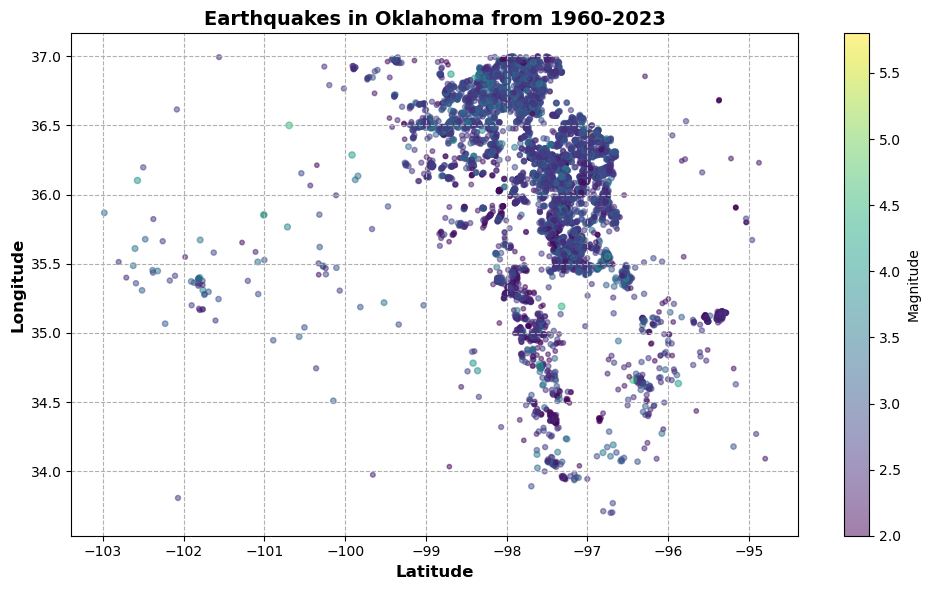

In [52]:
# import the matplolib module

import matplotlib.pyplot as plt


# Initialize empty lists to store coordinates and magnitudes
x_coords = []
y_coords = []
magnitudes = []

# Create a cursor to iterate over the features
with arcpy.da.SearchCursor(eqFC, ["SHAPE@XY", "Magnitude"]) as cursor:
    for row in cursor:
        # Extract x, y coordinates and magnitude
        x, y = row[0]
        magnitude = row[1]
        
        # Append to lists
        x_coords.append(x)
        y_coords.append(y)
        magnitudes.append(magnitude)

# Plot the earthquake color coded by magnitud value
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, s=[mag*5 for mag in magnitudes], c=magnitudes, cmap='viridis', alpha=0.5)  
tit='Earthquakes in %s from 1960-2023' %state_name 
plt.title(tit,fontsize=14,fontweight='bold')
plt.xlabel('Latitude',fontsize=12,fontweight='bold')
plt.ylabel('Longitude',fontsize=12,fontweight='bold')
plt.grid(True,linestyle='--')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Magnitude')
plt.tight_layout()

#save it as png files
outpng= str(state_name) + '_earthquakes.png'
outpng_path=os.path.join(out_maps,outpng)

plt.savefig(outpng_path, dpi=300, bbox_inches='tight')
plt.show()

**This plot shows magnitdue 2+ earhquakes in Oklahoma (from 1960 to 2023), color coded by magnitudes** 

**Form this plot, we can see a large number of low magnitude low magnitude earthquakes are concentrated around the northern-central and south-southeast part of Oklahoma.**


# Plot cumulative number of M2.0+ earthquakes

In [56]:
# make a new table containing cumulative number of eq by year
from collections import defaultdict

# Initialize a defaultdict to store the count of earthquakes by year
earthquake_counts = defaultdict(int)

# Read the "|" delimited text file
with open(outfile_path, 'r') as file:
    # Skip the header line
    next(file)
    for line in file:
        fields = line.strip().split('|')
        if len(fields) >= 2:
            # Extract the year from the date string
            year = fields[1][:4]
            # Increment the count for the current year
            earthquake_counts[year] += 1

# Create a new text file to store the aggregated earthquake counts
cumeq_path=os.path.join(project_data_path,"cum_eq_counts.txt")
with open(cumeq_path, 'w') as output_file:
    cumulative_count = 0
    for year in sorted(earthquake_counts.keys()):
        cumulative_count += earthquake_counts[year]
        output_file.write(f"{year}|{earthquake_counts[year]}|{cumulative_count}\n")

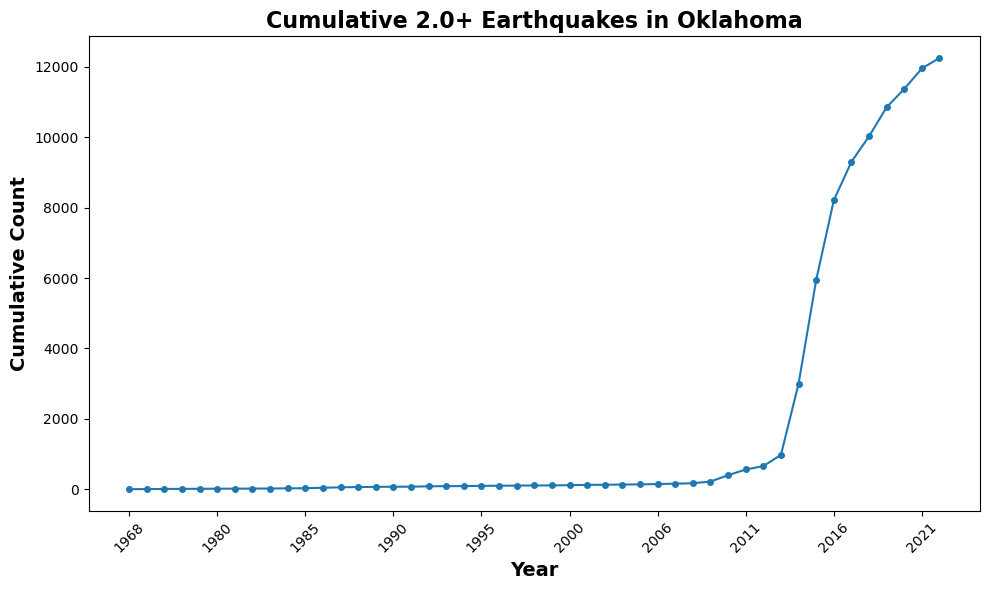

In [57]:
# plot the cumulative curve
import matplotlib.pyplot as plt
cumeq_path=os.path.join(project_data_path,"cum_eq_counts.txt")
# Initialize lists to store years and cumulative counts
years = []
cumulative_counts = []

# Initialize cumulative count
cumulative_count = 0

# Open the file and iterate through each line
with open(cumeq_path, 'r') as file:
    for line in file:
        # Split the line using "|" delimiter
        fields = line.split("|")
        
        # Extract year and count
        year = fields[0]
        c_count = int(fields[2])  # Convert count to integer
        
        # Accumulate count
        #cumulative_count += count
        
        # Append to lists
        years.append(year)
        cumulative_counts.append(c_count)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, cumulative_counts, marker='o', linestyle='-',markersize=4)
plt.title('Cumulative 2.0+ Earthquakes in ' + str(state_name), fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Count', fontsize=14, fontweight='bold')
plt.xticks(years[::5], rotation=45) 
plt.grid(False)
plt.tight_layout()
#plt.show()

# save the plot as png file 
png_name='cumulative_eq_count_%s.png' %state_name
outpng_path=os.path.join(out_maps,png_name)

plt.savefig(outpng_path,dpi=300)  
plt.show()

**This plot shows the sudden jump the seismicity in Okalhama from 2011 when the injection wells were reached its peak number** 

## Analyze the temporal seimicity patten change due to the injection

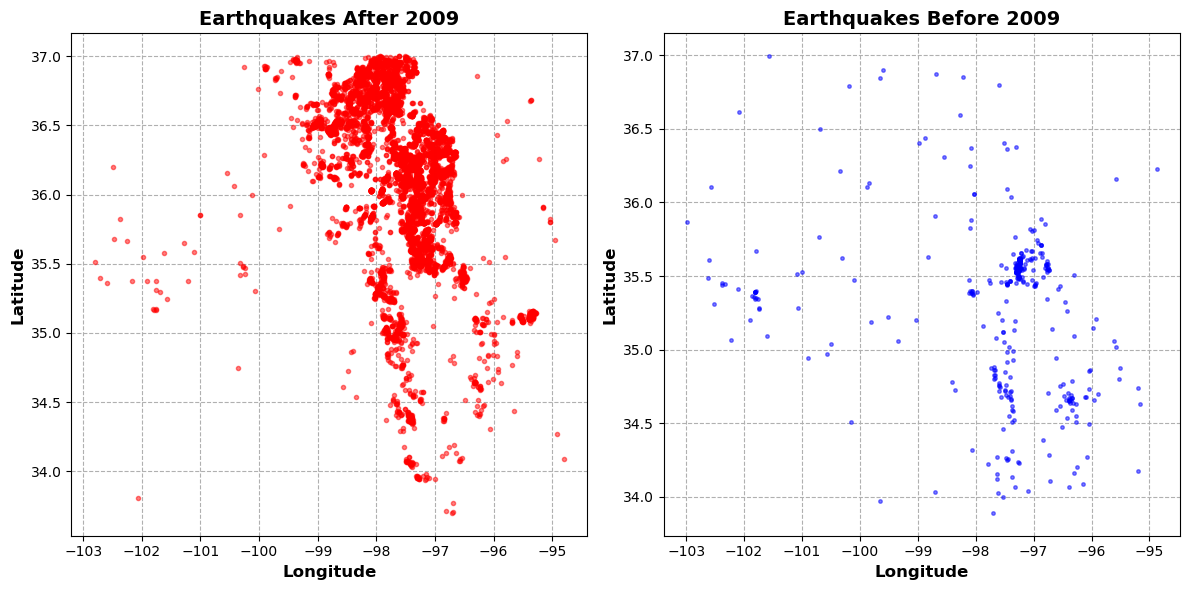

In [58]:
# This codeblock plot the earthquakes befter and after 2011 to see if we can see any pattern

import arcpy
import matplotlib.pyplot as plt

# Set the workspace and feature class path

earthquake_fc = eqFC # Change to your earthquake feature class name

# Define the SQL queries to filter earthquakes before and after 2009
query_before_2009 = "DateTime >= timestamp '2011-01-01 00:00:00'"
query_after_2009 = "DateTime < timestamp '2011-01-01 00:00:00'"

# Create two separate feature layers based on the SQL queries
arcpy.MakeFeatureLayer_management(earthquake_fc, "earthquakes_before_2009", query_before_2009)
arcpy.MakeFeatureLayer_management(earthquake_fc, "earthquakes_after_2009", query_after_2009)

# Get earthquake locations and plot them
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot earthquakes before 2009
with arcpy.da.SearchCursor("earthquakes_before_2009", ["SHAPE@X", "SHAPE@Y"]) as cursor:
    for row in cursor:
        axes[0].plot(row[0], row[1], 'ro', markersize=3, alpha=0.5)

axes[0].set_title('Earthquakes After 2009', fontsize=14,fontweight='bold')
axes[0].set_xlabel('Longitude', fontsize=12,fontweight='bold')
axes[0].set_ylabel('Latitude', fontsize=12,fontweight='bold')
axes[0].grid(linestyle='--')

# Plot earthquakes after 2009
with arcpy.da.SearchCursor("earthquakes_after_2009", ["SHAPE@X", "SHAPE@Y"]) as cursor:
    for row in cursor:
        axes[1].plot(row[0], row[1], 'bo', markersize=2.5, alpha=0.5)

axes[1].set_title('Earthquakes Before 2009', fontsize=14,fontweight='bold')
axes[1].set_xlabel('Longitude', fontsize=12,fontweight='bold')
axes[1].set_ylabel('Latitude', fontsize=12,fontweight='bold')
axes[1].grid(linestyle='--')

# Adjust layout
plt.tight_layout()

#save it as png files
outpng= str(state_name) + '_eq_comparison.png'
outpng_path=os.path.join(out_maps,outpng)
plt.savefig(outpng_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


**This fiugre shows the earthquake location before and after 2011, when we see the onset of the higher seismicty in Oklahoma.**    
**We also see the change of seismicity pattens after 2011, where a huge swarm of earthquake are concentrated in the northern part of the state.**


## Undertand the relationship between earthquakes and active faults

**In this section, I'll explore whether we can discern the spatial relationship among the active faults and earthquakes in this region.** 


In [16]:
# This codeblock create a new featureclass form US states that only have the satae of interest(Oklahoma)

# Input feature class containing US states
inputFC_path= os.path.join(GDBpath,stateFc)

# Output feature class name and path containing only Oklahoma
outFC_state_path = os.path.join(GDBpath,state_name)

# SQL expression to select only Oklahoma
sql_expression = "STATE_NAME = '%s'" %state_name

# Execute Select_analysis to create a new feature class
arcpy.Select_analysis(inputFC_path, outFC_state_path,sql_expression)

In [17]:
# clip the fault using state bounding geometry of the state 

# Input feature class to be clipped
faultFC = "US_faults"
outFC_state_path=os.path.join(GDBpath,state_name)
# Output clipped feature class
state_fault='%s_faults' %state_name

clipFC_path=os.path.join(GDBpath,state_fault)

# Clip the input feature class using the OK state feature class
arcpy.analysis.Clip(faultFC, outFC_state_path, clipFC_path)


In [18]:
# create earthquake featue class 

arcpy.env.workspace=GDBpath
# Output kernel density raster
eq_density = "%s_eq_density" %state_name

binSize = "18 Kilometers"
neighborhoodSize = "36 Kilometers"
wt="UNIFORM"

arcpy.gapro.CalculateDensity(eqFC, eq_density, "SQUARE", binSize, wt, neighborhoodSize)


**Make a denstiy map of the eatquakes**

* In this step, I set up the project file and map layouts to for better plotting and visualizaion

In [31]:
projectLocation=os.path.join(BaseDirectory,"project_mohimanul.aprx")
#projectLocation=r"C:\Users\tnm\Documents\ArcGIS\Final_project\project_mohimanul_3.aprx"
# reference the project
aprxProject = arcpy.mp.ArcGISProject(projectLocation)

#Maps = aprxProject.listMaps()

mainMap = aprxProject.listMaps('Map_Density')[0]

Layouts = aprxProject.listLayouts('EQ_density_with_fault')[0]

print(mainMap)

#print(projectLayout)
Layers =  mainMap.listLayers()


#eq_density layer
eq_density_lyr = mainMap.listLayers(eq_density)[0]
print(eq_density_lyr)
# state layer
state_lyr = mainMap.listLayers(state_name)[0]
print(state_lyr)
# fault layer 
fault_lyr = mainMap.listLayers(state_fault)[0]
print(fault_lyr)



Oklahoma_eq_density
Oklahoma
Oklahoma_faults


In [88]:
# list elements
#rojectMapFrame = Layouts.listElements('MAPFRAME_ELEMENT', "mainMap Map Frame")[0]



In [32]:
## change the map title
mapTitle_text="%s Earthquake Density (km^2) with active faults" %state_name

elm =Layouts.listElements("TEXT_ELEMENT")
for e in elm:
    if (e.name == "Title"):
        e.text = mapTitle_text

        
# change the map extent

projectMapFrame = Layouts.listElements('MAPFRAME_ELEMENT',"Map Frame")[0]


desc=arcpy.Describe(eq_density)
extent=desc.extent
#print(projectMapFrame)

# change extent
projectMapFrame.panToExtent(extent)

# upadate the connection properties for adding faults and eq density 

# for fault
fault_cp = fault_lyr.connectionProperties
existingDataset = fault_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': state_fault})


# for eq density 
eq_density_cp = eq_density_lyr.connectionProperties
existingDataset = eq_density_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': eq_density})


# for state bounding polygon
state_cp = state_lyr.connectionProperties
existingDataset = state_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': state_name})



# save the project.
aprxProject.save()


Oklahoma_faults
Oklahoma_eq_density
Oklahoma


In [22]:
# save the map as png
aprxProject = arcpy.mp.ArcGISProject(projectLocation)

mainMap = aprxProject.listMaps('Map_Density')[0]
Layouts = aprxProject.listLayouts('EQ_density_with_fault')[0]

outPNG='%s_Eq_density_fault' %state_name
outPNG_path = os.path.join(out_maps, outPNG)
#Export the map as a .png
Layouts.exportToPNG(outPNG_path)

'c:\\Users\\tnm\\OneDrive - University of Missouri\\GIS2\\IslamGISNotebooks\\FinalProject\\Figures\\Oklahoma_Eq_density_fault_2.png'

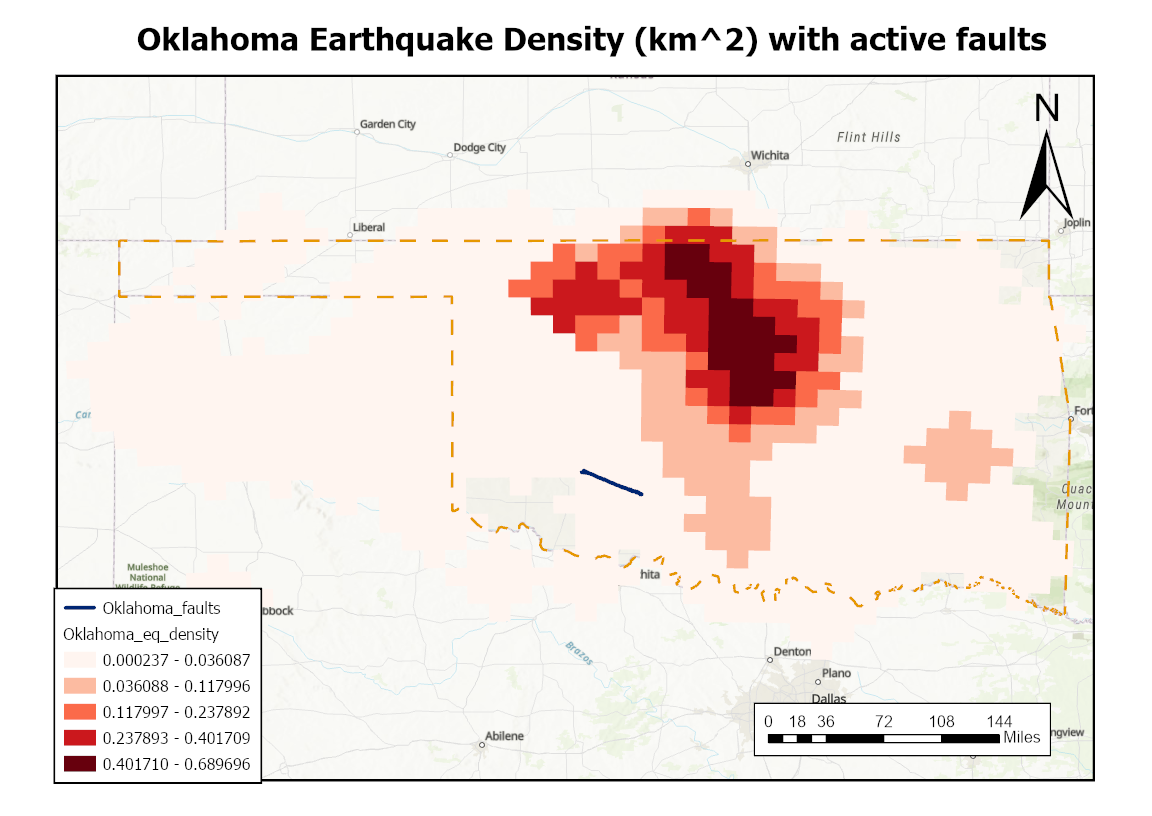

**The above figure shows the eathquke density (per km2) and active faults in Oklahoma that demonstrate geological evidence of 
coseismic surface deformation in large earthquakes during the past 1.6 million years (Ma)**

**The number of active faults in Oklahoma is notably limited, confined primarily to the southwest region of the state. In stark contrast, earthquake occurrences are concentrated in disparate areas. This discrepancy strongly suggests a connection between recent earthquakes and injection/fracking activities. As previously noted, saltwater injection and fracking operations lead to a increase in pore pressure, thereby triggering activity along pre-existing fault lines or weaknesses. When pressure surpasses the threshold limit, these faults fail, resulting in the sudden release of energy felt as earthquakes..**

## Spatial relationshiop between the eartquakes and injection activity
**In part, I want look wherther we can find the relationship between the eartquakes and areas affected by injection well. Since most of wells are horizontal in nature and ofter goes thousandes of meters away form the drilling point, I will make a 5 km buffer zone aroud the wells.**

In [21]:
# create a buffer zone aroud the wells 
wellFC= '%s_class_II_injection_wells' %state_name_abr

# Output buffer feature class
wellFC_buf = "well_buffer"

# Distance for buffer (5 kilometers in this case)
buffer_distance = "5 Kilometers"

# Create buffer
arcpy.Buffer_analysis(in_features=wellFC, out_feature_class=wellFC_buf,
                      buffer_distance_or_field=buffer_distance,dissolve_option='ALL')


**Update the maps layouts and replot the map**

In [38]:
# update the maps layouts and replot the map

projectLocation=os.path.join(BaseDirectory,"project_mohimanul.aprx")
#projectLocation=r"C:\Users\tnm\Documents\ArcGIS\Final_project\project_mohimanul_4.aprx"
# reference the project
aprxProject = arcpy.mp.ArcGISProject(projectLocation)



mainMap = aprxProject.listMaps('Map_Wells')[0]

Layouts = aprxProject.listLayouts('Wells_EQ_density')[0]

print(mainMap)

#print(projectLayout)
Layers =  mainMap.listLayers()


#eq_density layer
eq_density_lyr = mainMap.listLayers(eq_density)[0]
print(eq_density_lyr)
# state layer
state_lyr = mainMap.listLayers(state_name)[0]
print(state_lyr)
# fault layer 
well_lyr = mainMap.listLayers(wellFC_buf)[0]
print(well_lyr)


Oklahoma_eq_density
Oklahoma
well_buffer


In [34]:
Maps = aprxProject.listMaps()
mainMap = aprxProject.listMaps('Map_Wells')[0]
#for m in Maps:
#    print(m.name)
    
#Layouts = aprxProject.listLayouts()
Layers=mainMap.listLayers()
for l in Layers:
    print(l.name)
    
elm =Layouts.listElements("TEXT_ELEMENT")
for e in elm:
    if (e.name == "Title"):
        print(e.text)


well_buffer
Oklahoma
Oklahoma_faults
Oklahoma_eq_density
World Topographic Map
World Hillshade
Oklahoma injection well areas with EQ density


In [39]:
## change the map title
mapTitle_text="%s injection well areas with EQ density" %state_name

elm =Layouts.listElements("TEXT_ELEMENT")
for e in elm:
    if (e.name == "Title"):
        e.text = mapTitle_text

        
# change the map extent

projectMapFrame = Layouts.listElements('MAPFRAME_ELEMENT',"Map Frame")[0]


desc=arcpy.Describe(eq_density)
extent=desc.extent
#print(projectMapFrame)

# change extent
projectMapFrame.panToExtent(extent)

# upadate the connection properties for adding faults and eq density 

# for well buffer
well_cp = well_lyr.connectionProperties
existingDataset = well_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': wellFC_buf})


# for eq density 
eq_density_cp = eq_density_lyr.connectionProperties
existingDataset = eq_density_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': eq_density})


# for state bounding polygon
state_cp = state_lyr.connectionProperties
existingDataset = state_cp['dataset']
print(existingDataset)
aprxProject.updateConnectionProperties({'dataset':existingDataset}, {'dataset': state_name})



# save the project.
aprxProject.save()


well_buffer
Oklahoma_eq_density
Oklahoma


In [40]:
# save the map as png
aprxProject = arcpy.mp.ArcGISProject(projectLocation)

mainMap = aprxProject.listMaps('Map_Wells')[0]
Layouts = aprxProject.listLayouts('Wells_EQ_density')[0]

outPNG='%s_Eq_density_wells_2' %state_name
outPNG_path = os.path.join(out_maps, outPNG)
#Export the map as a .png
Layouts.exportToPNG(outPNG_path)

'c:\\Users\\tnm\\OneDrive - University of Missouri\\GIS2\\IslamGISNotebooks\\FinalProject\\Figures\\Oklahoma_Eq_density_wells_2.png'

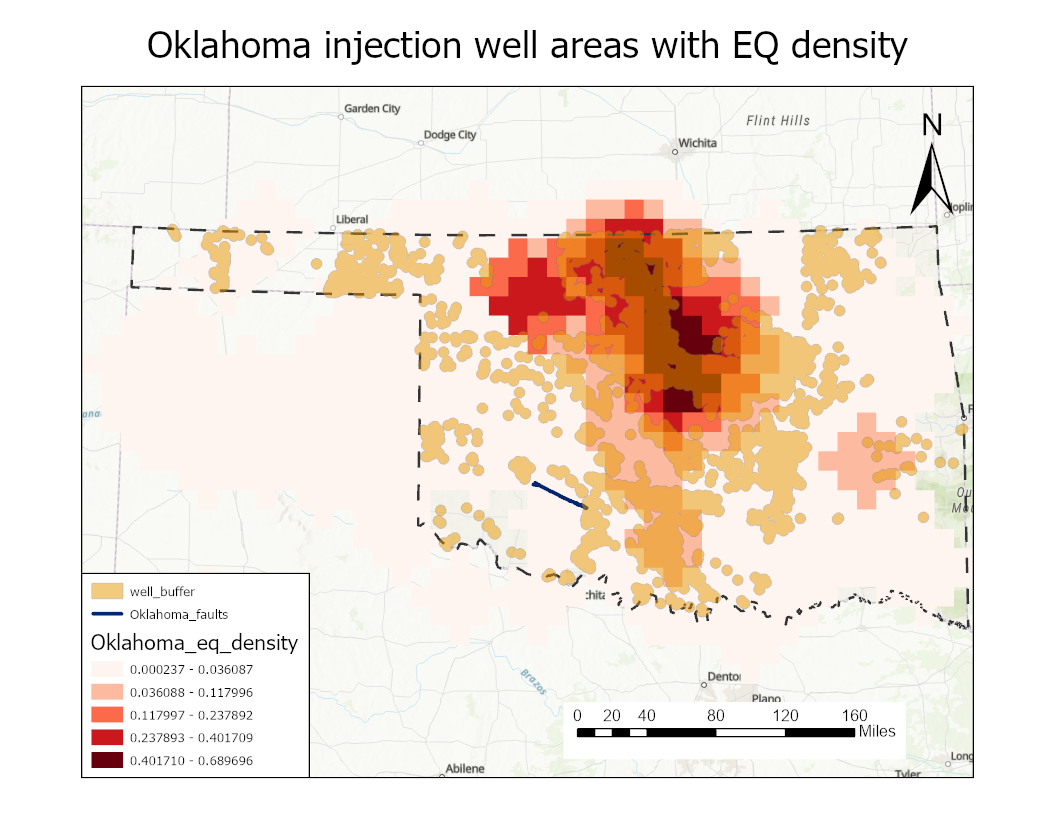

**From this figure, it's evident that the 5 km buffer around the injection wells is primarily concentrated in the north-central region of the state, coinciding with areas exhibiting higher earthquake density. This spatial pattern aligns with the elevated injection volumes in the northern sector (MaGarr, 2014; Walsh & Zoback, 2015), contributing to increased pore pressure within the reservoir. Consequently, this heightened pressure likely instigates frequent slip events within the geological weak zones.**

## Conclusion
**This study showcases the application of geospatial analysis using publicly available datasets. By employing straightforward GIS analysis techniques, we can readily identify well-known phenomena such as induced seismicity.**

**Here, I have analyzed  With the aid of scripting, this can be done  In the context of triggered seismicity, the largest earthquake that might be triggered is determined by preexisting geologic conditions, not the magnitude of the perturbation of pore pressure.**


# References

    W.-Y. Kim, Induced seismicity associated with fluid injection into a deep well in Youngstown, Ohio. J. Geophys. Res. 118, 3506–3518 (2013).
    C. Frohlich, W. Ellsworth, W. A. Brown, M. Brunt, J. Luetgert, T. MacDonald, S. Walter, The 17 May 2012 M4.8 earthquake near Timpson, East Texas: An event possibly triggered by fluid injection. J. Geophys. Res. 119, 581–593 (2014).
    S. Horton, Disposal of hydrofracking waste fluid by injection into subsurface aquifers triggers earthquake swarm in central Arkansas with potential for damaging earthquake. Seismol. Res. Lett. 83, 250–260 (2012)
    A McGarr, B. Bekins, N. Burkardt, J. Dewey, P. Earle, W. Ellsworth, S. Ge, S. Hickman, A. Holland, E. Majer, J. Rubinstein, A. Sheehan, Coping with earthquakes induced by fluid injection. Science 347, 830–831 (2015)
    F. Rall Walsh, III, Mark D. Zoback ,Oklahoma’s recent earthquakes and saltwater disposal.Sci. Adv.1,e1500195(2015).DOI:10.1126/sciadv.1500195
    A. McGarr, Maximum magnitude earthquakes induced by fluid injection. J. Geophys. Res. 119, 1008–1019 (2014).